In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import os
from astropy.modeling import models
from astropy import units as u
from scipy.optimize import curve_fit
from astropy.timeseries import LombScargle
from scipy.special import voigt_profile
import Analysis_functions as AF
from importlib import reload

## Some preliminary info.

In [114]:
day = '2023-02-03'
new = True
location = '/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/new_Solar-data/'+day
os.chdir(location)
if not os.path.exists('Plot_Results'):
    os.mkdir('Plot_Results')

In [115]:
blaze_dir = 'Blaze-data'

In [116]:
dir_name = 'Corr-data'
test = pf.open(dir_name+'/'+sorted(os.listdir(dir_name))[-1])

test.info()

Filename: Corr-data/r.NIRPS.2023-02-03T18:10:32.551_S2D_BLAZE_TELL_CORR_A.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1046   ()      
  1  SCIDATA       1 ImageHDU         8   (4084, 71)   float64   
  2  ERRDATA       1 ImageHDU        10   (4084, 71)   float32   
  3  QUALDATA      1 ImageHDU        12   (4084, 71)   int16 (rescales to uint16)   
  4  WAVEDATA_VAC_BARY    1 ImageHDU        10   (4084, 71)   float64   
  5  WAVEDATA_AIR_BARY    1 ImageHDU        10   (4084, 71)   float64   
  6  DLLDATA_VAC_BARY    1 ImageHDU        10   (4084, 71)   float64   
  7  DLLDATA_AIR_BARY    1 ImageHDU        10   (4084, 71)   float64   


In [117]:
test[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2023-04-15T18:44:26' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
ORIGIN  = 'ESO-LASILLA'        / European Southern Observatory                  
TELESCOP= 'ESO-3P6 '           / ESO <TEL>                                      
INSTRUME= 'NIRPS   '           / Instrument used.                               
OBJECT  = 'SUN,FP,G2V'         / Original target.                               
EXPTIME =              50.1597 / [s] Exposure time                              
MJD-OBS =      59978.7573211

In [118]:
CCF_dir_name = 'CCF_RV-data'
test_RV = pf.open(CCF_dir_name+'/'+sorted(os.listdir(CCF_dir_name))[10])


test_RV.info()
test_RV[0].header

Filename: CCF_RV-data/r.NIRPS.2023-02-03T14:20:38.504_CCF_TELL_CORR_A.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1083   ()      
  1  SCIDATA       1 ImageHDU        10   (81, 72)   float32   
  2  ERRDATA       1 ImageHDU        10   (81, 72)   float32   
  3  QUALDATA      1 ImageHDU        10   (81, 72)   int32   


SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2023-04-15T14:12:28' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
ORIGIN  = 'ESO-LASILLA'        / European Southern Observatory                  
TELESCOP= 'ESO-3P6 '           / ESO <TEL>                                      
INSTRUME= 'NIRPS   '           / Instrument used.                               
OBJECT  = 'SUN,FP,G2V'         / Original target.                               
EXPTIME =              50.1597 / [s] Exposure time                              
MJD-OBS =     59978.59766786

# Studying solar spectrum of one day (looking at all times)

In [126]:
#Re-make this cell to make it smaller
reload(AF)

#Extracting the data
if new:
    tot_lamda, tot_spctr, tot_norm_spctr, tot_err, tot_norm_err, tot_SNR, tot_mode, tot_date, tot_RV, tot_RV_err, tot_FWHM, tot_FWHM_err, tot_BIS_SPAN, tot_BIS_SPAN_err, tot_CONTRAST, tot_CONTRAST_err, tot_H2O, tot_H2O_err, tot_O2, tot_O2_err, tot_CO2, tot_CO2_err, tot_AIRM = AF.new_extraction(dir_name, blaze_dir, CCF_dir_name, 14)

else:
    tot_lamda, tot_spctr, tot_norm_spctr, tot_err, tot_norm_err, tot_SNR, tot_mode, tot_date, tot_RV, tot_RV_err, tot_FWHM, tot_FWHM_err, tot_BIS_SPAN, tot_BIS_SPAN_err, tot_CONTRAST, tot_CONTRAST_err, tot_H2O, tot_H2O_err, tot_O2, tot_O2_err, tot_CO2, tot_CO2_err, tot_AIRM = AF.extraction(dir_name, blaze_dir, CCF_dir_name, 14)


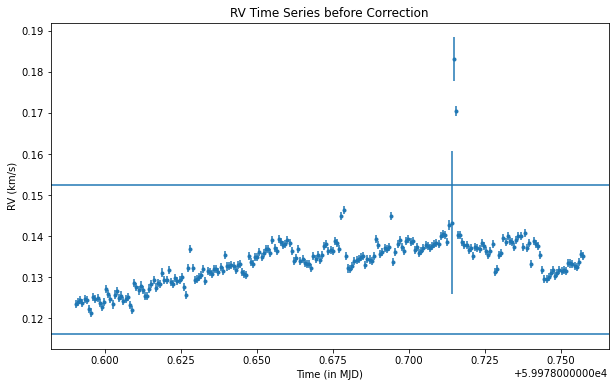

In [120]:
reload(AF)
#Defining a variable to save or not the results.
save = False

#Plotting the RV time series to see the cut and the possible outliers.
    
IQR = np.percentile(tot_RV, 75)-np.percentile(tot_RV, 25)

plt.figure(figsize=[10, 6])
plt.errorbar(tot_date, tot_RV, yerr = tot_RV_err, fmt='.')
plt.axhline((1+20*IQR)*np.median(tot_RV))
plt.axhline((1-20*IQR)*np.median(tot_RV))
plt.xlabel('Time (in MJD)')
plt.ylabel('RV (km/s)')
plt.title('RV Time Series before Correction')
plt.show()

# Reducing the data

In [121]:
reload(AF)
sig = 200
#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(tot_mode=='A') != len(tot_mode) and np.sum(tot_mode=='E')!= len(tot_mode):
    total_SNR_HA, total_SNR_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_SNR, tot_RV, tot_AIRM, sig)
    
    total_spctr_HA, total_spctr_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_spctr, tot_RV, tot_AIRM, sig)

    total_norm_spctr_HA, total_norm_spctr_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_norm_spctr, tot_RV, tot_AIRM, sig)

    total_lamda_HA, total_lamda_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_lamda, tot_RV, tot_AIRM, sig)
    
    total_err_HA, total_err_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_err, tot_RV, tot_AIRM, sig)

    total_norm_err_HA, total_norm_err_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_norm_err, tot_RV, tot_AIRM, sig)
    
    date_HA, date_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_date, tot_RV, tot_AIRM, sig)

    total_RV_HA, total_RV_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_RV, tot_RV, tot_AIRM, sig)

    total_RV_err_HA, total_RV_err_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_RV_err, tot_RV, tot_AIRM, sig)

    total_FWHM_HA, total_FWHM_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_FWHM, tot_RV, tot_AIRM, sig)

    total_FWHM_err_HA, total_FWHM_err_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_FWHM_err, tot_RV, tot_AIRM, sig)

    total_BIS_SPAN_HA, total_BIS_SPAN_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_BIS_SPAN, tot_RV, tot_AIRM, sig)

    total_BIS_SPAN_err_HA, total_BIS_SPAN_err_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_BIS_SPAN_err, tot_RV, tot_AIRM, sig)

    total_CONTRAST_HA, total_CONTRAST_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_CONTRAST, tot_RV, tot_AIRM, sig)

    total_CONTRAST_err_HA, total_CONTRAST_err_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_CONTRAST_err, tot_RV, tot_AIRM, sig)

    total_H2O_HA, total_H2O_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_H2O, tot_RV, tot_AIRM, sig)

    total_H2O_err_HA, total_H2O_err_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_H2O_err, tot_RV, tot_AIRM, sig)

    total_O2_HA, total_O2_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_O2, tot_RV, tot_AIRM, sig)
    
    total_O2_err_HA, total_O2_err_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_O2_err, tot_RV, tot_AIRM, sig)

    total_CO2_HA, total_CO2_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_CO2, tot_RV, tot_AIRM, sig)

    total_CO2_err_HA, total_CO2_err_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_CO2_err, tot_RV, tot_AIRM, sig)

    total_AIRM_HA, total_AIRM_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_AIRM, tot_RV, tot_AIRM, sig)

#If there is one mode of observation
else:
    total_spctr = AF.segment_and_reduce(tot_mode, tot_SNR, tot_spctr, tot_RV, tot_AIRM, sig)

    total_norm_spctr = AF.segment_and_reduce(tot_mode, tot_SNR, tot_norm_spctr, tot_RV, tot_AIRM, sig)

    total_lamda = AF.segment_and_reduce(tot_mode, tot_SNR, tot_lamda, tot_RV, tot_AIRM, sig)
    
    total_err = AF.segment_and_reduce(tot_mode, tot_SNR, tot_err, tot_RV, tot_AIRM, sig)

    total_norm_err = AF.segment_and_reduce(tot_mode, tot_SNR, tot_norm_err, tot_RV, tot_AIRM, sig)
    
    total_SNR = AF.segment_and_reduce(tot_mode, tot_SNR, tot_SNR, tot_RV, tot_AIRM, sig)

    date = AF.segment_and_reduce(tot_mode, tot_SNR, tot_date, tot_RV, tot_AIRM, sig)

    total_RV = AF.segment_and_reduce(tot_mode, tot_SNR, tot_RV, tot_RV, tot_AIRM, sig)

    total_RV_err = AF.segment_and_reduce(tot_mode, tot_SNR, tot_RV_err, tot_RV, tot_AIRM, sig)

    total_FWHM = AF.segment_and_reduce(tot_mode, tot_SNR, tot_FWHM, tot_RV, tot_AIRM, sig)

    total_FWHM_err = AF.segment_and_reduce(tot_mode, tot_SNR, tot_FWHM_err, tot_RV, tot_AIRM, sig)

    total_BIS_SPAN = AF.segment_and_reduce(tot_mode, tot_SNR, tot_BIS_SPAN, tot_RV, tot_AIRM, sig)

    total_BIS_SPAN_err = AF.segment_and_reduce(tot_mode, tot_SNR, tot_BIS_SPAN_err, tot_RV, tot_AIRM, sig)

    total_CONTRAST = AF.segment_and_reduce(tot_mode, tot_SNR, tot_CONTRAST, tot_RV, tot_AIRM, sig)

    total_CONTRAST_err = AF.segment_and_reduce(tot_mode, tot_SNR, tot_CONTRAST_err, tot_RV, tot_AIRM, sig)

    total_H2O = AF.segment_and_reduce(tot_mode, tot_SNR, tot_H2O, tot_RV, tot_AIRM, sig)

    total_H2O_err = AF.segment_and_reduce(tot_mode, tot_SNR, tot_H2O_err, tot_RV, tot_AIRM, sig)

    total_O2 = AF.segment_and_reduce(tot_mode, tot_SNR, tot_O2, tot_RV, tot_AIRM, sig)
    
    total_O2_err = AF.segment_and_reduce(tot_mode, tot_SNR, tot_O2_err, tot_RV, tot_AIRM, sig)

    total_CO2 = AF.segment_and_reduce(tot_mode, tot_SNR, tot_CO2, tot_RV, tot_AIRM, sig)

    total_CO2_err = AF.segment_and_reduce(tot_mode, tot_SNR, tot_CO2_err, tot_RV, tot_AIRM, sig)

    total_AIRM = AF.segment_and_reduce(tot_mode, tot_SNR, tot_AIRM, tot_RV, tot_AIRM, sig)

    
mode = tot_mode

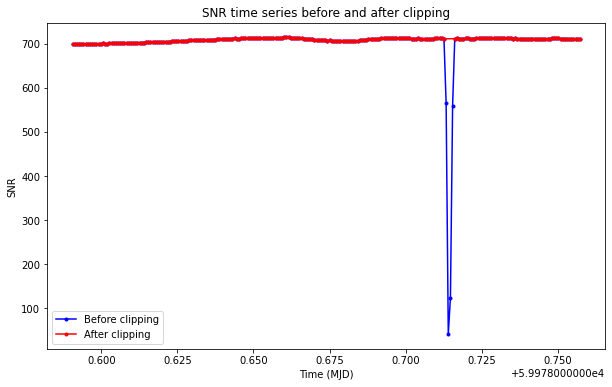

In [122]:
#Plotting the SNR time series to make sure the outliers have been removed
if np.sum(tot_mode=='A') != len(tot_mode) and np.sum(tot_mode=='E')!= len(tot_mode):
    plt.figure(figsize=[10, 6])
    plt.plot(tot_date, tot_SNR, 'b.', linestyle='-', label='Before clipping')
    plt.plot(date_HA, total_SNR_HA, 'r.', linestyle='-', label='After clipping')
    plt.plot(date_HE, total_SNR_HE, 'r.', linestyle='-')
    plt.xlabel('Time (MJD)')
    plt.ylabel('SNR')
    plt.title('SNR time series before and after clipping')
    plt.legend()
else:
    plt.figure(figsize=[10, 6])
    plt.plot(tot_date, tot_SNR, 'b.', linestyle='-', label='Before clipping')
    plt.plot(date, total_SNR, 'r.', linestyle='-', label='After clipping')
    plt.xlabel('Time (MJD)')
    plt.ylabel('SNR')
    plt.title('SNR time series before and after clipping')
    plt.legend()

## Plotting the He triplet for all the spectra of the day

In [ ]:
save=True

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16, 6])

    for i in range(len(total_lamda_HA)):
        ax1.errorbar(total_lamda_HA[i], total_norm_spctr_HA[i], yerr=total_norm_err_HA[i])
        ax1.set_xlabel('Wavelength ($\AA$)')
        ax1.set_ylabel('Flux')
        ax1.set_title('Normalized TC Spectra around He triplet (in vacuum) for HA')
        ax1.set_xlim([10825, 10835])
        ax1.set_ylim([0.3, 1.1])
    
    for i in range(len(total_lamda_HE)):
        ax2.errorbar(total_lamda_HE[i], total_norm_spctr_HE[i], yerr=total_norm_err_HE[i])
        ax2.set_xlabel('Wavelength ($\AA$)')
        ax2.set_ylabel('Flux')
        ax2.set_title('Normalized TC Spectra around He triplet (in vacuum) for HE')
        ax2.set_xlim([10825, 10835])
        ax2.set_ylim([0.3, 1.1])

    ax1.axvline(10833.2, color='b', label='He triplet location')
    ax1.axvline(10833.3, color='b')
    ax1.axvline(10832.1, color='b')

    ax2.axvline(10833.2, color='b', label='He triplet location')
    ax2.axvline(10833.3, color='b')
    ax2.axvline(10832.1, color='b')

    ax1.legend()
    ax2.legend()
    if save:
        plt.savefig('Plot_Results/Superpose_He_triplet_Vacuum.pdf')
    plt.show()
    
#If there is one mode of observation
else:
    plt.figure(figsize=[15, 8])
    for i in range(len(total_lamda)):
        plt.errorbar(total_lamda[i], total_norm_spctr[i], yerr=total_norm_err[i])
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.title('Normalized TC Spectra around He triplet (in vacuum)')
    plt.xlim([10825, 10835])
    plt.ylim([0.3, 1.1])
    
    plt.axvline(10833.2, color='b', label='He triplet location')
    plt.axvline(10833.3, color='b')
    plt.axvline(10832.1, color='b')

    plt.legend()
    if save:
        plt.savefig('Plot_Results/Superpose_He_triplet_Vacuum.pdf')
    plt.show()

## Perform air-to-vacuum correction

In [ ]:
save = True
#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16, 6])

    for i in range(len(total_lamda_HA)):
        ax1.errorbar(AF.vac2air(total_lamda_HA[i]), total_norm_spctr_HA[i], yerr=total_norm_err_HA[i])
        ax1.set_xlabel('Wavelength ($\AA$)')
        ax1.set_ylabel('Flux')
        ax1.set_title('Normalized TC Spectra around He triplet (in air) for HA')
        ax1.set_xlim([10825, 10835])
        ax1.set_ylim([0.3, 1.1])
    
    for i in range(len(total_lamda_HE)):
        ax2.errorbar(AF.vac2air(total_lamda_HE[i]), total_norm_spctr_HE[i], yerr=total_norm_err_HE[i])
        ax2.set_xlabel('Wavelength ($\AA$)')
        ax2.set_ylabel('Flux')
        ax2.set_title('Normalized TC Spectra around He triplet (in air) for HE')
        ax2.set_xlim([10825, 10835])
        ax2.set_ylim([0.3, 1.1])

    ax1.axvline(10829.09, color='b', label='He triplet location')
    ax1.axvline(10830.34, color='b')
    ax1.axvline(10830.25, color='b')

    ax2.axvline(10829.09, color='b', label='He triplet location')
    ax2.axvline(10830.34, color='b')
    ax2.axvline(10830.25, color='b')

    ax1.legend()
    ax2.legend()
    if save:
        plt.savefig('Plot_Results/Superpose_He_triplet_Air.pdf')
    plt.show()
    
#If there is one mode of observation 
else:
    plt.figure(figsize=[15, 8])
    for i in range(len(total_lamda)):
        plt.errorbar(AF.vac2air(total_lamda[i]), total_norm_spctr[i], yerr=total_norm_err[i])
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.title('Normalized TC Spectra around He triplet (in air)')
    plt.xlim([10825, 10835])
    plt.ylim([0.3, 1.1])
    
    plt.axvline(10829.09, color='b', label='He triplet location')
    plt.axvline(10830.34, color='b')
    plt.axvline(10830.25, color='b')

    plt.legend()
    if save:
        plt.savefig('Plot_Results/Superpose_He_triplet_Air.pdf')
    plt.show()

## Plotting the continuum

In [ ]:
save = True
#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16, 6])

    for i in range(len(total_lamda_HA)):
        ax1.errorbar(total_lamda_HA[i], total_norm_spctr_HA[i], yerr=total_norm_err_HA[i], fmt='.')
        ax1.set_xlabel('Wavelength ($\AA$)')
        ax1.set_ylabel('Flux')
        ax1.set_title('Normalized TC Spectra of continuum (in vacuum) for HA')
        ax1.set_xlim([10767, 10770])
        #ax1.set_ylim([0.7, 1.3])
    
    for i in range(len(total_lamda_HE)):
        ax2.errorbar(total_lamda_HE[i], total_norm_spctr_HE[i], yerr=total_norm_err_HE[i], fmt='.')
        ax2.set_xlabel('Wavelength ($\AA$)')
        ax2.set_ylabel('Flux')
        ax2.set_title('Normalized TC Spectra of continuum (in vacuum) for HE')
        ax2.set_xlim([10767, 10770])
        #ax2.set_ylim([0.7, 1.3])

    ax1.legend()
    ax2.legend()
    if save:
        plt.savefig('Plot_Results/Continuum.pdf')
    plt.show()

#If there is one mode of observation
else:
    plt.figure(figsize=[15, 8])
    for i in range(len(total_lamda)):
        plt.errorbar(total_lamda[i], total_norm_spctr[i], yerr=total_norm_err[i], fmt='.')
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.title('Normalized TC Spectra of continuum (in vacuum)')
    plt.xlim([10767, 10770])
    plt.ylim([0.7, 1.3])
    if save:
        plt.savefig('Plot_Results/Continuum.pdf')
    plt.show()

## Calculating the systematics

In [ ]:
reload(AF)
low = 10767
up = 10770

if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):

    SNR_HA = AF.SNR_calculator(low, up, total_lamda_HA, total_spctr_HA, total_err_HA)
    #print(SNR_HA)

    SNR_HE = AF.SNR_calculator(low, up, total_lamda_HE, total_spctr_HE, total_err_HE)
    #print(SNR_HE)
    systematics_HA = total_SNR_HA - SNR_HA
    
    systematics_HE = total_SNR_HE - SNR_HE

else:
    SNR = AF.SNR_calculator(low, up, total_lamda, total_spctr, total_err)
    
    systematics = total_SNR - SNR
    #print(SNR)

## Building a master spectrum

In [ ]:
save = True
#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    
    master_lamda_HA = np.average(total_lamda_HA, axis=0)
    master_norm_spctr_HA = np.average(total_norm_spctr_HA, axis=0, weights=1/total_norm_err_HA**2)
    master_norm_err_HA = 1/np.sqrt(np.sum(1/total_norm_err_HA**2, axis=0))

    master_lamda_HE = np.average(total_lamda_HE, axis=0)
    master_norm_spctr_HE = np.average(total_norm_spctr_HE, axis=0, weights=1/total_norm_err_HE**2)
    master_norm_err_HE = 1/np.sqrt(np.sum(1/total_norm_err_HE**2, axis=0))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16, 6])

    ax1.errorbar(master_lamda_HA, master_norm_spctr_HA, yerr=master_norm_err_HA, fmt='.')
    ax2.errorbar(master_lamda_HE, master_norm_spctr_HE, yerr=master_norm_err_HE, fmt='.')
    ax1.set_xlabel('Wavelength ($\AA$)')
    ax2.set_xlabel('Wavelength ($\AA$)')
    ax1.set_ylabel('Flux')
    ax2.set_ylabel('Flux')
    ax1.set_title('Normalized master spectrum around He triplet for HA')
    ax2.set_title('Normalized master spectrum around He triplet for HE')
    ax1.set_xlim([10825, 10835])
    ax2.set_xlim([10825, 10835])
    ax1.axvline(10833.2, color='red', label='He triplet location')
    ax1.axvline(10833.3, color='red')
    ax1.axvline(10832.1, color='red')
    ax2.axvline(10833.2, color='red', label='He triplet location')
    ax2.axvline(10833.3, color='red')
    ax2.axvline(10832.1, color='red')
    ax1.legend()
    ax2.legend()
    if save:
        plt.savefig('Plot_Results/He_triplet_Master.pdf')
    plt.show()

#If there is one mode of observation
else:
    plt.figure(figsize=[10, 6])
    
    master_lamda = np.average(total_lamda, axis=0)
    master_norm_spctr = np.average(total_norm_spctr, axis=0, weights = 1/total_norm_err**2)
    master_norm_err = 1/np.sqrt(np.sum(1/total_norm_err**2, axis=0))

    plt.errorbar(master_lamda, master_norm_spctr, yerr=master_norm_err, fmt='.')
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.title('Normalized master spectrum around He triplet')
    plt.xlim([10825, 10835])
    plt.ylim(.3, 1.2)
    plt.show()
    if save:
        plt.savefig('Plot_Results/He_triplet_Master.pdf')
    plt.show()

## Making residuals 

In [ ]:
save = True

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16, 6])
    
    for i in range(len(total_norm_spctr_HA)):
        ax1.errorbar(master_lamda_HA, total_norm_spctr_HA[i] - master_norm_spctr_HA, yerr=np.sqrt(total_norm_err_HA[i]**2 + master_norm_err_HA**2), fmt='.')
        ax1.set_xlabel('Wavelength ($\AA$)')
        ax1.set_ylabel('Residuals')
        ax1.set_xlim([10825, 10835])

    for i in range(len(total_norm_spctr_HE)):
        ax2.errorbar(master_lamda_HE, total_norm_spctr_HE[i] - master_norm_spctr_HE, yerr=np.sqrt(total_norm_err_HE[i]**2 + master_norm_err_HE**2), fmt='.')
        ax2.set_xlabel('Wavelength ($\AA$)')
        ax2.set_ylabel('Residuals')
        ax2.set_xlim([10825, 10835])
    ax1.set_title('Residuals  around He triplet for HA')
    ax1.axvline(10833.2, color='b', label='He triplet location')
    ax1.axvline(10833.3, color='b')
    ax1.axvline(10832.1, color='b')

    ax2.set_title('Residuals  around He triplet for HE')
    ax2.axvline(10833.2, color='b', label='He triplet location')
    ax2.axvline(10833.3, color='b')
    ax2.axvline(10832.1, color='b')

    ax1.legend()
    ax2.legend()
    if save: 
        plt.savefig('Plot_Results/He_triplet_Residuals.pdf')
    plt.show()

#If there is one mode of observation
else:
    plt.figure(figsize=[15, 8])  
    for i in range(len(total_norm_spctr)):
        plt.errorbar(master_lamda, total_norm_spctr[i] - master_norm_spctr, yerr=np.sqrt(total_norm_err[i]**2 + master_norm_err**2), fmt='.')
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Residuals')
    plt.xlim([10825, 10835])
    plt.title('Residuals around He triplet')
    plt.axvline(10833.2, color='b', label='He triplet location')
    plt.axvline(10833.3, color='b')
    plt.axvline(10832.1, color='b')

    plt.legend()
    if save: 
        plt.savefig('Plot_Results/He_triplet_Residuals.pdf')
    plt.show()
    

## Fitting a gaussian to the He triplet line

[-6.70290708e-02 -7.81489590e+01  1.08333282e+04  2.80566766e-01
  7.30760386e-03  1.34418451e-02]


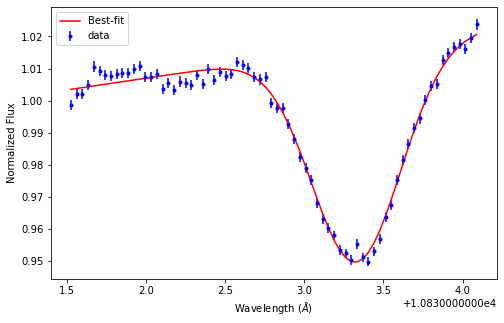

[-6.46331886e-02 -6.14270347e+01  1.08333323e+04  2.75349415e-01
  5.76387286e-03  1.35688666e-02]


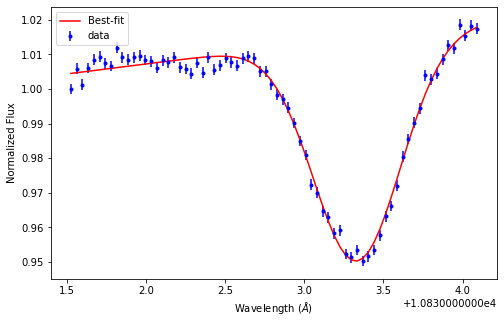

[-6.40700163e-02 -7.33626930e+01  1.08333329e+04  2.72880447e-01
  6.86571867e-03  1.17002426e-02]


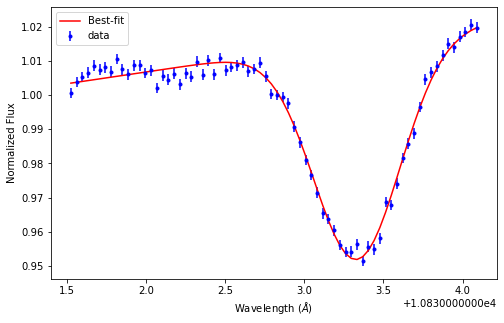

[-6.51899553e-02 -7.57806811e+01  1.08333370e+04  2.74133305e-01
  7.08900280e-03  1.05402521e-02]


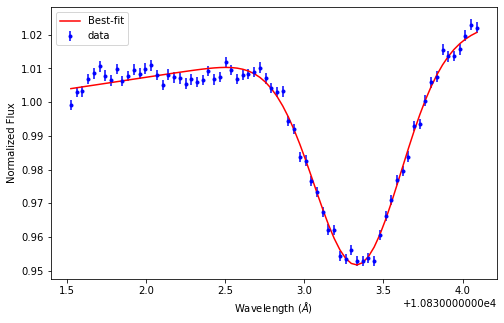

[-6.38925271e-02 -7.16501172e+01  1.08333321e+04  2.65733317e-01
  6.70758103e-03  1.17417895e-02]


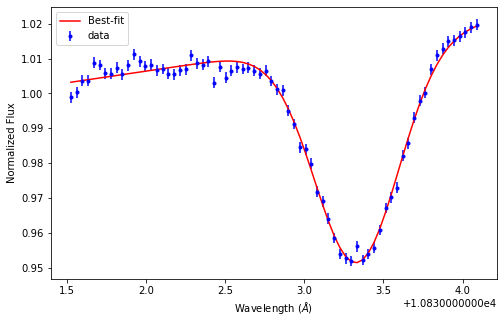

[-6.31368435e-02 -7.16877246e+01  1.08333310e+04  2.70641643e-01
  6.71110312e-03  1.05737690e-02]


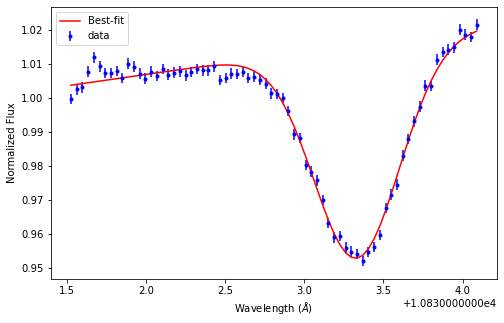

[-6.23935744e-02 -7.11508859e+01  1.08333269e+04  2.73620084e-01
  6.66141136e-03  1.43568680e-02]


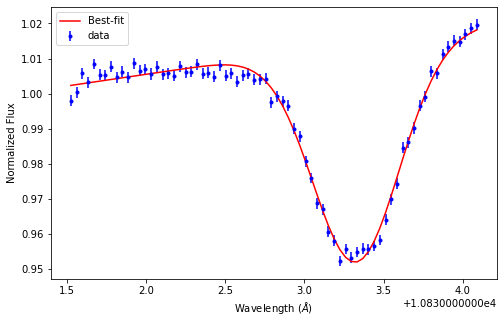

[-6.34011408e-02 -7.13768016e+01  1.08333323e+04  2.71512355e-01
  6.68231338e-03  1.33801526e-02]


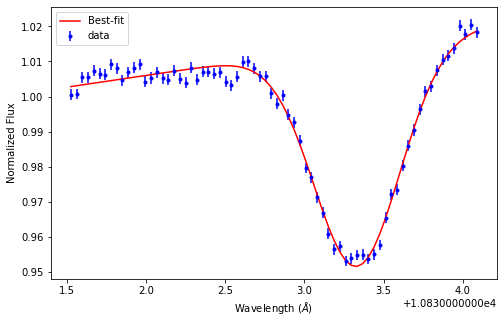

[-6.43520285e-02 -7.92779205e+01  1.08333292e+04  2.80993262e-01
  7.41177022e-03  1.30551435e-02]


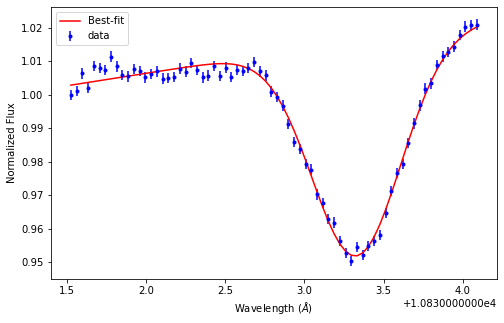

[-6.47993323e-02 -8.61532547e+01  1.08333393e+04  2.84632249e-01
  8.04641009e-03  1.49812167e-02]


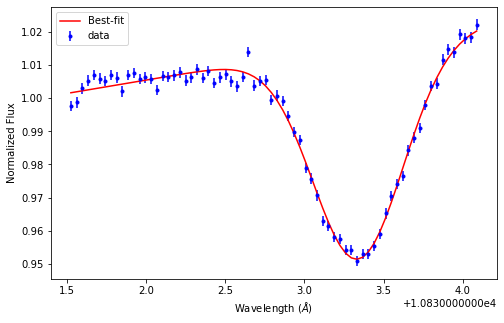

[-6.48854031e-02 -7.87892592e+01  1.08333368e+04  2.78111480e-01
  7.36666862e-03  1.27507228e-02]


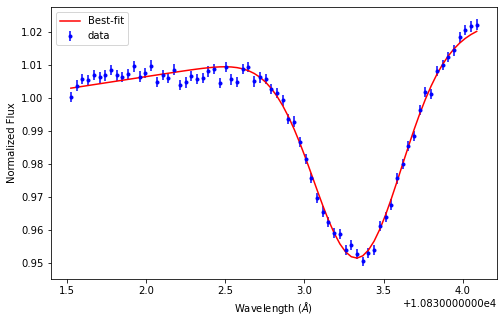

[-6.21966079e-02 -6.90145410e+01  1.08333262e+04  2.78451374e-01
  6.46405689e-03  1.89985548e-02]


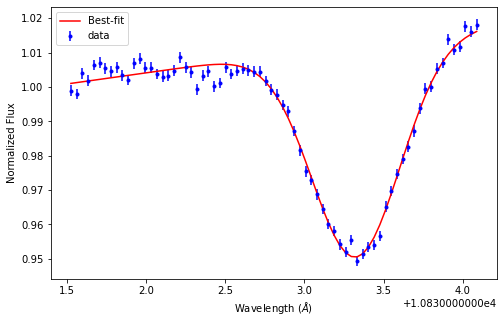

[-6.36192562e-02 -7.65227445e+01  1.08333315e+04  2.84759092e-01
  7.15742243e-03  1.34436357e-02]


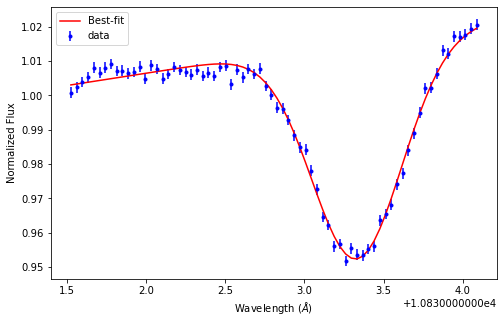

[-6.54762785e-02 -8.18479871e+01  1.08333358e+04  2.86816336e-01
  7.64914542e-03  1.11921643e-02]


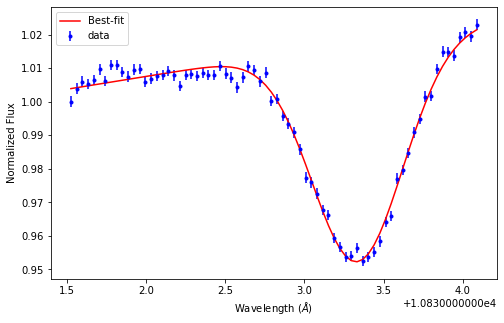

[-6.53617439e-02 -8.32741520e+01  1.08333310e+04  2.90561269e-01
  7.78083459e-03  1.06610465e-02]


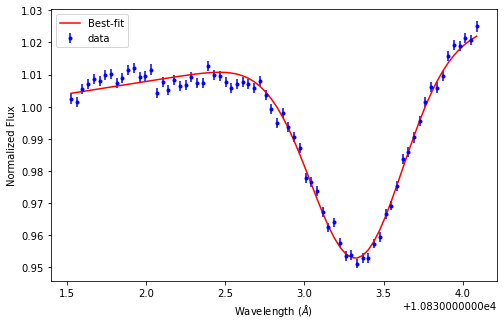

[-6.50844056e-02 -8.41039230e+01  1.08333381e+04  2.89772306e-01
  7.85724996e-03  1.54728065e-02]


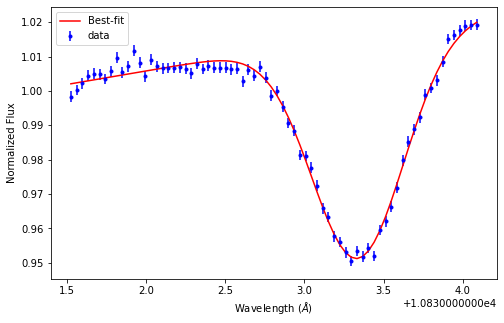

[-6.31262539e-02 -6.95980387e+01  1.08333301e+04  2.87277687e-01
  6.51808054e-03  1.64990216e-02]


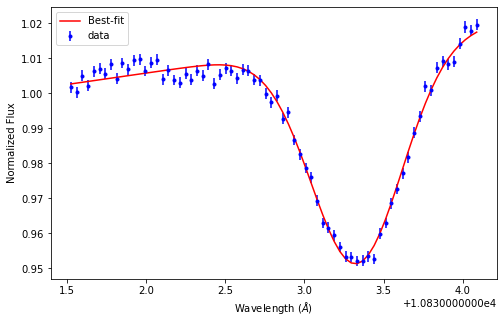

[-6.47057711e-02 -7.17966030e+01  1.08333287e+04  2.82842140e-01
  6.72113907e-03  1.39929765e-02]


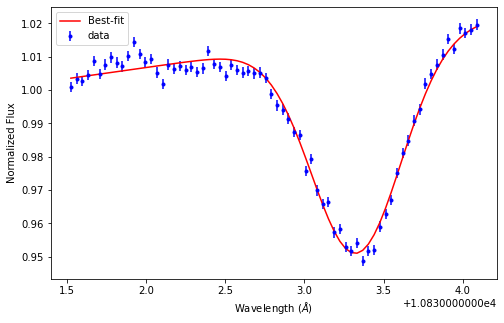

[-6.46646577e-02 -6.94420552e+01  1.08333303e+04  2.78246759e-01
  6.50377013e-03  1.36710852e-02]


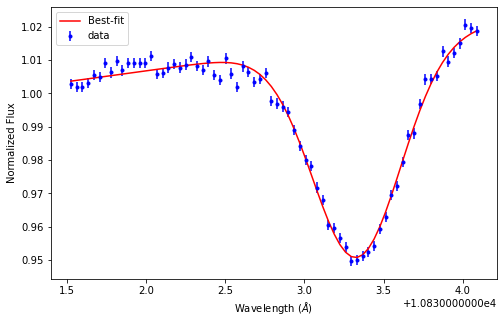

[-6.34434900e-02 -6.97804182e+01  1.08333353e+04  2.78799981e-01
  6.53502168e-03  1.24255994e-02]


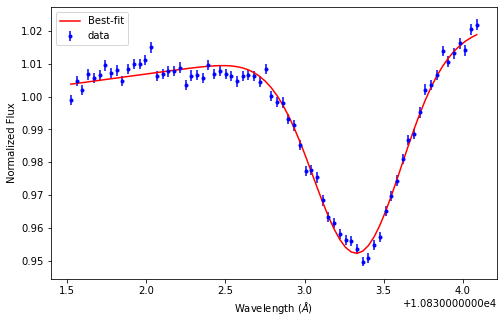

[-6.47534619e-02 -7.05526055e+01  1.08333274e+04  2.76759625e-01
  6.60620832e-03  1.57430088e-02]


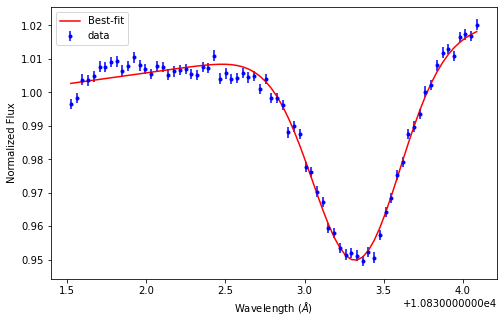

[-6.52891277e-02 -7.41923748e+01  1.08333309e+04  2.85406172e-01
  6.94221592e-03  1.71181882e-02]


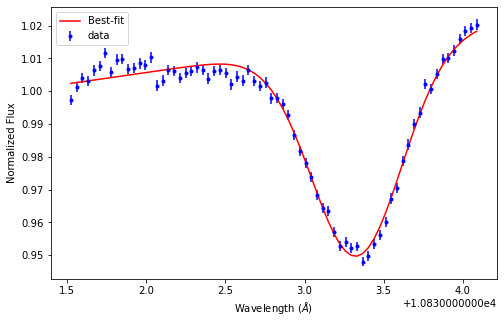

[-6.55607692e-02 -7.35606107e+01  1.08333266e+04  2.81646084e-01
  6.88395254e-03  1.51416809e-02]


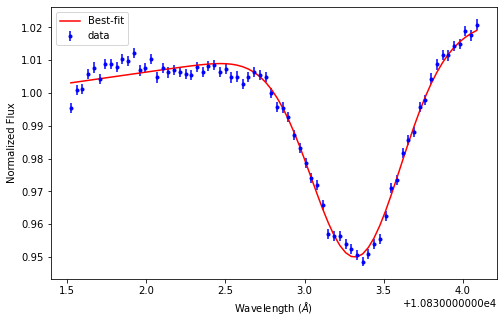

[-6.44692541e-02 -6.78424940e+01  1.08333331e+04  2.72777605e-01
  6.35597982e-03  1.63846345e-02]


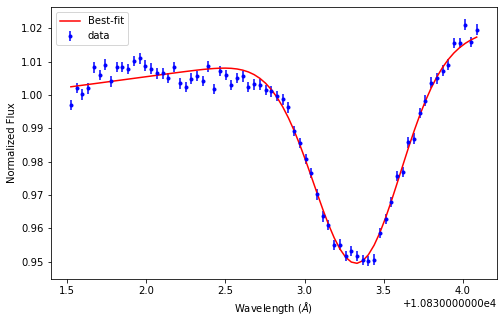

[-6.38664169e-02 -6.50279477e+01  1.08333308e+04  2.75057824e-01
  6.09628995e-03  1.27761104e-02]


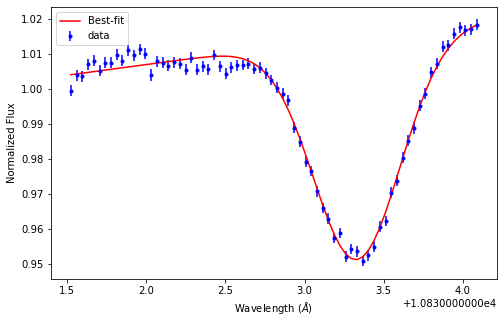

[-6.62738935e-02 -7.37407133e+01  1.08333315e+04  2.71518513e-01
  6.90060396e-03  1.32836417e-02]


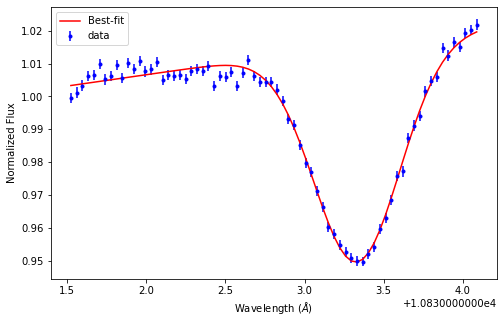

[-6.47991080e-02 -7.21381845e+01  1.08333328e+04  2.78516288e-01
  6.75257973e-03  1.59651105e-02]


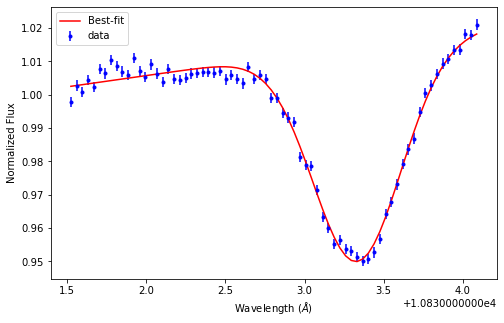

[-6.59333591e-02 -8.25486679e+01  1.08333422e+04  2.82851473e-01
  7.71370966e-03  1.41984486e-02]


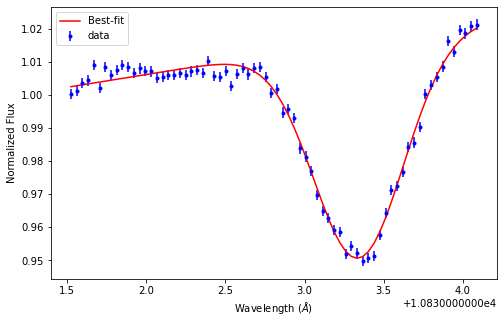

[-6.46986099e-02 -7.74102438e+01  1.08333335e+04  2.80910366e-01
  7.23939760e-03  1.22621552e-02]


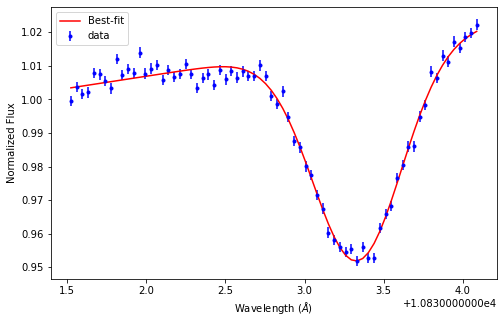

[-6.47392746e-02 -7.47954277e+01  1.08333323e+04  2.73597196e-01
  6.99793678e-03  1.34227019e-02]


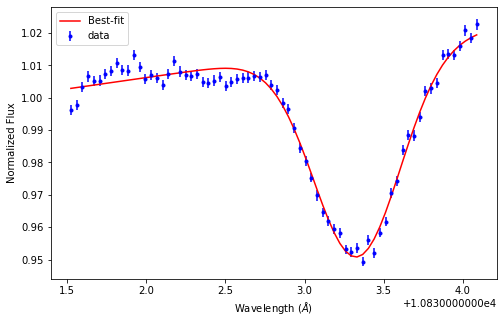

[-6.57048157e-02 -7.31357058e+01  1.08333352e+04  2.67208149e-01
  6.84466340e-03  1.47610492e-02]


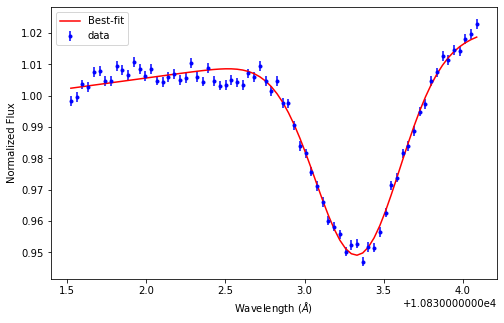

[-6.37681094e-02 -7.03747857e+01  1.08333312e+04  2.67347433e-01
  6.58973398e-03  1.52676305e-02]


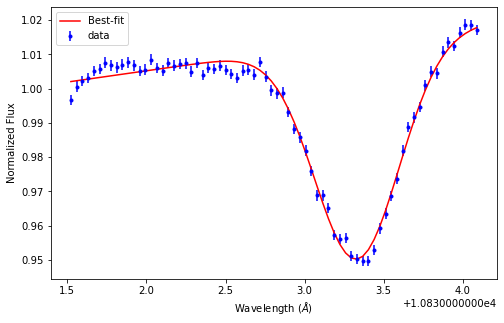

[-6.50453554e-02 -7.35083191e+01  1.08333305e+04  2.71593061e-01
  6.87916874e-03  1.19618952e-02]


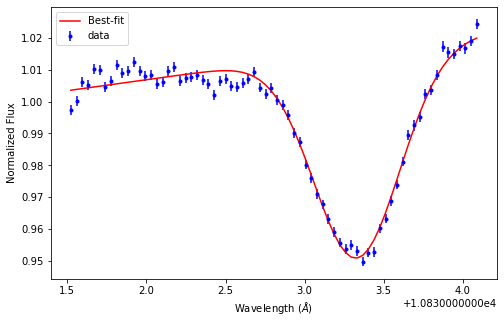

[-6.43417275e-02 -7.50982689e+01  1.08333266e+04  2.82769960e-01
  7.02596431e-03  1.25891789e-02]


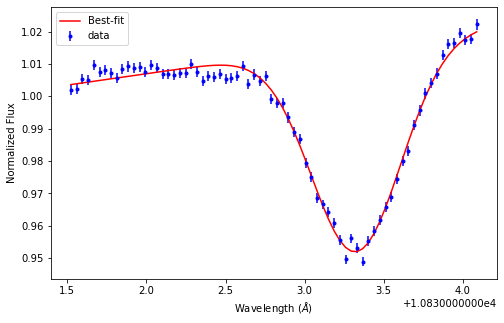

[-6.49381925e-02 -7.81636392e+01  1.08333299e+04  2.85883443e-01
  7.30885573e-03  1.57432636e-02]


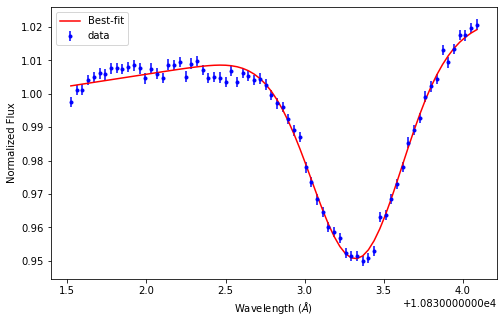

[-6.55554441e-02 -7.34632337e+01  1.08333381e+04  2.78671070e-01
  6.87500562e-03  1.34853519e-02]


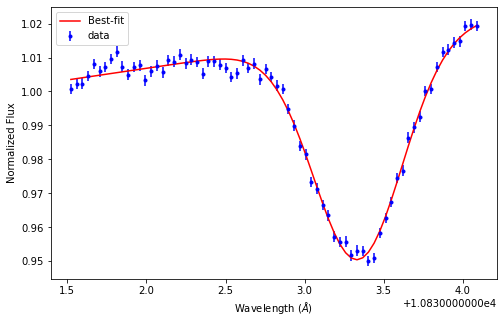

[-6.55387201e-02 -8.03905632e+01  1.08333357e+04  2.84376766e-01
  7.51449439e-03  1.40505824e-02]


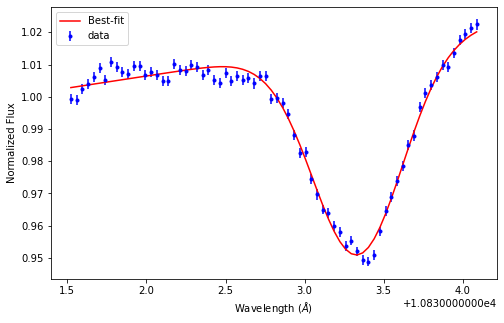

[-6.55855360e-02 -7.53420965e+01  1.08333351e+04  2.77550244e-01
  7.04838692e-03  1.50338999e-02]


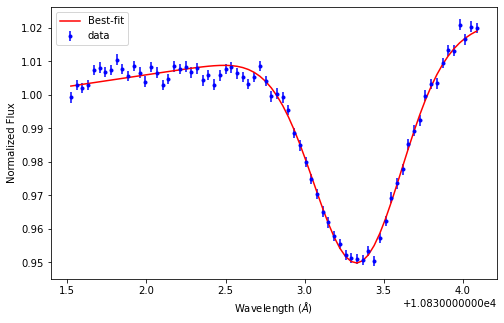

[-6.46018336e-02 -7.29849549e+01  1.08333338e+04  2.86999700e-01
  6.83082534e-03  1.49667611e-02]


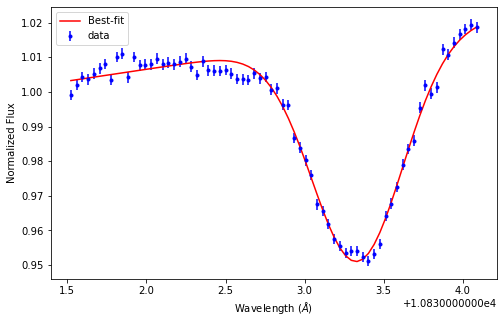

[-6.53838104e-02 -7.27295925e+01  1.08333314e+04  2.79997927e-01
  6.80721151e-03  1.55650995e-02]


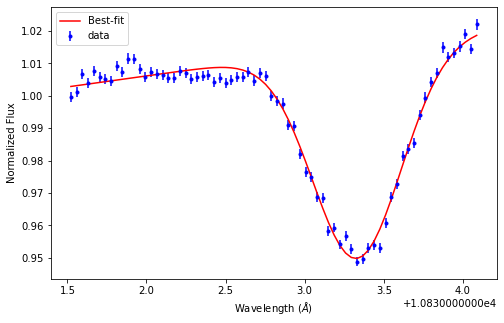

[-6.56953518e-02 -7.63348691e+01  1.08333355e+04  2.83128605e-01
  7.14003085e-03  1.60320487e-02]


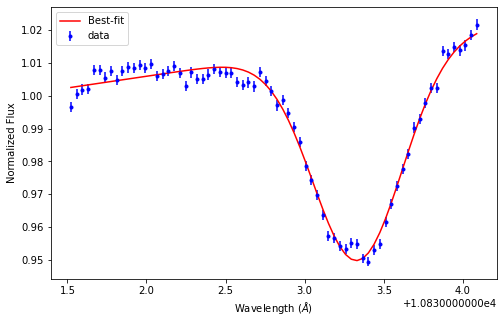

[-6.60809535e-02 -7.75023280e+01  1.08333319e+04  2.82634228e-01
  7.24781632e-03  1.58150399e-02]


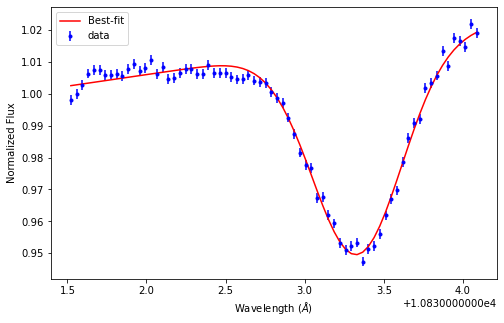

[-6.62922609e-02 -7.06721117e+01  1.08333279e+04  2.87517192e-01
  6.61733287e-03  1.59456467e-02]


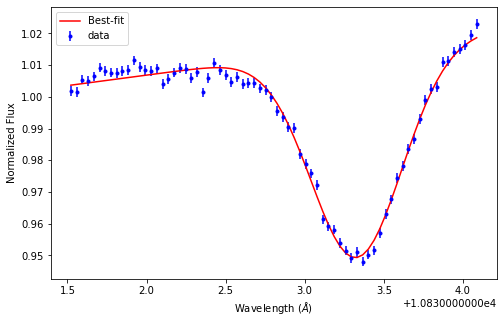

[-6.31771751e-02 -5.80687567e+01  1.08333296e+04  2.68896167e-01
  5.45386074e-03  1.16422322e-02]


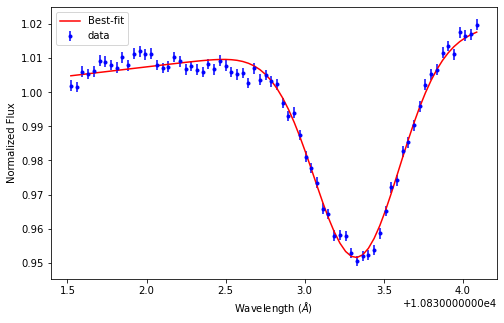

[-6.47543067e-02 -6.27297021e+01  1.08333251e+04  2.71688113e-01
  5.88392911e-03  1.86237876e-02]


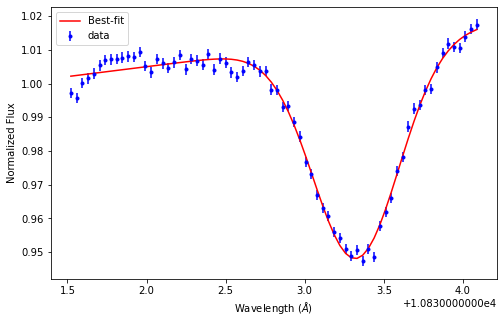

[-6.56664965e-02 -6.45064313e+01  1.08333274e+04  2.73475807e-01
  6.04817484e-03  1.29811778e-02]


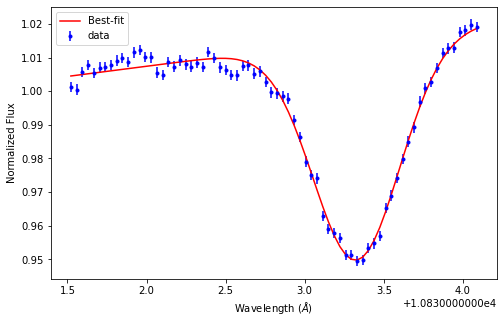

[-6.64574934e-02 -7.00866135e+01  1.08333278e+04  2.76213776e-01
  6.56335972e-03  1.21005252e-02]


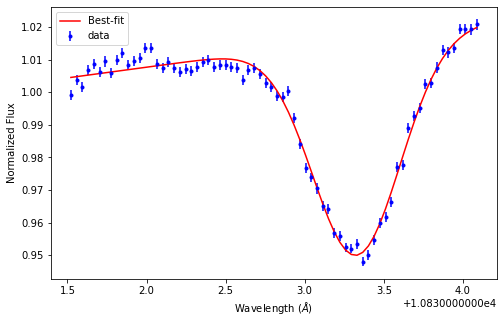

[-6.41812637e-02 -6.28871562e+01  1.08333291e+04  2.76928096e-01
  5.89875955e-03  1.07306195e-02]


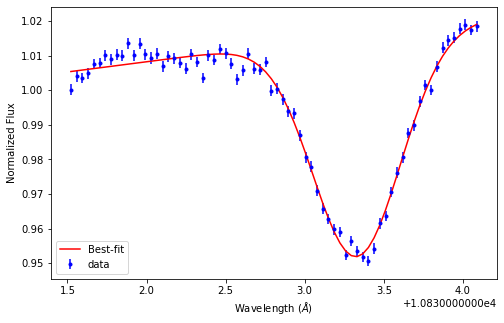

[-6.45801566e-02 -6.69989528e+01  1.08333326e+04  2.77779225e-01
  6.27832880e-03  1.11258802e-02]


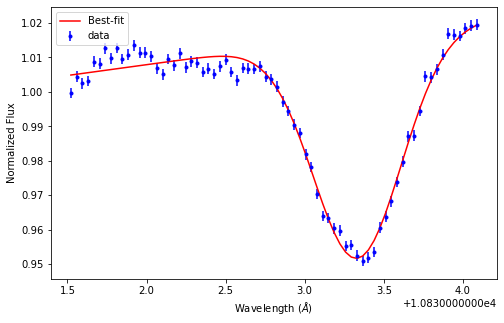

[-6.49000463e-02 -5.80812271e+01  1.08333274e+04  2.75251399e-01
  5.45497186e-03  1.49467311e-02]


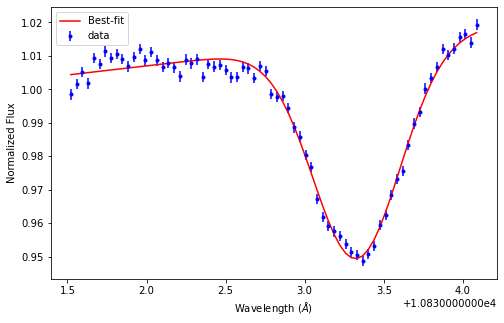

[-6.48421980e-02 -6.34740851e+01  1.08333354e+04  2.76596496e-01
  5.95285998e-03  1.33739964e-02]


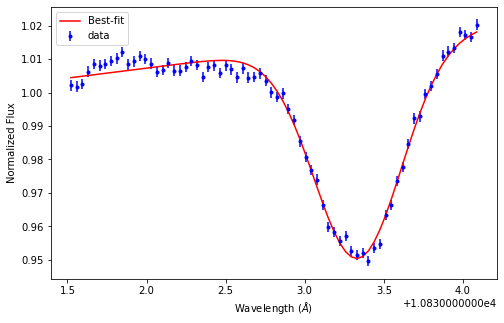

[-6.48417173e-02 -6.34870931e+01  1.08333285e+04  2.77179876e-01
  5.95401980e-03  1.46275825e-02]


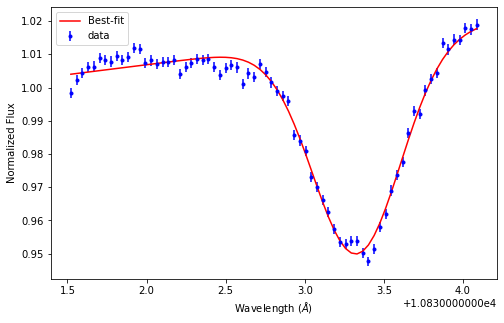

[-6.41318813e-02 -6.76702068e+01  1.08333289e+04  2.75822945e-01
  6.34008864e-03  1.63015325e-02]


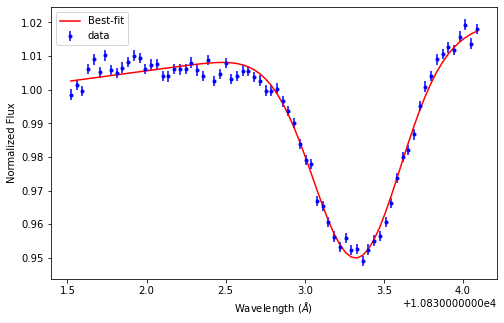

[-6.64124278e-02 -7.87554853e+01  1.08333344e+04  2.81923163e-01
  7.36360091e-03  1.30452336e-02]


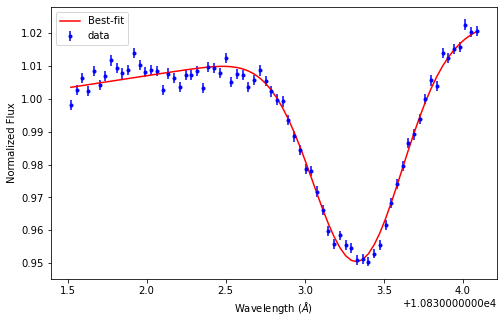

[-6.57713587e-02 -7.29728170e+01  1.08333273e+04  2.79061471e-01
  6.82976676e-03  1.28128787e-02]


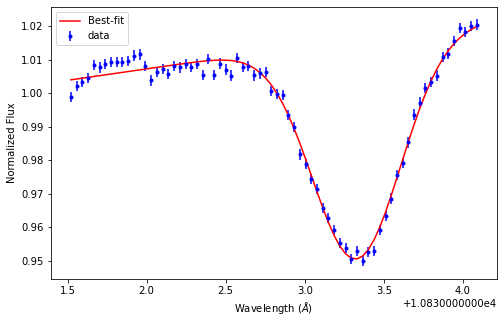

[-6.45096333e-02 -5.82638068e+01  1.08333307e+04  2.71214467e-01
  5.47180628e-03  1.46194879e-02]


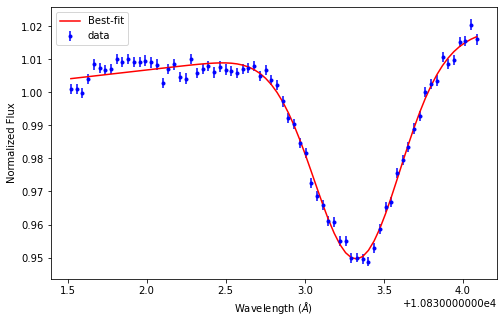

[-6.42128047e-02 -5.91992362e+01  1.08333263e+04  2.71865363e-01
  5.55803926e-03  1.78513436e-02]


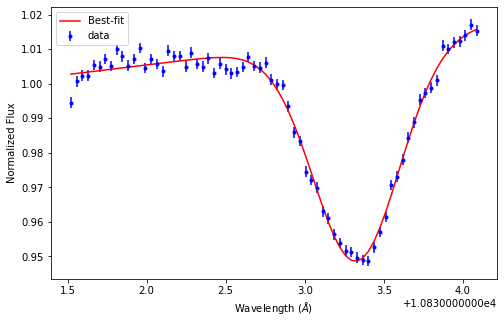

[-6.37753038e-02 -6.09759970e+01  1.08333238e+04  2.73916098e-01
  5.72214598e-03  1.53592793e-02]


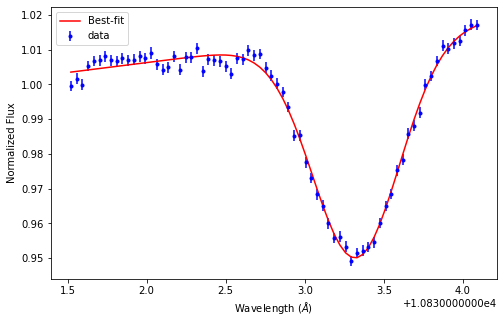

[-6.50779056e-02 -7.66399539e+01  1.08333335e+04  2.80153205e-01
  7.16819061e-03  1.52516366e-02]


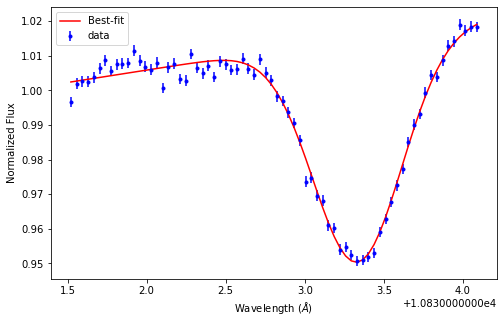

[-6.48320100e-02 -7.24763558e+01  1.08333335e+04  2.90624578e-01
  6.78388765e-03  1.53662519e-02]


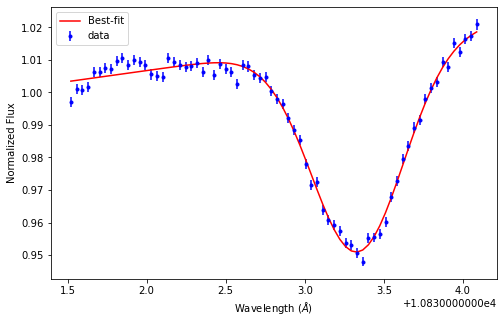

[-6.50568709e-02 -7.42331290e+01  1.08333325e+04  2.90405550e-01
  6.94602523e-03  1.64658983e-02]


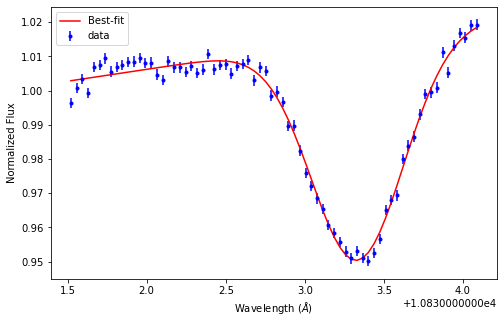

[-6.56209998e-02 -6.84309085e+01  1.08333332e+04  2.77123593e-01
  6.41037884e-03  1.56068921e-02]


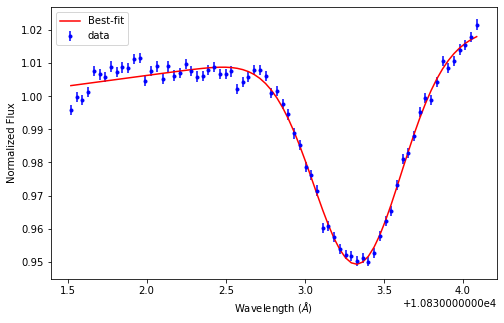

[-6.55037529e-02 -7.60111745e+01  1.08333322e+04  2.82739916e-01
  7.11021694e-03  1.39876363e-02]


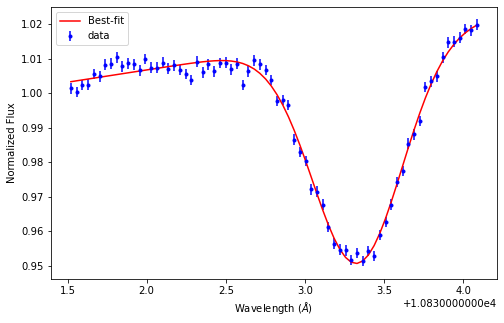

[-6.53531350e-02 -6.46953526e+01  1.08333338e+04  2.79267767e-01
  6.06546862e-03  1.78196896e-02]


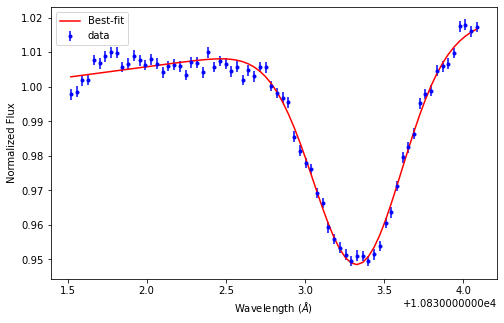

[-6.48834173e-02 -6.49775140e+01  1.08333274e+04  2.74761502e-01
  6.09147959e-03  1.77955400e-02]


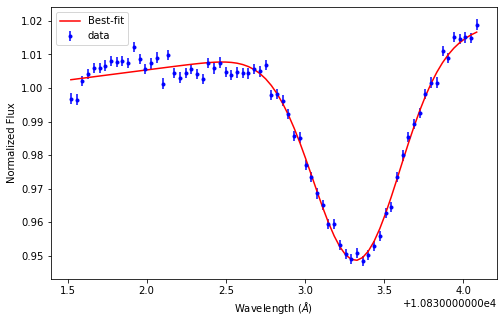

[-6.74003504e-02 -7.93583345e+01  1.08333291e+04  2.91056087e-01
  7.41923975e-03  1.55873448e-02]


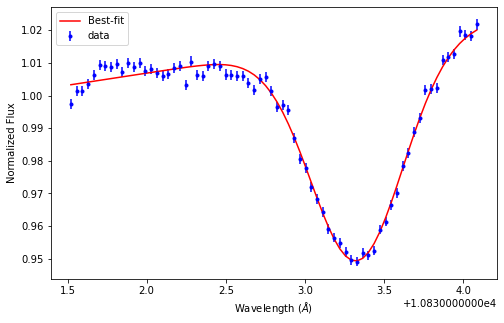

[-6.69558524e-02 -8.34595454e+01  1.08333301e+04  2.89268540e-01
  7.79775671e-03  1.70900452e-02]


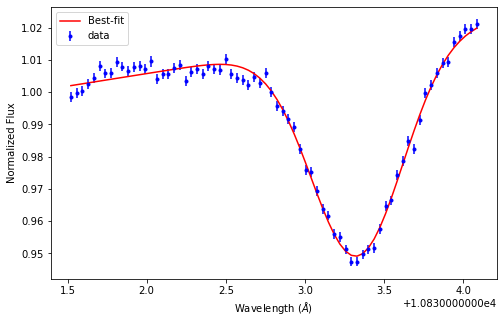

[-6.58928430e-02 -6.84116548e+01  1.08333237e+04  2.83150642e-01
  6.40864848e-03  1.54497469e-02]


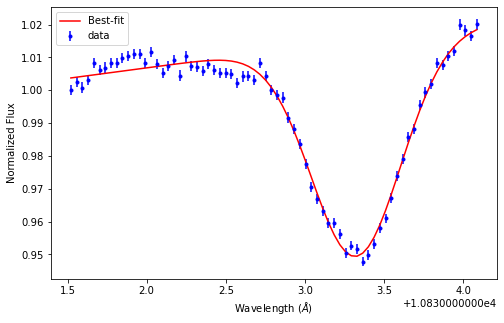

[-6.64109350e-02 -6.95711189e+01  1.08333240e+04  2.84080837e-01
  6.51571685e-03  1.49766097e-02]


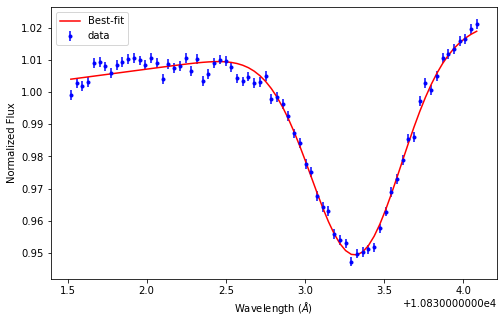

[-6.60045363e-02 -7.28497355e+01  1.08333224e+04  2.88578548e-01
  6.81847872e-03  1.24296578e-02]


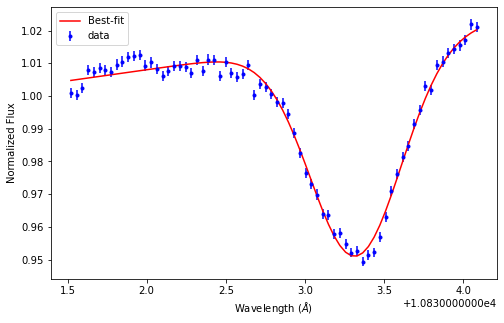

[-6.57933593e-02 -7.00898917e+01  1.08333216e+04  2.87653190e-01
  6.56364105e-03  1.41189873e-02]


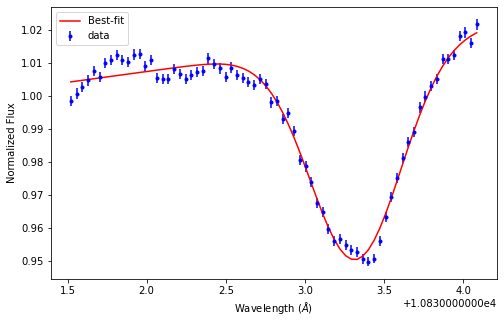

[-6.65086145e-02 -7.54087026e+01  1.08333254e+04  2.88024716e-01
  7.05460120e-03  1.55718687e-02]


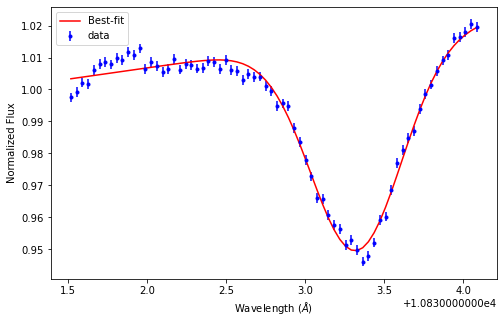

[-6.71617846e-02 -7.21459801e+01  1.08333220e+04  2.86436805e-01
  6.75348503e-03  1.37276773e-02]


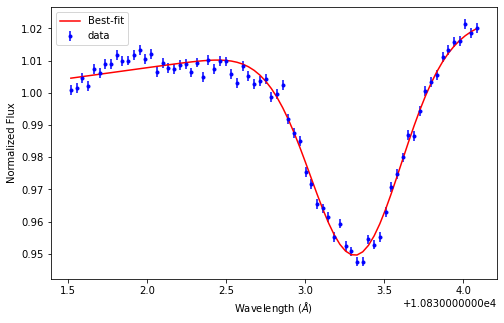

[-6.63658469e-02 -7.21359847e+01  1.08333309e+04  2.79820098e-01
  6.75247365e-03  1.45784873e-02]


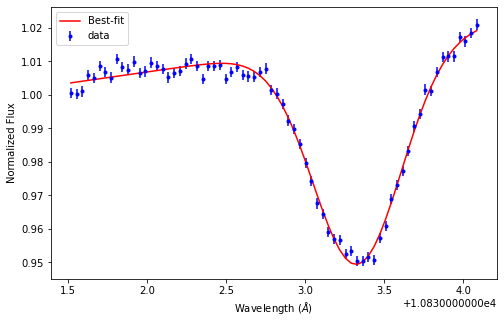

[-6.60985347e-02 -7.51814468e+01  1.08333254e+04  2.90271239e-01
  7.03371435e-03  1.30404784e-02]


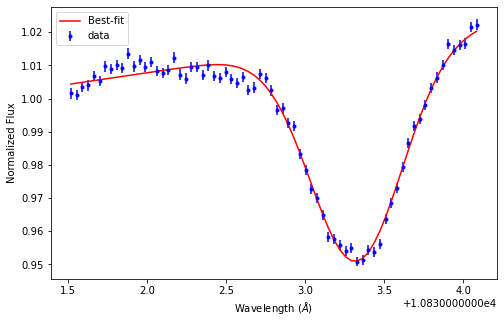

[-6.63266307e-02 -7.62653094e+01  1.08333297e+04  2.88977755e-01
  7.13374587e-03  1.36351073e-02]


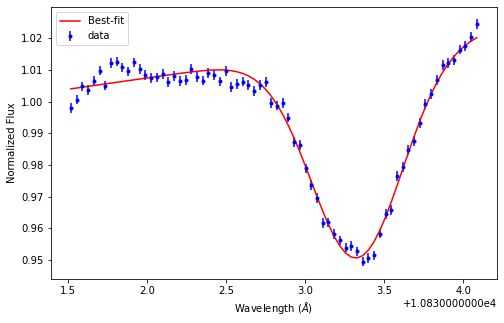

[-6.69464501e-02 -7.69852786e+01  1.08333306e+04  2.86834061e-01
  7.20010689e-03  1.65643331e-02]


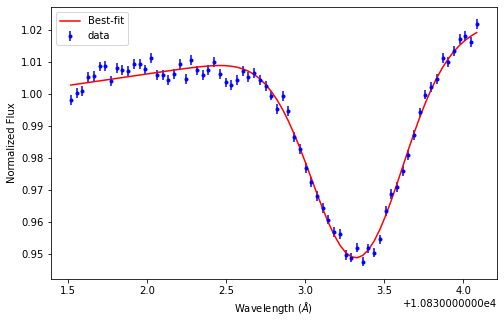

[-6.60196177e-02 -7.31889321e+01  1.08333316e+04  2.83602172e-01
  6.84956986e-03  1.78728673e-02]


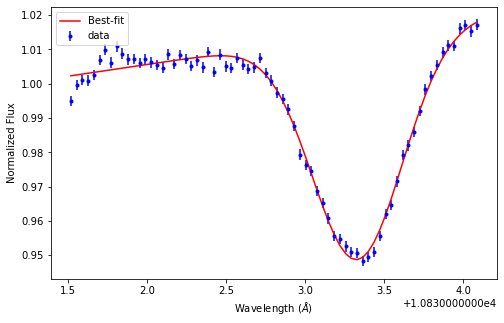

[-6.51952826e-02 -7.71988659e+01  1.08333269e+04  2.90104805e-01
  7.21968199e-03  1.98368594e-02]


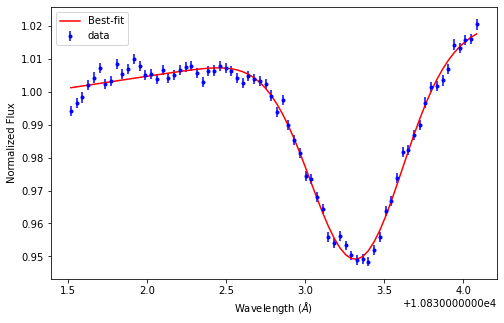

[-6.67943129e-02 -7.05770230e+01  1.08333313e+04  2.82191031e-01
  6.60848534e-03  1.74396552e-02]


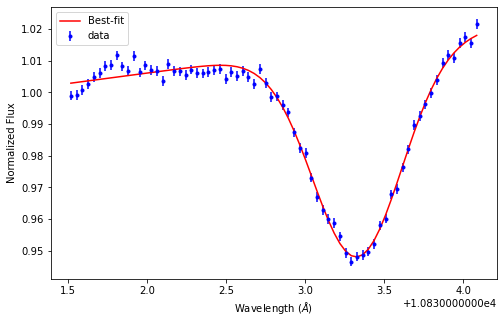

[-6.60191696e-02 -6.49713885e+01  1.08333316e+04  2.78431719e-01
  6.09093492e-03  1.86020501e-02]


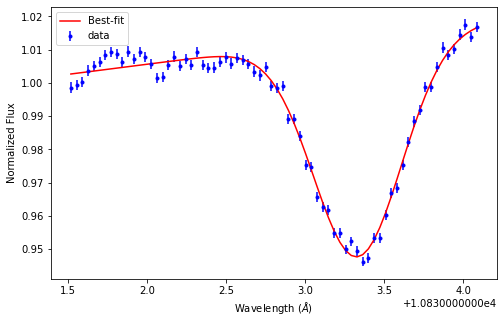

[-6.71444850e-02 -7.56690876e+01  1.08333369e+04  2.74749305e-01
  7.07859374e-03  1.50739449e-02]


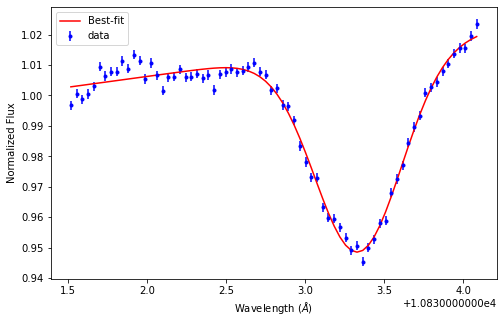

[-6.60449860e-02 -7.14841023e+01  1.08333318e+04  2.80226037e-01
  6.69225345e-03  1.56456914e-02]


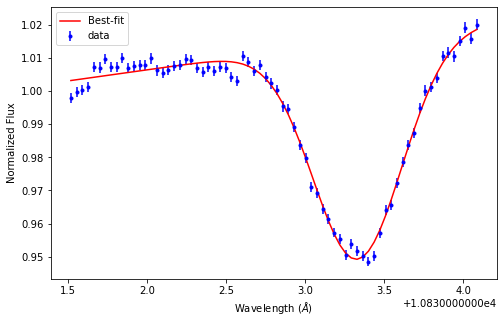

[-6.55897824e-02 -7.22098197e+01  1.08333353e+04  2.83551682e-01
  6.75914680e-03  1.86626570e-02]


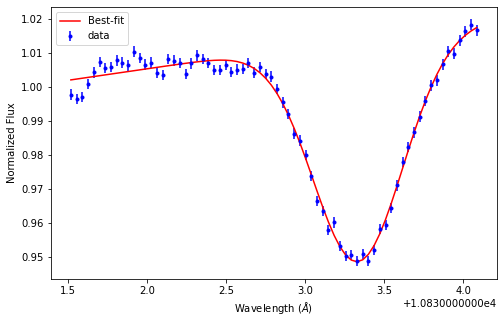

[-6.48699134e-02 -7.71219543e+01  1.08333275e+04  2.85153093e-01
  7.21272102e-03  1.49126061e-02]


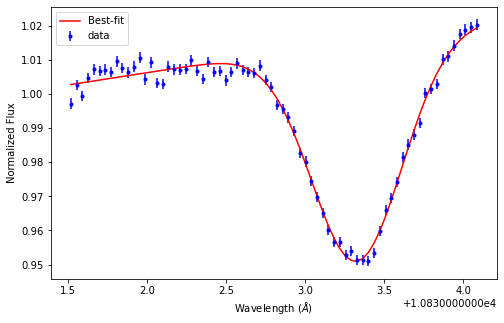

[-6.56151785e-02 -7.51203944e+01  1.08333286e+04  2.84678281e-01
  7.02788088e-03  1.73918359e-02]


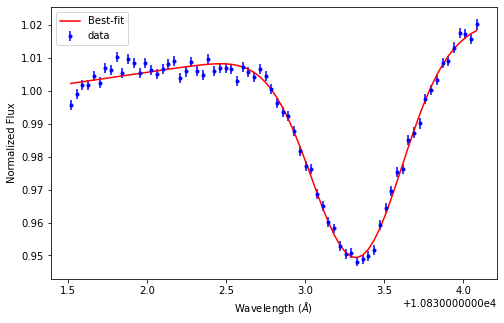

[-6.55823955e-02 -7.02022398e+01  1.08333283e+04  2.83975250e-01
  6.57402682e-03  1.29907337e-02]


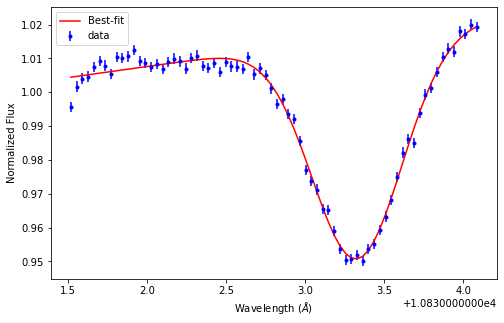

[-6.54899046e-02 -8.21245929e+01  1.08333276e+04  2.89055469e-01
  7.67450777e-03  1.64852051e-02]


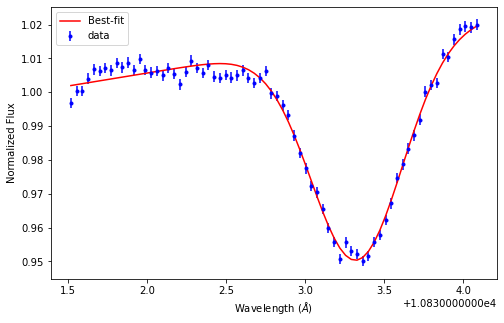

[-6.55764840e-02 -7.25873164e+01  1.08333271e+04  2.79299358e-01
  6.79398352e-03  1.82929560e-02]


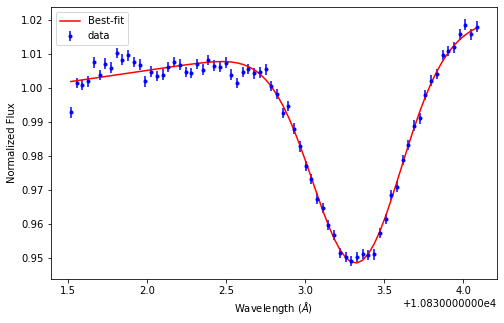

[-6.56689752e-02 -7.46688242e+01  1.08333275e+04  2.95964023e-01
  6.98639208e-03  1.36938522e-02]


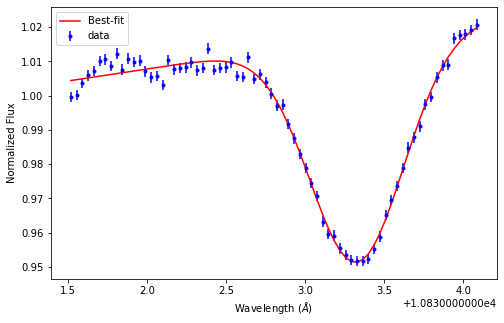

[-6.55740077e-02 -6.91112118e+01  1.08333209e+04  2.88148435e-01
  6.47329439e-03  1.41298651e-02]


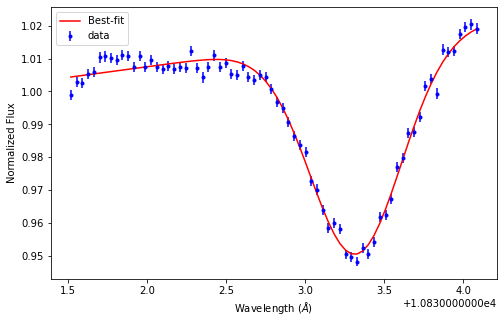

[-6.41407521e-02 -6.59647595e+01  1.08333217e+04  2.89850677e-01
  6.18261494e-03  1.96667205e-02]


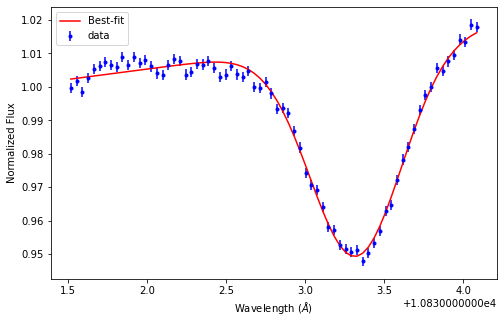

[-6.55506069e-02 -7.75157523e+01  1.08333199e+04  3.03150761e-01
  7.24915735e-03  1.59135212e-02]


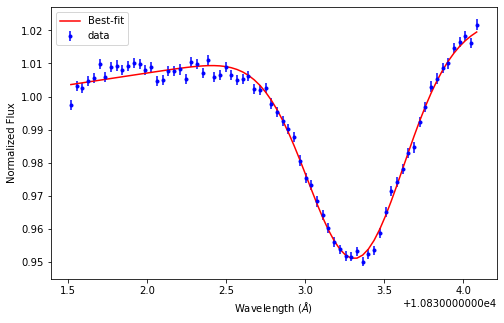

[-6.50719314e-02 -6.85637691e+01  1.08333157e+04  2.90599073e-01
  6.42270705e-03  1.56201061e-02]


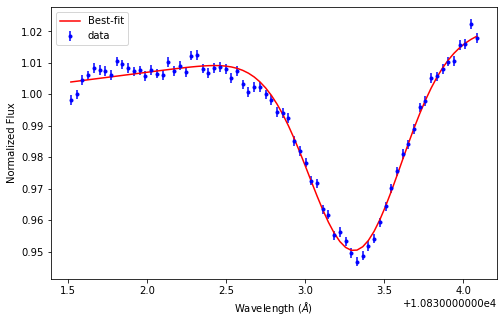

[-6.57045535e-02 -8.02798994e+01  1.08333170e+04  2.98072968e-01
  7.50432148e-03  1.52193995e-02]


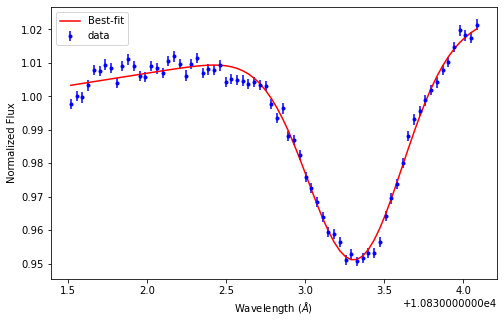

[-6.57656744e-02 -7.67351241e+01  1.08333218e+04  3.01451197e-01
  7.17698684e-03  1.88538885e-02]


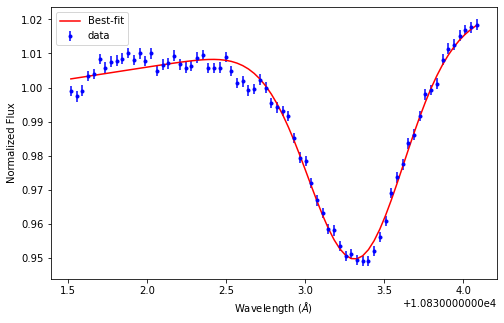

[-6.71976587e-02 -8.25195498e+01  1.08333157e+04  3.02892833e-01
  7.71110856e-03  1.59826318e-02]


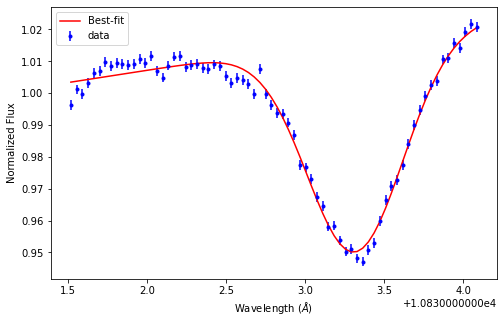

[-6.68241767e-02 -7.95649982e+01  1.08333137e+04  3.10749991e-01
  7.43843099e-03  1.51774857e-02]


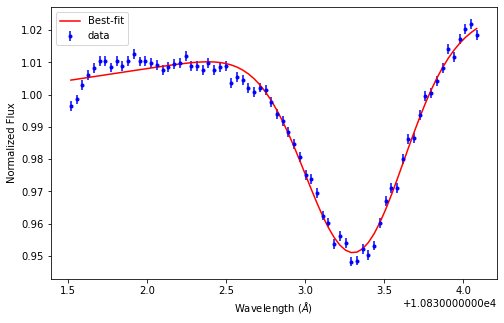

[-6.58784653e-02 -6.67522838e+01  1.08333132e+04  2.91610199e-01
  6.25543013e-03  1.78963286e-02]


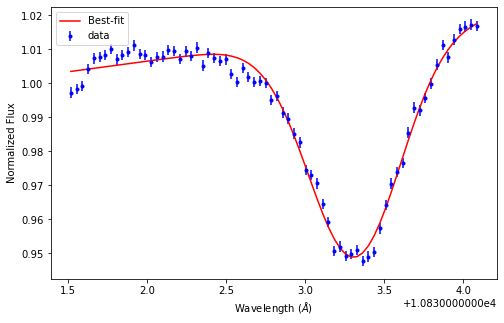

[-6.66832119e-02 -8.18259021e+01  1.08333170e+04  2.99163149e-01
  7.64715816e-03  1.26761055e-02]


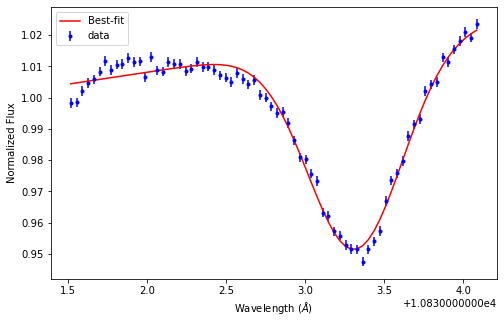

[-6.68293494e-02 -8.12411295e+01  1.08333143e+04  3.04330573e-01
  7.59320586e-03  1.28079400e-02]


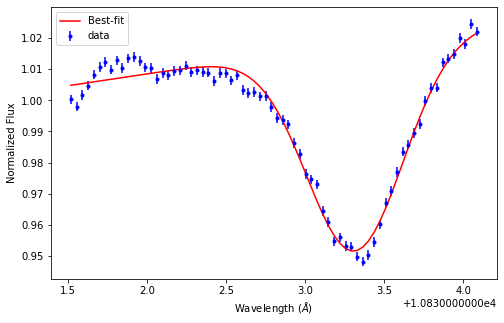

[-6.58050946e-02 -7.04472085e+01  1.08333138e+04  2.89523090e-01
  6.59670875e-03  1.21051603e-02]


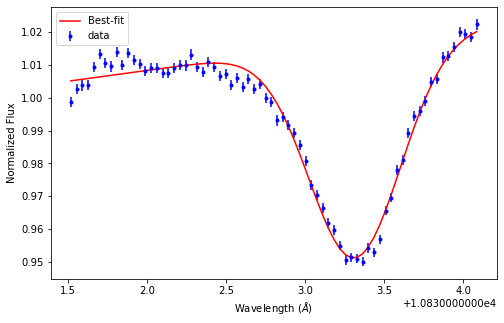

[-6.63955951e-02 -7.02742273e+01  1.08333196e+04  2.86008438e-01
  6.58058507e-03  1.63520444e-02]


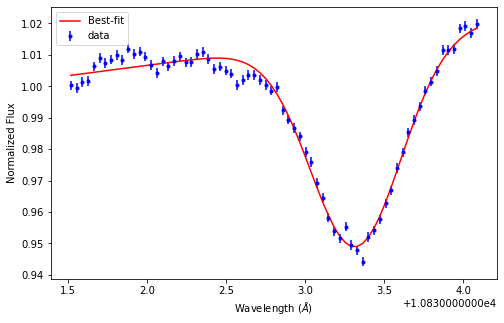

[-6.55606210e-02 -7.49186968e+01  1.08333124e+04  2.92100797e-01
  7.00930137e-03  1.74326828e-02]


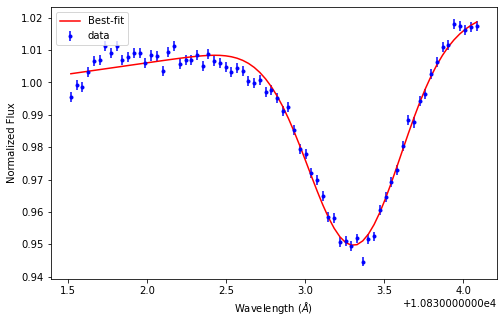

[-6.63150538e-02 -7.52398894e+01  1.08333282e+04  2.84512141e-01
  7.03879532e-03  2.11412213e-02]


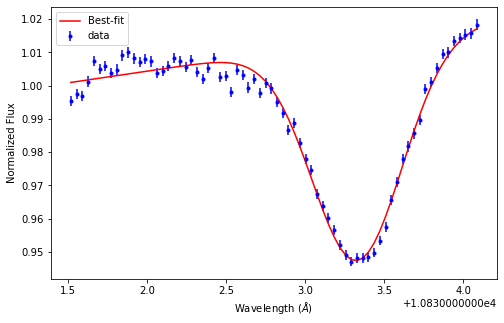

[-6.58796554e-02 -7.53770124e+01  1.08333272e+04  2.82007897e-01
  7.05168529e-03  1.38968486e-02]


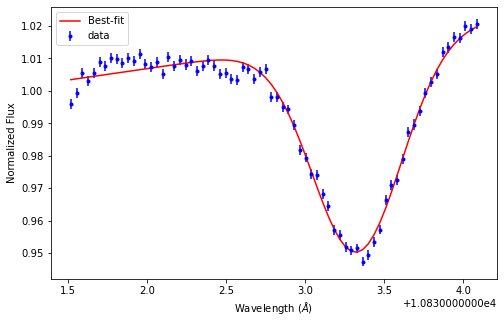

[-6.52345216e-02 -7.05357907e+01  1.08333274e+04  2.85655365e-01
  6.60472426e-03  1.56207358e-02]


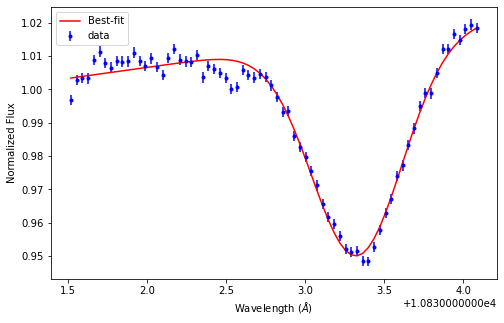

[-6.39089854e-02 -6.96993332e+01  1.08333288e+04  2.83464919e-01
  6.52748333e-03  1.50835927e-02]


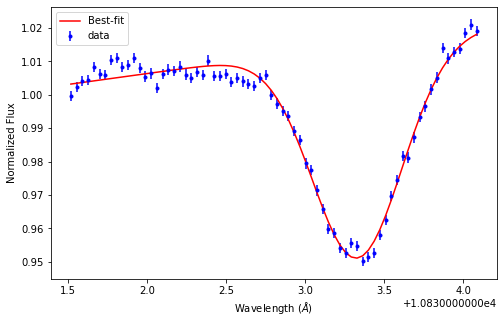

[-6.47044728e-02 -6.69416105e+01  1.08333248e+04  2.80661865e-01
  6.27274927e-03  1.97813593e-02]


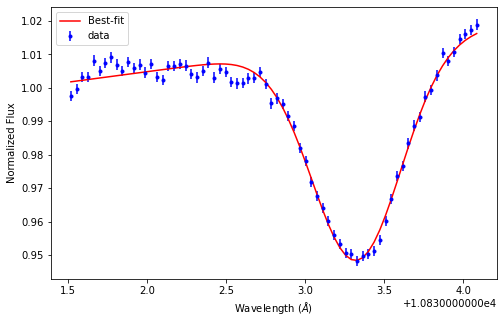

[-6.48329042e-02 -7.82318344e+01  1.08333209e+04  2.89399239e-01
  7.31489381e-03  2.35218892e-02]


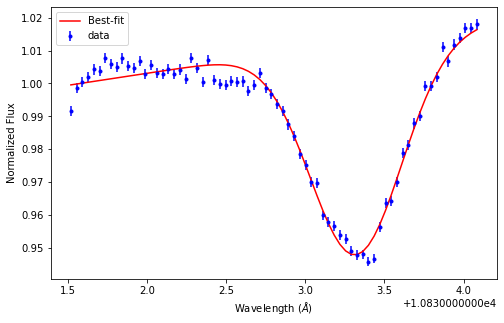

[-6.51374620e-02 -7.70986238e+01  1.08333238e+04  2.89792201e-01
  7.21049581e-03  1.78669977e-02]


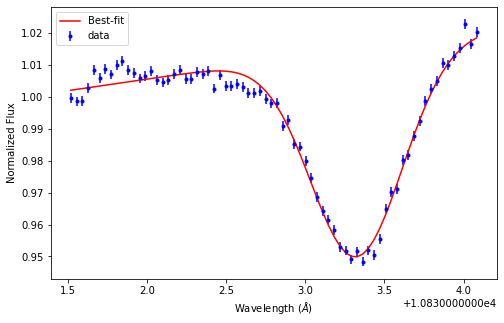

[-6.49214972e-02 -7.67504735e+01  1.08333224e+04  2.89983052e-01
  7.17843457e-03  1.55598949e-02]


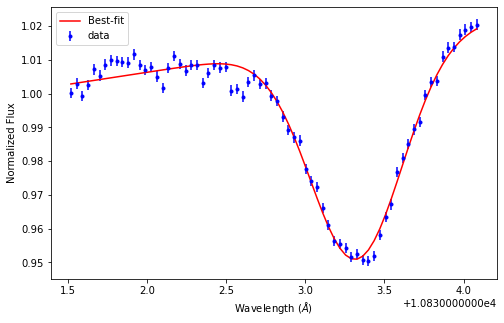

[-6.55831514e-02 -7.68229044e+01  1.08333180e+04  2.88160657e-01
  7.18499477e-03  1.93078009e-02]


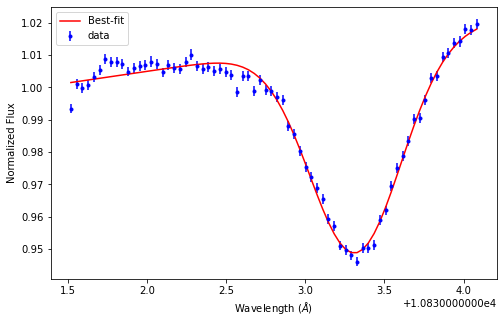

[-6.49054135e-02 -6.75659718e+01  1.08333244e+04  2.80989847e-01
  6.33045009e-03  1.81668525e-02]


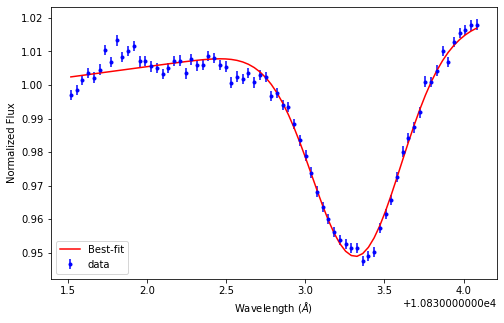

[-6.58798747e-02 -6.55416065e+01  1.08333199e+04  2.74021039e-01
  6.14368022e-03  1.47926803e-02]


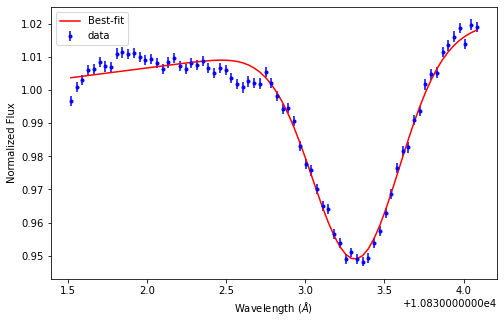

[-6.46204582e-02 -6.87435417e+01  1.08333118e+04  2.89498106e-01
  6.43917473e-03  1.87330720e-02]


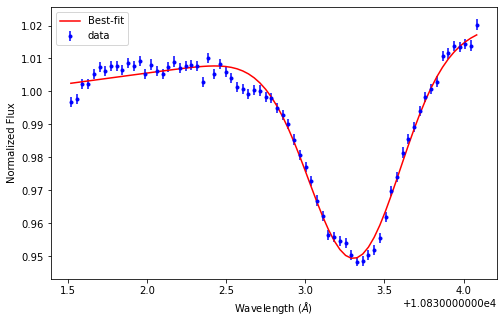

[-6.62788877e-02 -8.03948471e+01  1.08333127e+04  2.95675066e-01
  7.51496224e-03  1.44583624e-02]


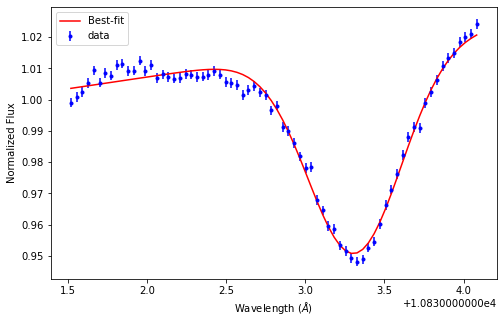

[-6.59064994e-02 -7.32302709e+01  1.08333029e+04  2.87203567e-01
  6.85346577e-03  1.61620525e-02]


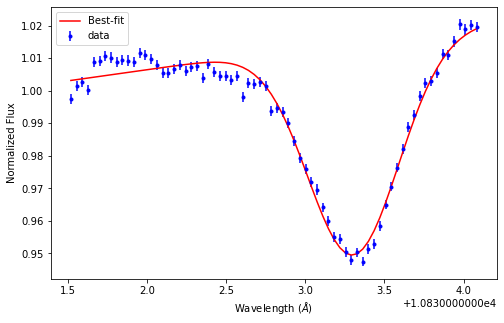

[-6.47078421e-02 -6.89653398e+01  1.08333095e+04  2.84415981e-01
  6.45962389e-03  1.87187283e-02]


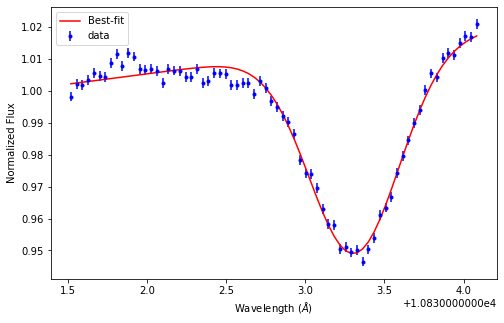

[-6.43438422e-02 -7.53249220e+01  1.08333026e+04  3.04885363e-01
  7.04686131e-03  1.68745456e-02]


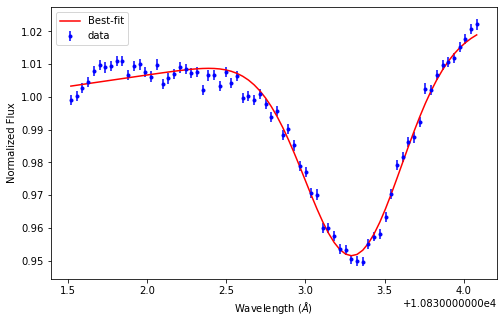

[-6.60811036e-02 -6.84835490e+01  1.08333083e+04  2.92395779e-01
  6.41532069e-03  1.61342653e-02]


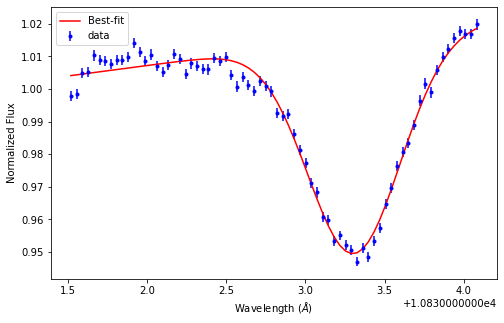

[-6.55636118e-02 -6.64194267e+01  1.08333091e+04  2.92466459e-01
  6.22478037e-03  1.56694733e-02]


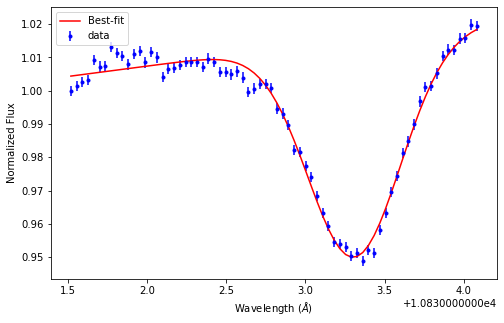

[-6.60520390e-02 -7.78446536e+01  1.08333110e+04  3.00834763e-01
  7.27947541e-03  1.71686769e-02]


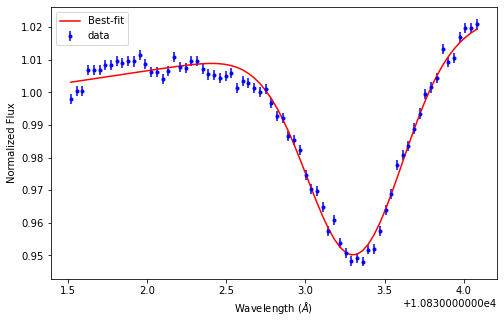

[-6.56792907e-02 -8.00753236e+01  1.08333080e+04  3.05869307e-01
  7.48540652e-03  1.73233071e-02]


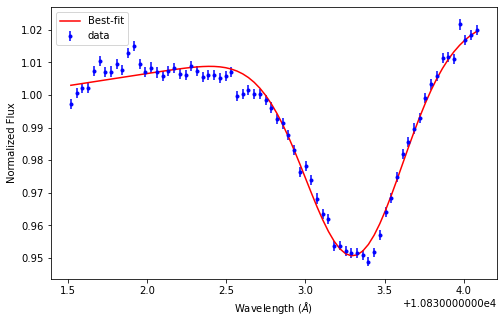

[-6.52275025e-02 -7.33765330e+01  1.08333109e+04  2.92721678e-01
  6.86700791e-03  1.54064663e-02]


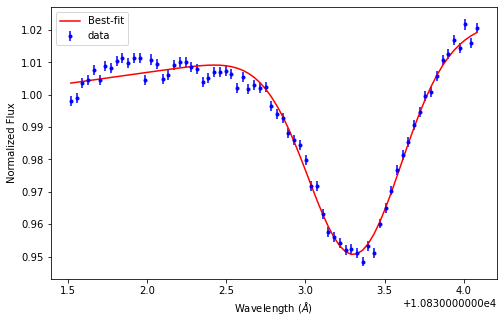

[-6.43703558e-02 -6.68193026e+01  1.08333184e+04  2.77409481e-01
  6.26154033e-03  1.67532017e-02]


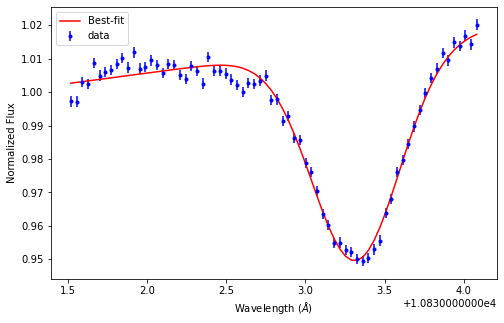

[-6.43886775e-02 -7.17806211e+01  1.08333255e+04  2.79856124e-01
  6.71961754e-03  1.47051854e-02]


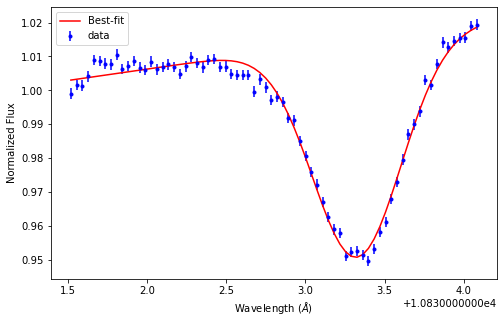

[-6.55124735e-02 -6.72090477e+01  1.08333289e+04  2.79121370e-01
  6.29746000e-03  1.94558288e-02]


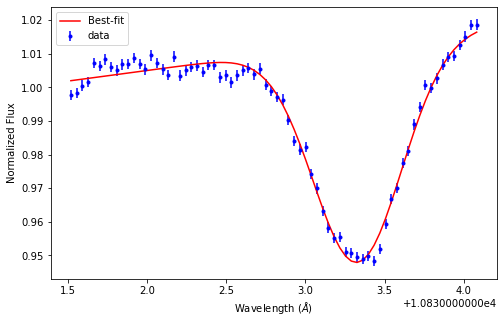

[-6.55182563e-02 -5.48446474e+01  1.08333283e+04  2.69920482e-01
  5.15624293e-03  1.32496446e-02]


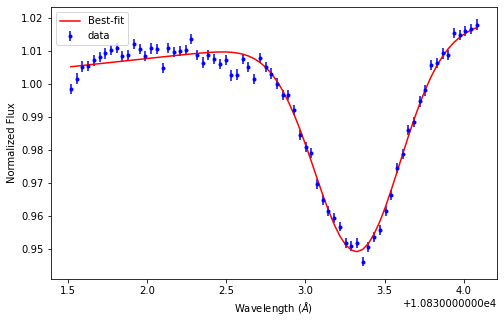

[-6.64826016e-02 -6.64106778e+01  1.08333320e+04  2.79844202e-01
  6.22388765e-03  1.66782205e-02]


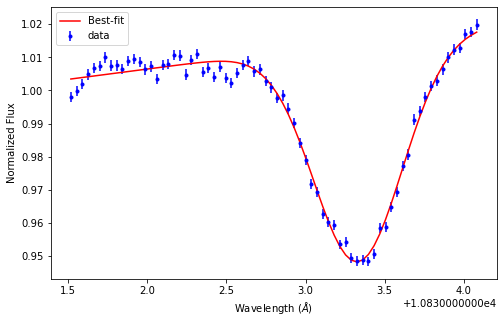

[-6.72846913e-02 -7.36528226e+01  1.08333361e+04  2.80847096e-01
  6.89257856e-03  1.31179190e-02]


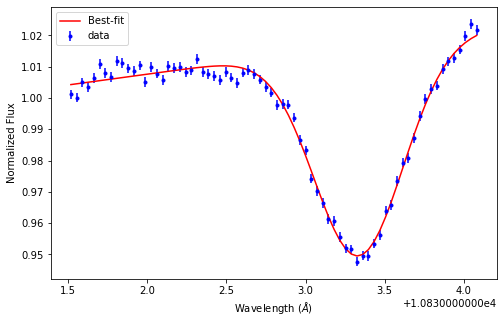

[-6.73541324e-02 -6.82062044e+01  1.08333380e+04  2.73754636e-01
  6.38948000e-03  2.06908551e-02]


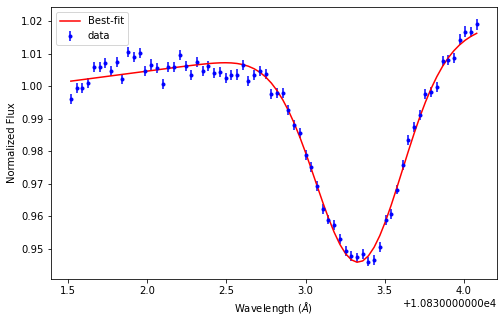

[-6.50292213e-02 -6.44602667e+01  1.08333284e+04  2.76350559e-01
  6.04378348e-03  1.67350480e-02]


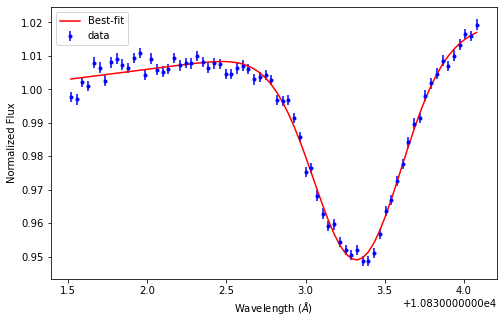

[-6.54827283e-02 -6.10785760e+01  1.08333261e+04  2.71282114e-01
  5.73169348e-03  1.39633763e-02]


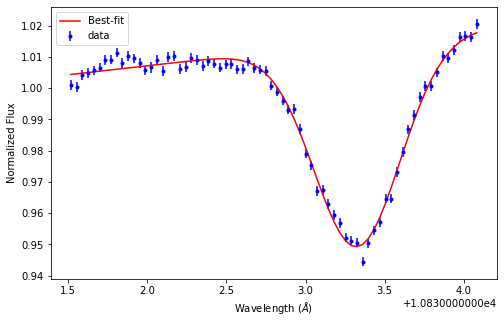

[-6.63883841e-02 -6.90728328e+01  1.08333264e+04  2.78516626e-01
  6.46959922e-03  1.74949770e-02]


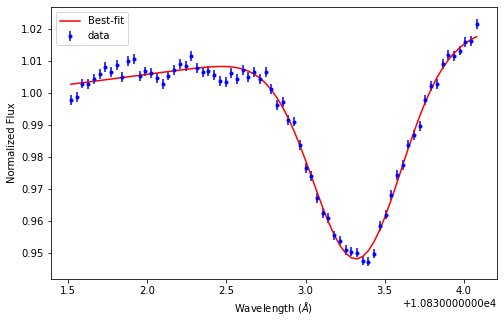

[-6.52250778e-02 -6.49237114e+01  1.08333308e+04  2.70917854e-01
  6.08665730e-03  1.34200937e-02]


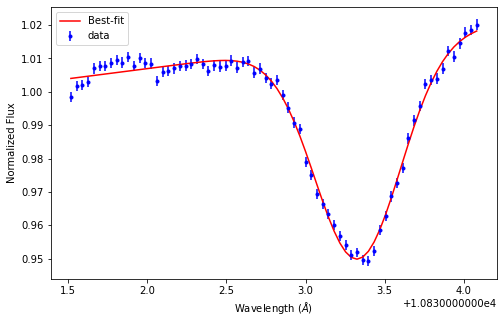

[-6.61204596e-02 -7.17166963e+01  1.08333269e+04  2.73739572e-01
  6.71365295e-03  1.67422769e-02]


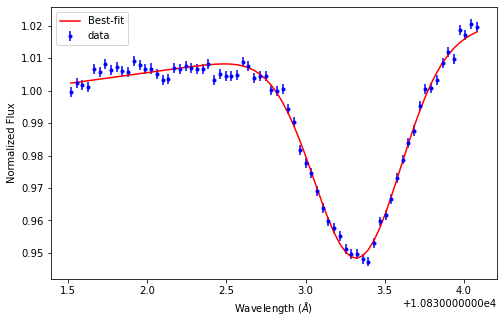

[-6.46773746e-02 -6.13408617e+01  1.08333302e+04  2.65654797e-01
  5.75580691e-03  1.52963740e-02]


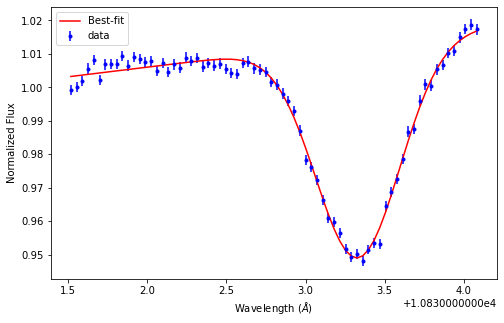

[-6.56630223e-02 -7.19484073e+01  1.08333325e+04  2.74416654e-01
  6.73508154e-03  1.54305297e-02]


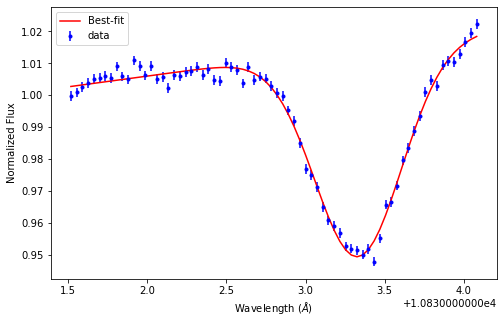

[-6.45838928e-02 -6.16621153e+01  1.08333251e+04  2.72232694e-01
  5.78555127e-03  1.37835186e-02]


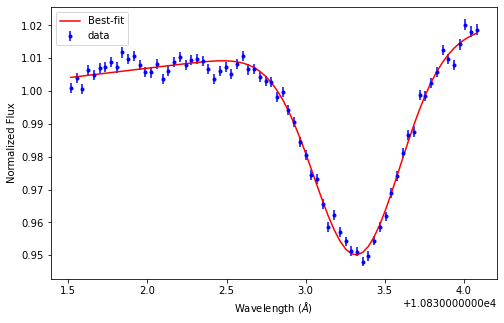

[-6.47743960e-02 -7.20775821e+01  1.08333287e+04  2.75461484e-01
  6.74686661e-03  1.89407926e-02]


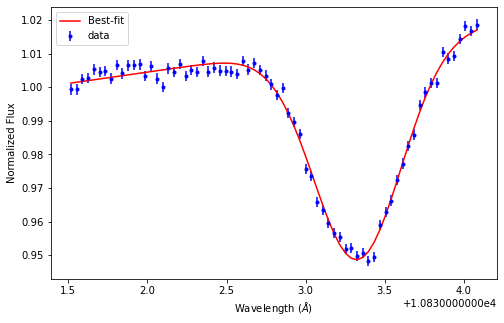

[-6.58797459e-02 -7.00090548e+01  1.08333277e+04  2.67851338e-01
  6.55597915e-03  1.66851234e-02]


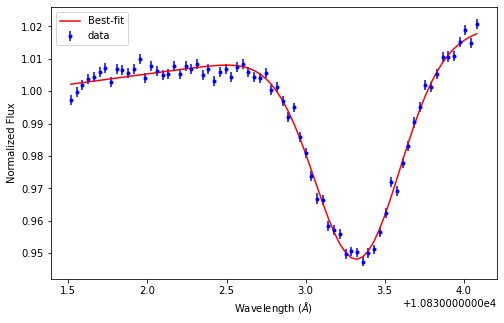

[-6.57306638e-02 -7.76522025e+01  1.08333302e+04  2.78200237e-01
  7.26148324e-03  1.97210084e-02]


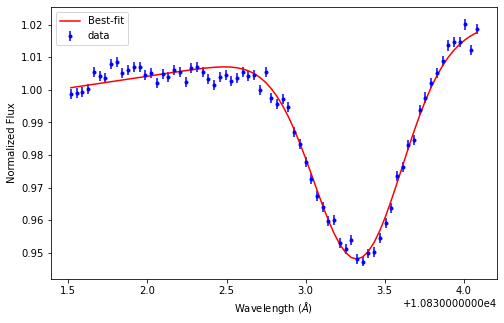

[-6.51426099e-02 -7.05268093e+01  1.08333293e+04  2.75377489e-01
  6.60385074e-03  1.52380755e-02]


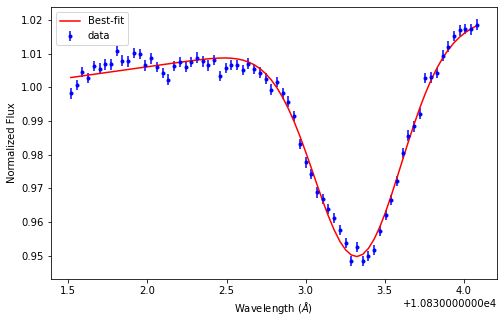

[-6.52673137e-02 -6.23311478e+01  1.08333247e+04  2.65925679e-01
  5.84716897e-03  1.72520414e-02]


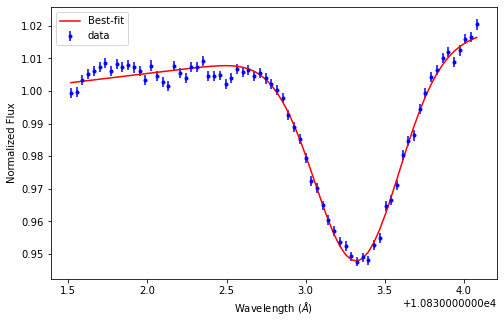

[-6.50354729e-02 -6.69291214e+01  1.08333270e+04  2.72628919e-01
  6.27165918e-03  1.70170186e-02]


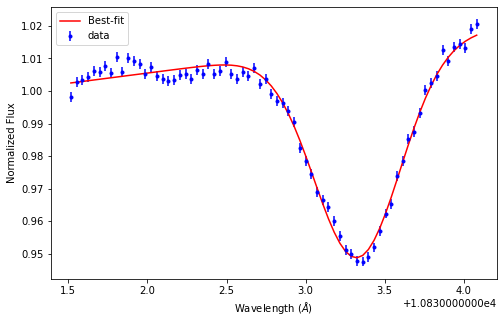

[-6.53365356e-02 -7.00786072e+01  1.08333306e+04  2.72408540e-01
  6.56240625e-03  1.68663741e-02]


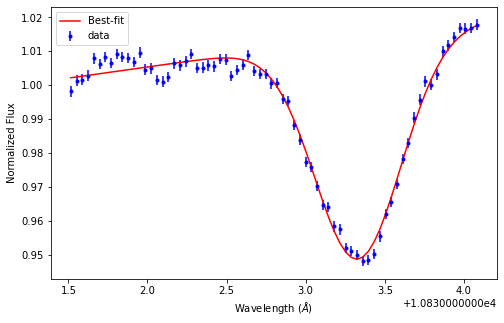

[-6.51754095e-02 -6.16081946e+01  1.08333254e+04  2.72339283e-01
  5.78053087e-03  1.54065872e-02]


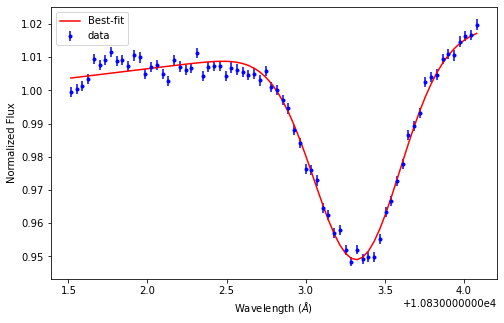

[-6.56640304e-02 -6.19661354e+01  1.08333259e+04  2.66605185e-01
  5.81342918e-03  1.88700664e-02]


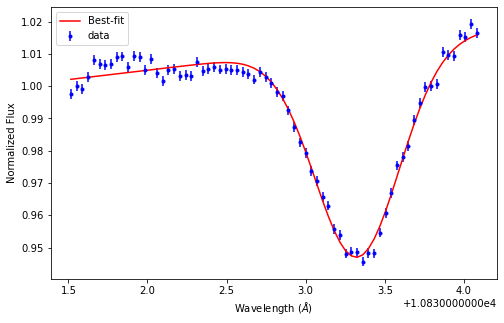

[-6.53145665e-02 -6.64077286e+01  1.08333305e+04  2.68441710e-01
  6.22357843e-03  1.51142456e-02]


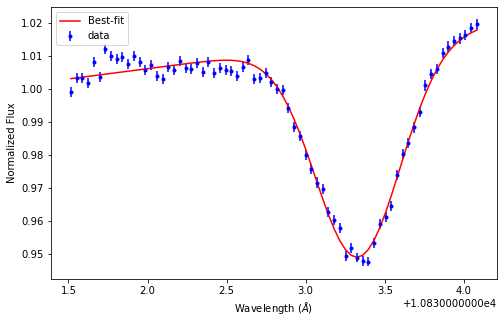

[-6.67685470e-02 -7.43922831e+01  1.08333284e+04  2.75545686e-01
  6.96068030e-03  1.64233067e-02]


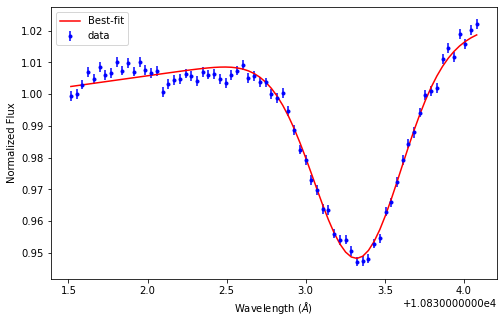

[-6.52991600e-02 -6.41975132e+01  1.08333309e+04  2.67960032e-01
  6.01959089e-03  1.38210370e-02]


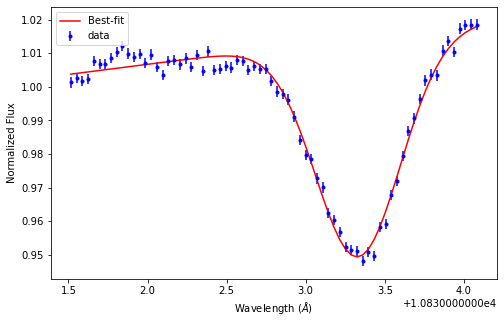

[-6.60606296e-02 -7.39185920e+01  1.08333320e+04  2.78844576e-01
  6.91699685e-03  1.52216336e-02]


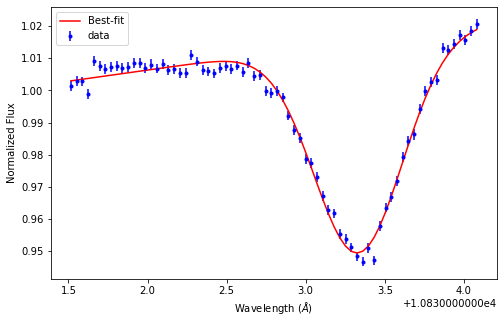

[-6.65524623e-02 -7.37979508e+01  1.08333325e+04  2.73679184e-01
  6.90592270e-03  1.29301573e-02]


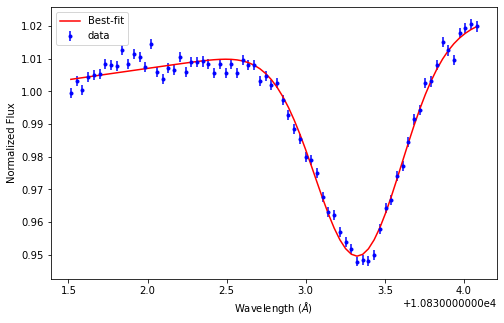

[-6.62912393e-02 -7.06353054e+01  1.08333302e+04  2.74610692e-01
  6.61372347e-03  1.99256627e-02]


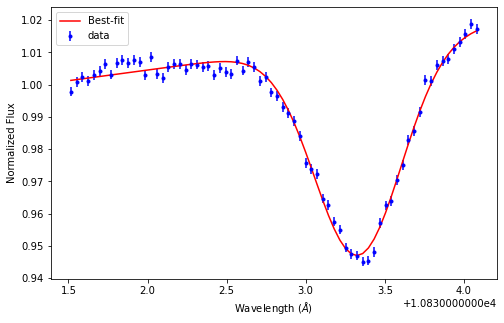

[-6.64669977e-02 -6.98194408e+01  1.08333334e+04  2.72719950e-01
  6.53845609e-03  1.84242214e-02]


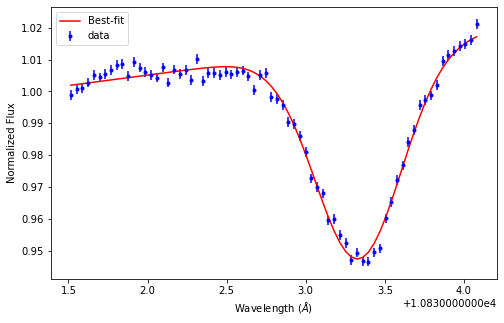

[-6.62586689e-02 -7.09837879e+01  1.08333307e+04  2.72146020e-01
  6.64597535e-03  1.71869298e-02]


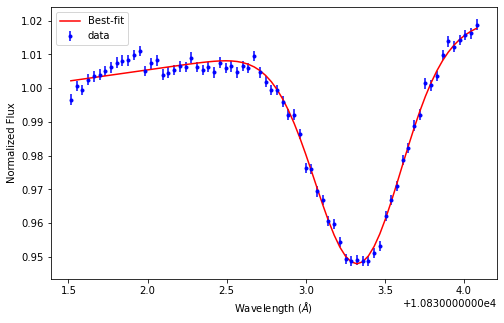

[-6.51528747e-02 -6.83376758e+01  1.08333340e+04  2.67438377e-01
  6.40169860e-03  1.58927734e-02]


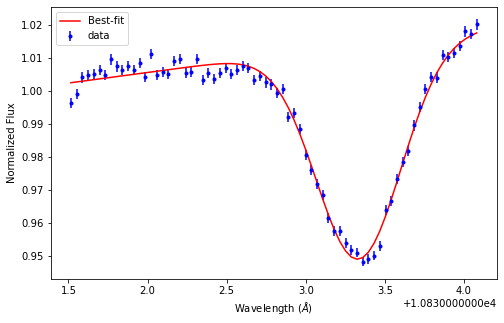

[-6.65557384e-02 -7.89094119e+01  1.08333395e+04  2.74162926e-01
  7.37769221e-03  1.53381605e-02]


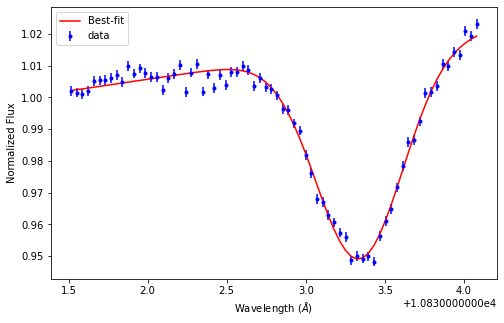

[-6.54728227e-02 -7.46529952e+01  1.08333294e+04  2.84169088e-01
  6.98466850e-03  1.91266317e-02]


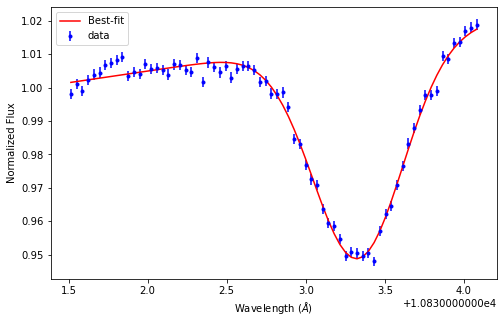

[-6.62173392e-02 -7.41560887e+01  1.08333301e+04  2.76918030e-01
  6.93885301e-03  1.69211044e-02]


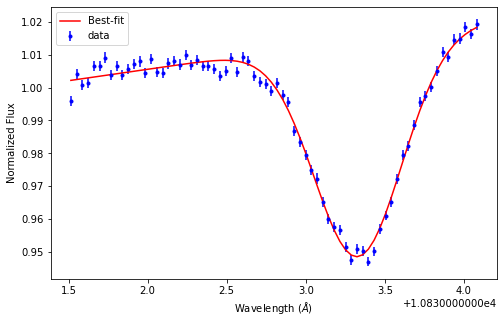

[-6.58815634e-02 -6.80007459e+01  1.08333245e+04  2.73254421e-01
  6.37062049e-03  1.66377364e-02]


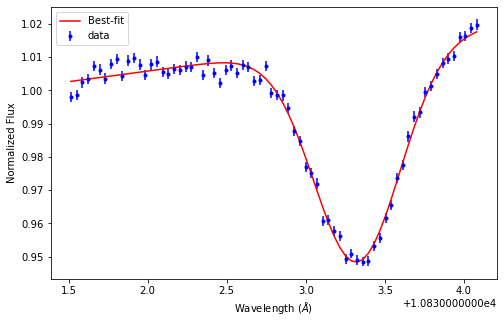

[-6.63353239e-02 -6.88661289e+01  1.08333279e+04  2.71801946e-01
  6.45056005e-03  1.52043652e-02]


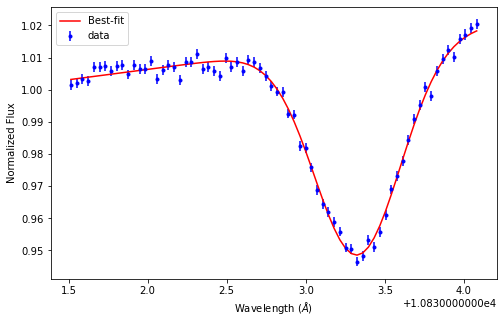

[-6.60682079e-02 -6.81380191e+01  1.08333308e+04  2.73468880e-01
  6.38318138e-03  1.99367188e-02]


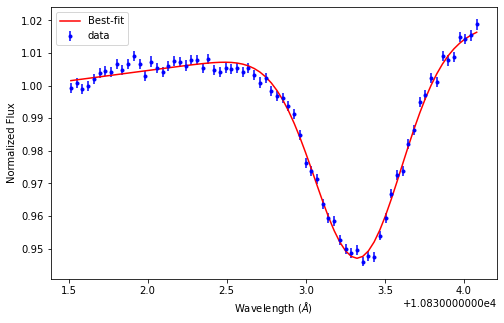

[-6.65972691e-02 -7.86655808e+01  1.08333288e+04  2.81196834e-01
  7.35522700e-03  1.52860624e-02]


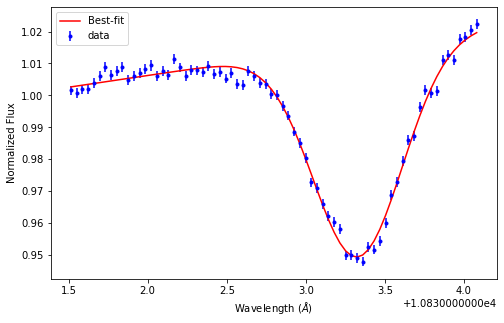

[-6.58051586e-02 -7.07885718e+01  1.08333300e+04  2.80945876e-01
  6.62800971e-03  1.67489064e-02]


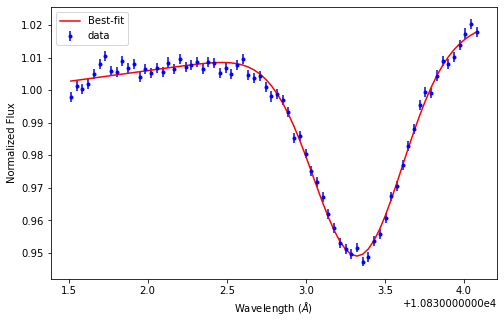

[-6.61367515e-02 -7.05925929e+01  1.08333289e+04  2.69743853e-01
  6.60980692e-03  1.83174808e-02]


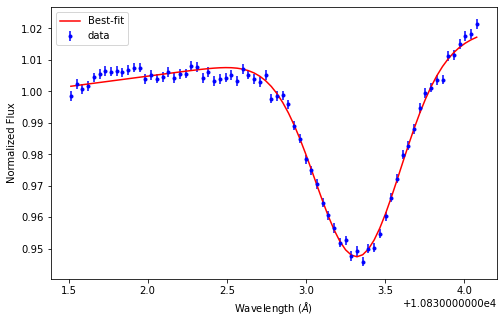

[-6.64810300e-02 -7.10611941e+01  1.08333343e+04  2.71306648e-01
  6.65317341e-03  1.57276671e-02]


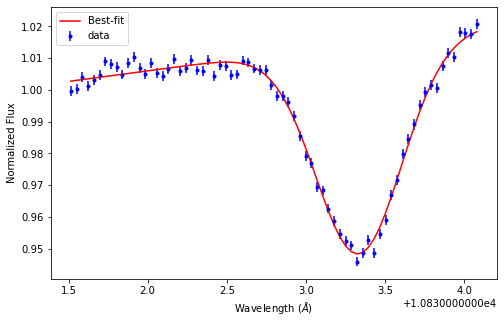

[-6.58383958e-02 -7.82624907e+01  1.08333379e+04  2.73982807e-01
  7.31787416e-03  1.76114205e-02]


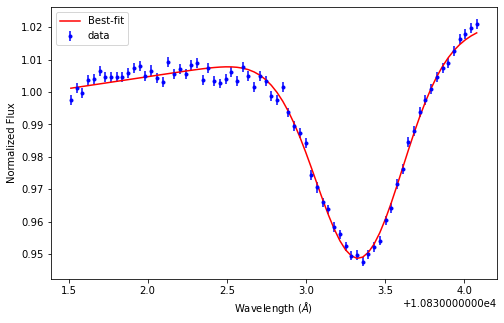

[-6.54661244e-02 -7.00152848e+01  1.08333312e+04  2.72998977e-01
  6.55663680e-03  1.49252888e-02]


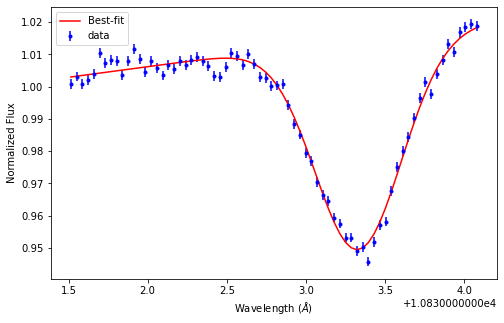

[-6.71778053e-02 -7.12230394e+01  1.08333304e+04  2.69612009e-01
  6.66814619e-03  1.50177315e-02]


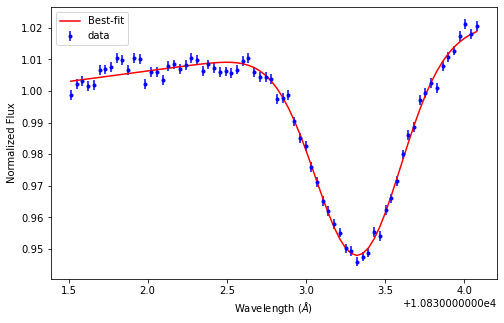

[-6.63770263e-02 -7.64662724e+01  1.08333328e+04  2.73881211e-01
  7.15222213e-03  1.34405518e-02]


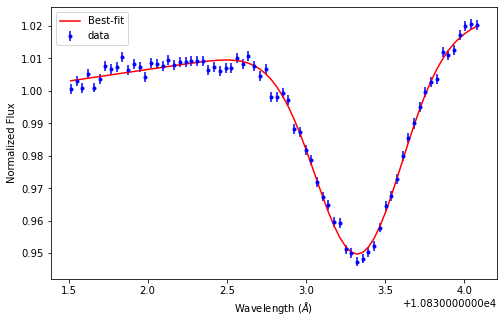

[-6.56566135e-02 -6.79721479e+01  1.08333327e+04  2.75655000e-01
  6.36800720e-03  1.61303117e-02]


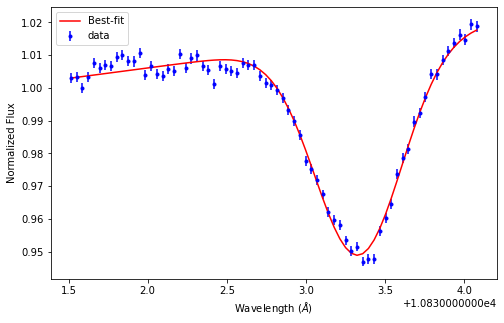

[-6.57690658e-02 -6.11102851e+01  1.08333273e+04  2.81118036e-01
  5.73455128e-03  1.77296933e-02]


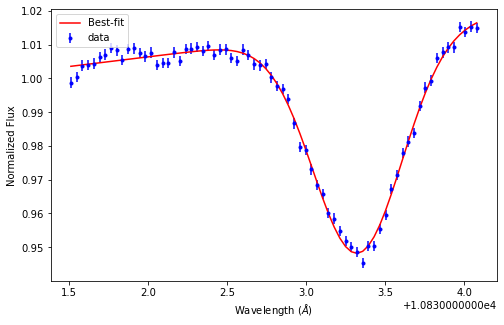

[-6.65394988e-02 -5.99971890e+01  1.08333247e+04  2.75525147e-01
  5.63181354e-03  1.69496688e-02]


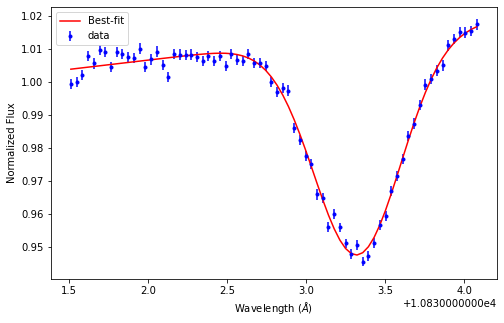

[-6.55221732e-02 -6.19246513e+01  1.08333276e+04  2.77088445e-01
  5.80983705e-03  1.38099139e-02]


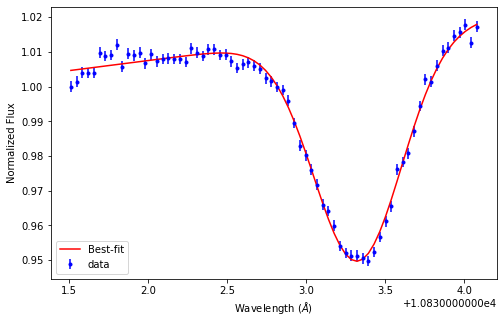

[-6.62207661e-02 -6.55980589e+01  1.08333285e+04  2.73938242e-01
  6.14891860e-03  1.43101549e-02]


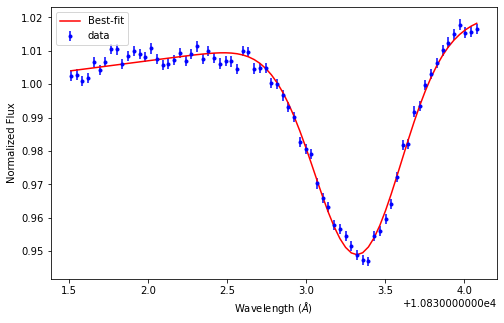

[-6.50715461e-02 -6.32166312e+01  1.08333325e+04  2.74074736e-01
  5.92904321e-03  1.46997046e-02]


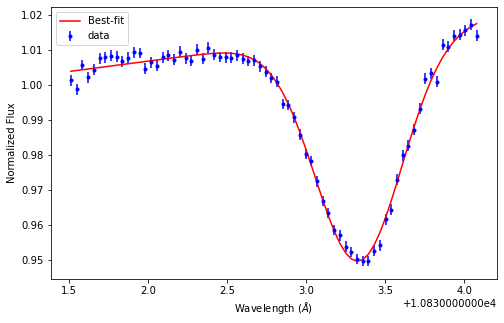

[-6.59835043e-02 -7.12482682e+01  1.08333328e+04  2.73152400e-01
  6.67034377e-03  1.85000598e-02]


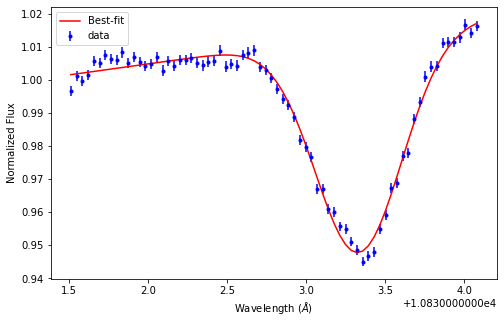

[-6.67290496e-02 -7.64032797e+01  1.08333353e+04  2.80308290e-01
  7.14632812e-03  1.69590289e-02]


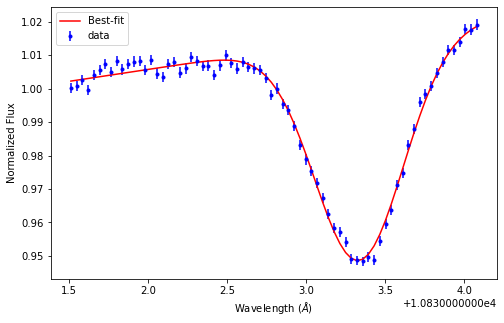

[-6.50025757e-02 -7.18549413e+01  1.08333301e+04  2.78496804e-01
  6.72628876e-03  2.03071928e-02]


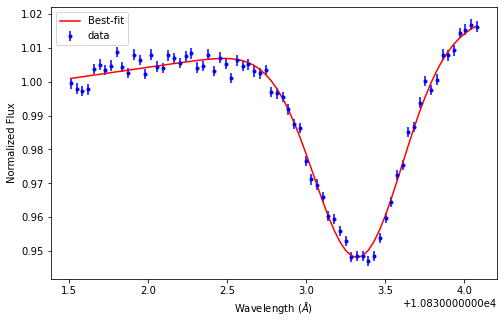

[-6.56804680e-02 -8.43811732e+01  1.08333343e+04  2.80600203e-01
  7.88274725e-03  1.73548455e-02]


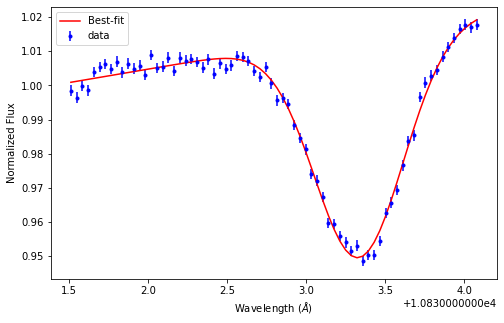

[-6.46474939e-02 -7.69572493e+01  1.08333319e+04  2.76911283e-01
  7.19740018e-03  1.68498050e-02]


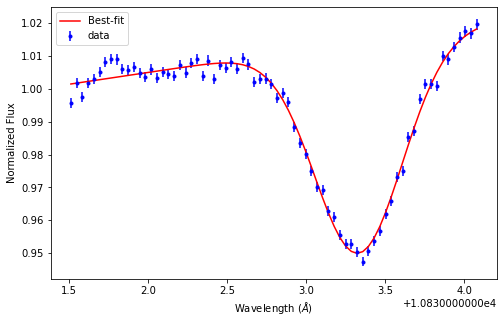

[-6.58892217e-02 -6.95891042e+01  1.08333373e+04  2.66816485e-01
  6.51726866e-03  1.49835674e-02]


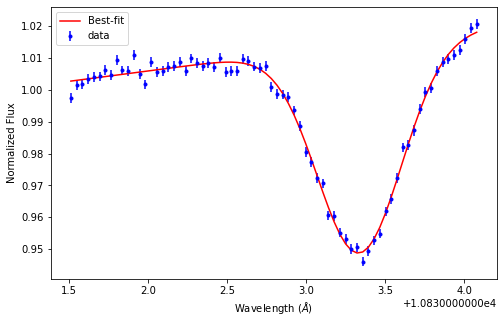

[-6.63949183e-02 -7.54953593e+01  1.08333363e+04  2.81909308e-01
  7.06259242e-03  1.48336955e-02]


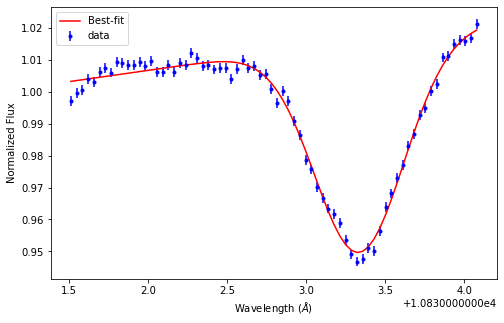

[-6.50091317e-02 -7.20167085e+01  1.08333368e+04  2.74444426e-01
  6.74127182e-03  1.82732269e-02]


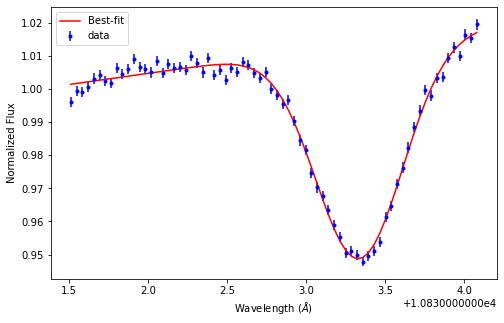

[-6.69684435e-02 -7.66007657e+01  1.08333289e+04  2.75458871e-01
  7.16464842e-03  1.38345435e-02]


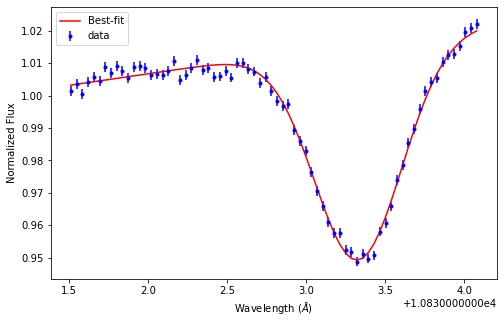

[-6.70340033e-02 -7.57494951e+01  1.08333337e+04  2.83494570e-01
  7.08612673e-03  1.34513021e-02]


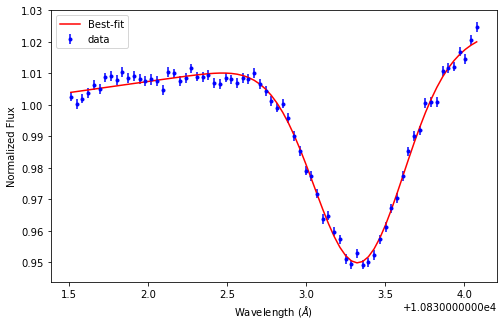

[-6.51239228e-02 -7.30050211e+01  1.08333292e+04  2.78139144e-01
  6.83262278e-03  1.56409807e-02]


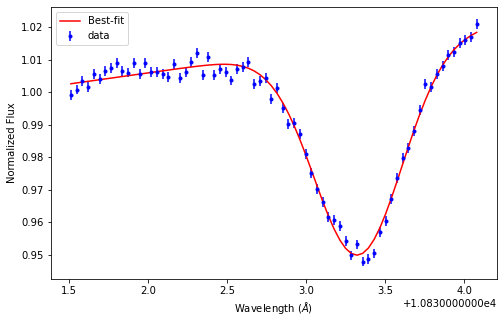

[-6.68570291e-02 -7.17504389e+01  1.08333242e+04  2.82695685e-01
  6.71682489e-03  1.71684578e-02]


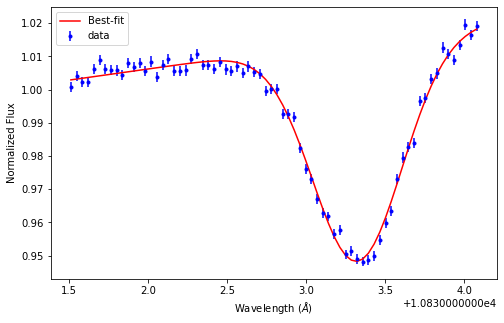

[-6.65856529e-02 -7.32704314e+01  1.08333358e+04  2.76996292e-01
  6.85712429e-03  1.64305357e-02]


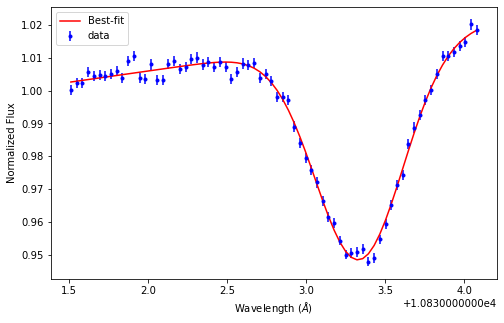

[-6.65512006e-02 -7.35928059e+01  1.08333299e+04  2.74816216e-01
  6.88694081e-03  1.44446164e-02]


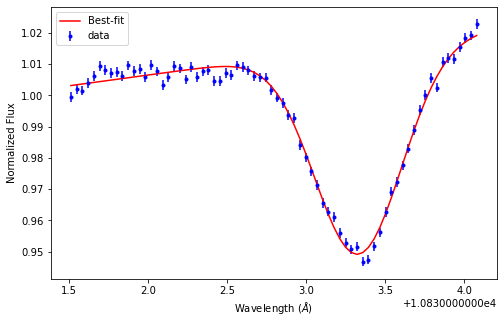

[-6.54654322e-02 -6.94104615e+01  1.08333300e+04  2.71127532e-01
  6.50077663e-03  1.54309843e-02]


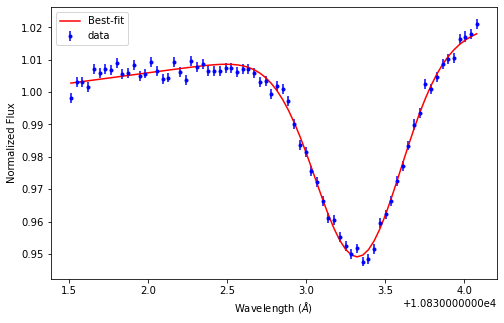

[-6.54039104e-02 -7.28698046e+01  1.08333345e+04  2.73286328e-01
  6.82016611e-03  1.43352882e-02]


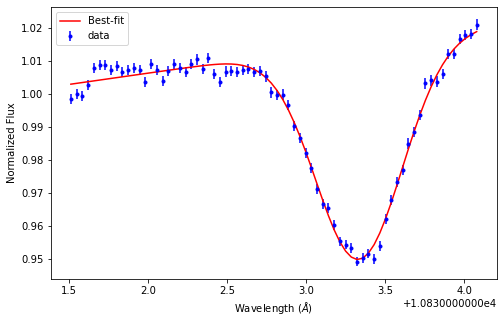

[-6.47960140e-02 -6.57468824e+01  1.08333339e+04  2.71385380e-01
  6.16240871e-03  1.99487222e-02]


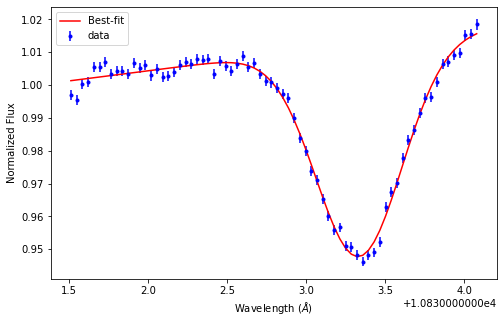

[-6.59344125e-02 -8.30443264e+01  1.08333341e+04  2.84274860e-01
  7.75937220e-03  1.72371896e-02]


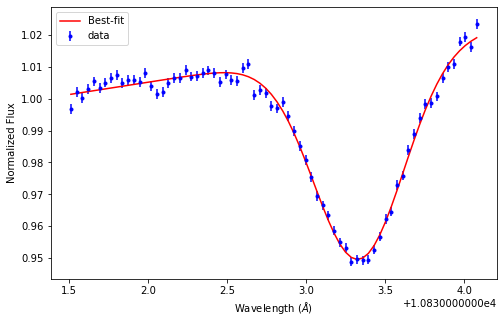

[-6.60713296e-02 -8.16204926e+01  1.08333324e+04  2.78331791e-01
  7.62798390e-03  1.49824867e-02]


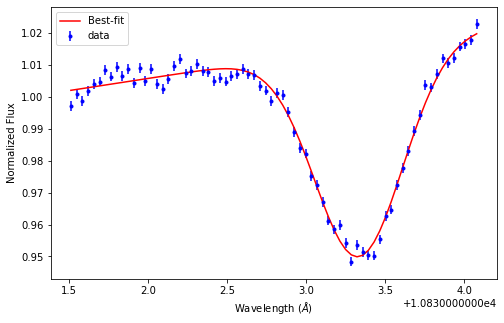

[-6.70227912e-02 -7.70708193e+01  1.08333338e+04  2.79557639e-01
  7.20801166e-03  1.53432713e-02]


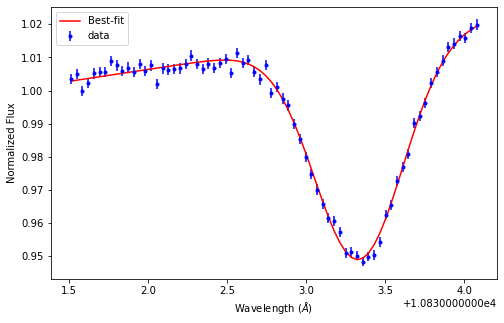

[-6.55251115e-02 -7.86682577e+01  1.08333310e+04  2.81430055e-01
  7.35540724e-03  1.64923533e-02]


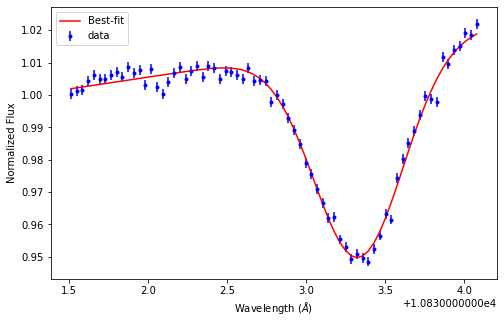

[-6.69677478e-02 -8.38435800e+01  1.08333322e+04  2.83500970e-01
  7.83326591e-03  1.46768979e-02]


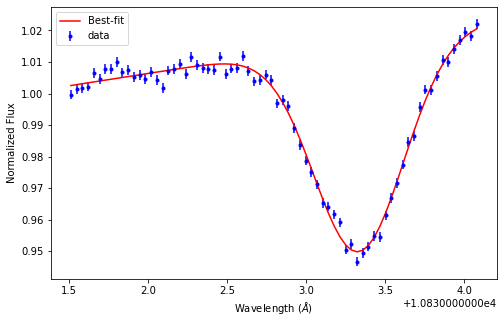

[-6.54052337e-02 -6.81807780e+01  1.08333350e+04  2.78249259e-01
  6.38722554e-03  1.75590774e-02]


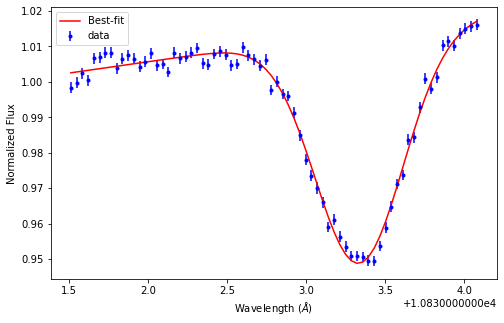

[-6.58025788e-02 -7.60591438e+01  1.08333298e+04  2.77644486e-01
  7.11469830e-03  1.20251928e-02]


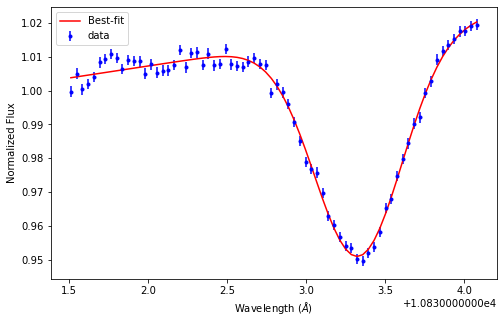

[-6.53402895e-02 -7.15809279e+01  1.08333350e+04  2.75612995e-01
  6.70124040e-03  1.31630474e-02]


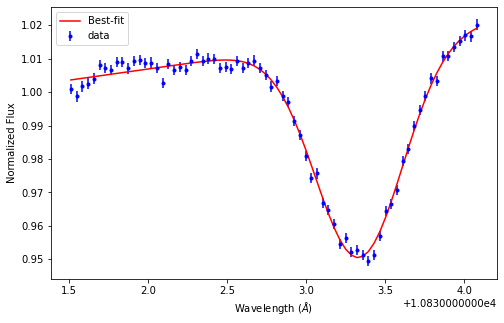

[-6.65291456e-02 -6.02258005e+01  1.08333254e+04  2.73222042e-01
  5.65301524e-03  1.38132774e-02]


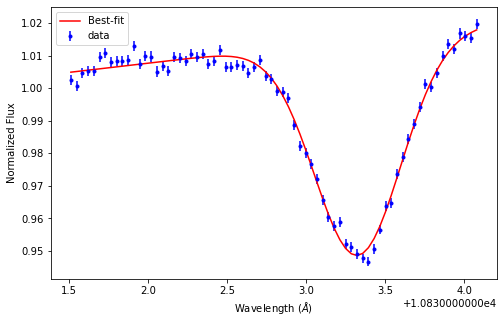

[-6.57093464e-02 -6.29159790e+01  1.08333303e+04  2.74509352e-01
  5.90129269e-03  1.51371922e-02]


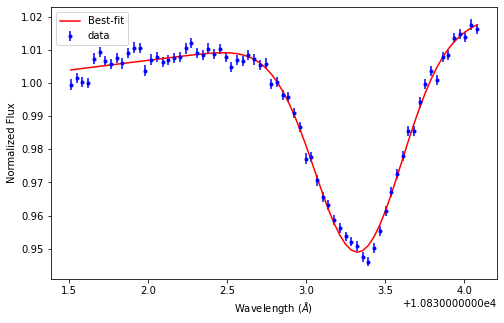

[-6.52183034e-02 -6.10006446e+01  1.08333284e+04  2.80541104e-01
  5.72444576e-03  1.68338038e-02]


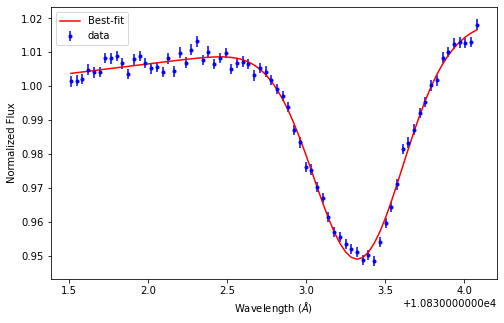

[-6.72564271e-02 -6.92353596e+01  1.08333311e+04  2.77955687e-01
  6.48462484e-03  1.74499497e-02]


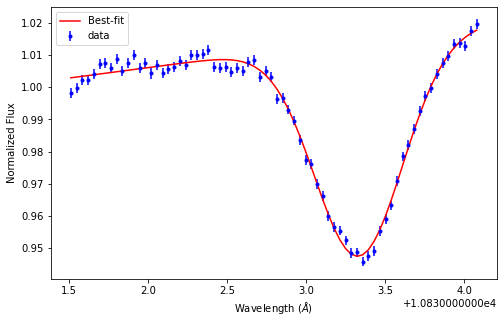

[-6.54212686e-02 -6.31120280e+01  1.08333299e+04  2.85072673e-01
  5.91935653e-03  1.75595557e-02]


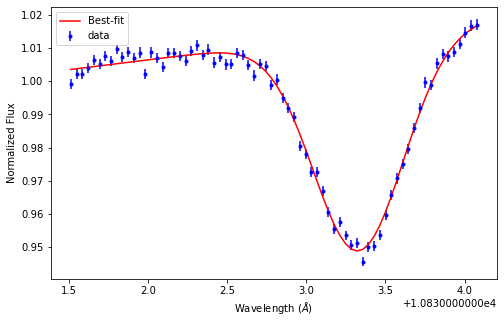

[-6.54796717e-02 -6.76953762e+01  1.08333335e+04  2.83773141e-01
  6.34249269e-03  1.63604148e-02]


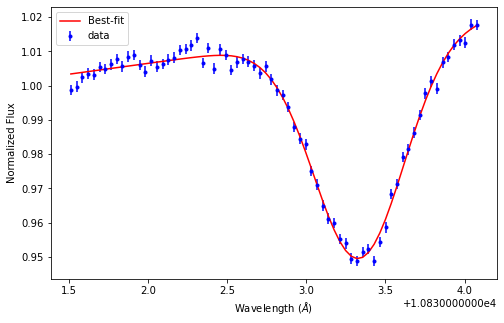

[-6.72292497e-02 -7.75004446e+01  1.08333322e+04  2.87710898e-01
  7.24772219e-03  1.53870268e-02]


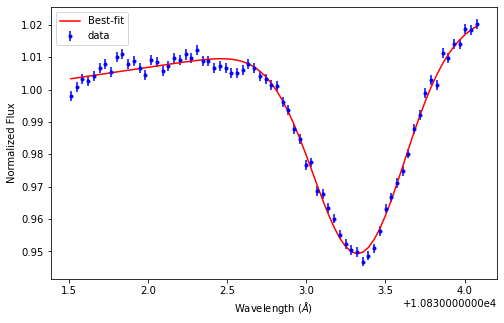

[-6.55017235e-02 -6.55196800e+01  1.08333279e+04  2.82187575e-01
  6.14161371e-03  1.71254946e-02]


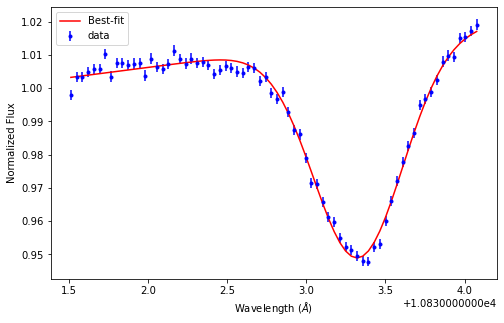

[-6.46987775e-02 -7.16823428e+01  1.08333287e+04  2.92611312e-01
  6.71058568e-03  1.58833306e-02]


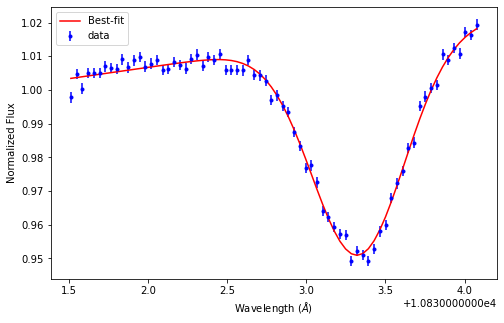

[-6.43342792e-02 -6.83438914e+01  1.08333273e+04  2.85243087e-01
  6.40244898e-03  1.32408739e-02]


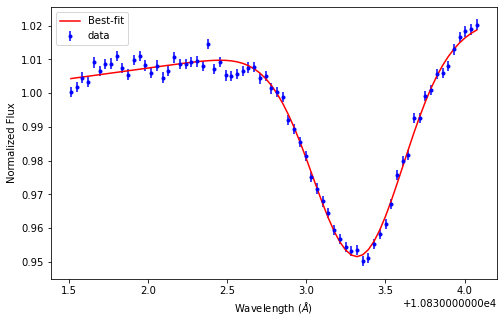

[-6.39450707e-02 -6.69524194e+01  1.08333362e+04  2.84762393e-01
  6.27388238e-03  1.61598515e-02]


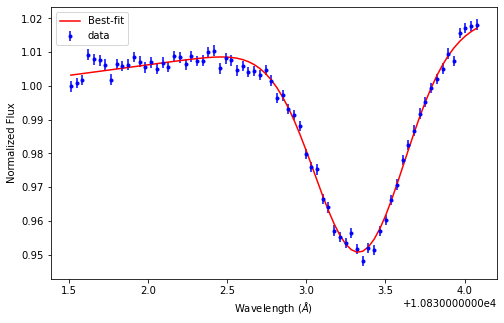

[-6.38662125e-02 -7.85204507e+01  1.08333340e+04  2.97402808e-01
  7.34183716e-03  1.57110263e-02]


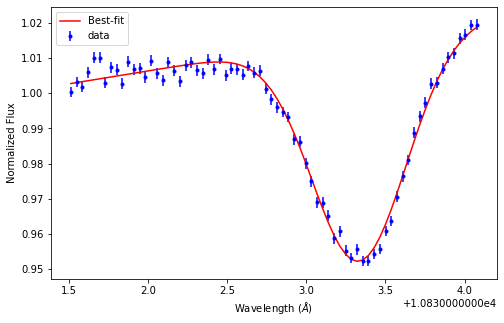

[-6.43416721e-02 -6.72549749e+01  1.08333330e+04  2.78279829e-01
  6.30175133e-03  1.71482345e-02]


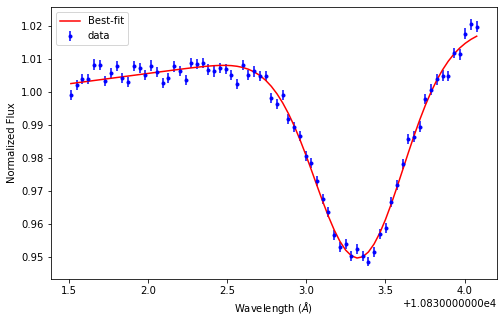

[-6.43000190e-02 -6.65381277e+01  1.08333291e+04  2.91672726e-01
  6.23573513e-03  1.47785632e-02]


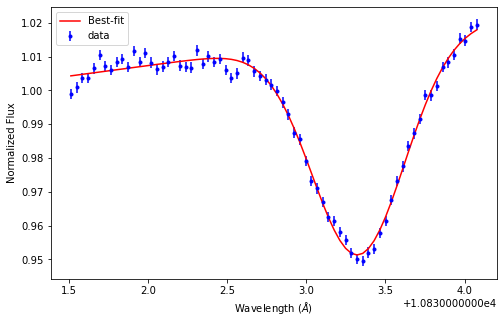

[-6.57866540e-02 -7.27087012e+01  1.08333327e+04  2.89579091e-01
  6.80542308e-03  1.35978907e-02]


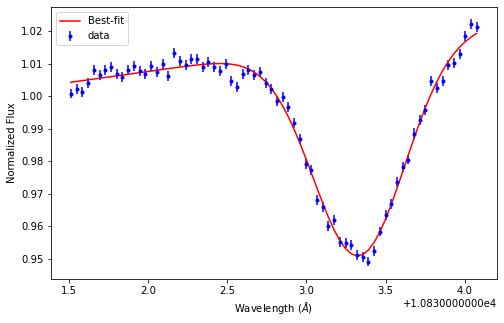

[-6.65793377e-02 -7.09208158e+01  1.08333385e+04  2.89857850e-01
  6.64033863e-03  1.53335182e-02]


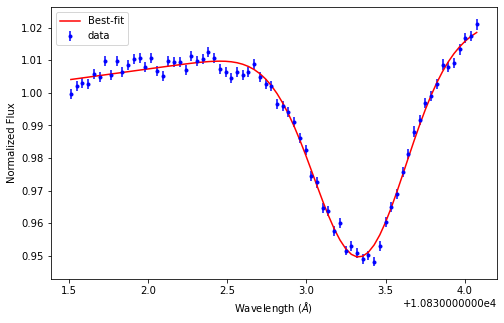

[-6.75105049e-02 -7.66139104e+01  1.08333370e+04  2.89400271e-01
  7.16592173e-03  1.48002263e-02]


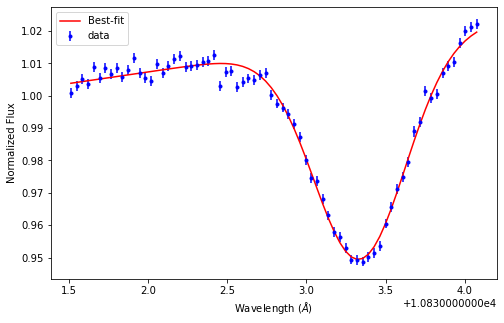

[-6.71563909e-02 -7.57832336e+01  1.08333348e+04  2.81226233e-01
  7.08913506e-03  1.61798209e-02]


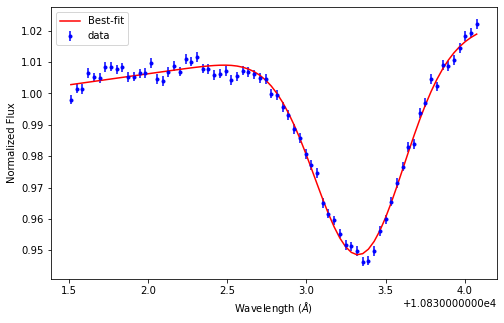

[-6.56013204e-02 -7.92454345e+01  1.08333360e+04  2.76434253e-01
  7.40865987e-03  1.65729037e-02]


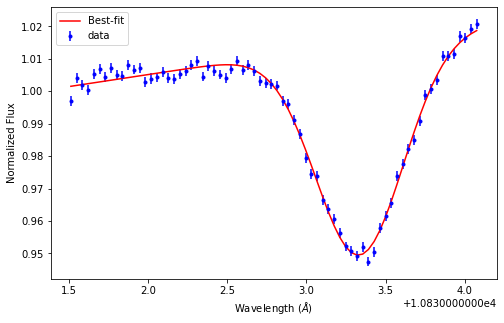

[-6.51354836e-02 -8.26404171e+01  1.08333334e+04  2.82852632e-01
  7.72209651e-03  1.61931096e-02]


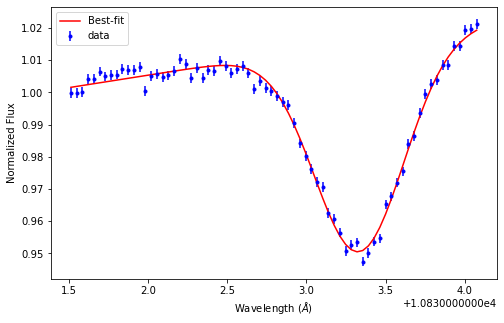

[-6.49684970e-02 -7.72392033e+01  1.08333304e+04  2.74398906e-01
  7.22335071e-03  1.88879833e-02]


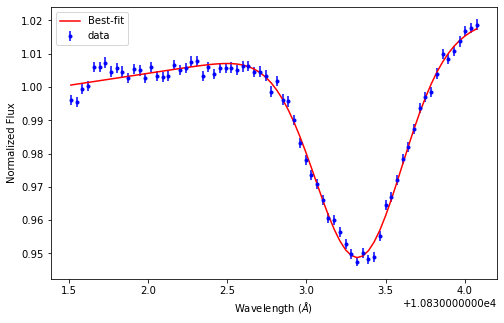

[-6.61738511e-02 -7.24364830e+01  1.08333353e+04  2.74947138e-01
  6.78007954e-03  1.75660397e-02]


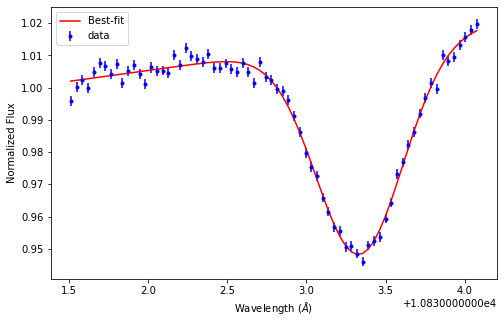

[-6.51667944e-02 -7.16007701e+01  1.08333334e+04  2.76629164e-01
  6.70298890e-03  1.55868325e-02]


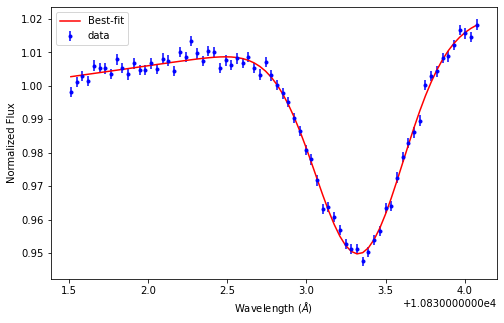

[-6.37953271e-02 -7.24252602e+01  1.08333225e+04  2.77649399e-01
  6.77901753e-03  1.70996433e-02]


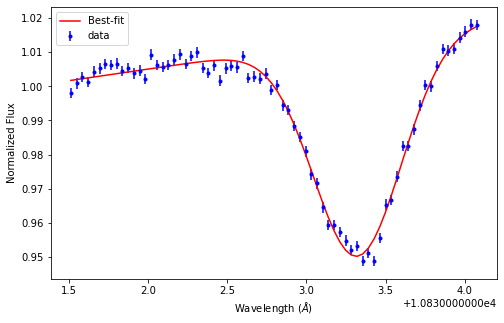

[-6.45446668e-02 -7.77335763e+01  1.08333271e+04  2.77000911e-01
  7.26899116e-03  1.89113878e-02]


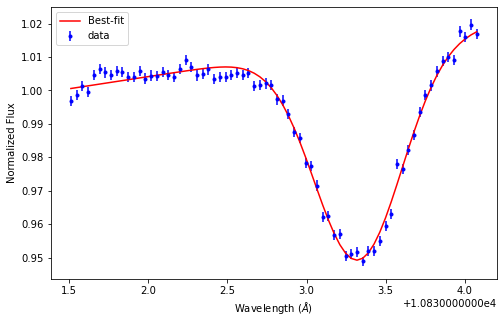

[-6.46073336e-02 -7.87548376e+01  1.08333284e+04  2.74278724e-01
  7.36331608e-03  1.71330454e-02]


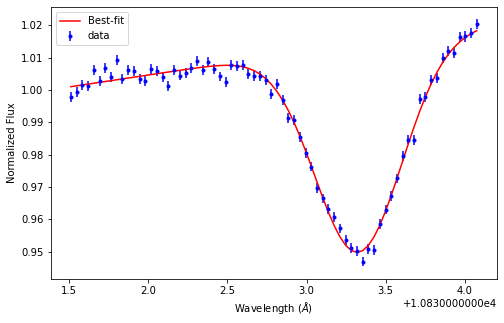

[-6.44266496e-02 -7.05286108e+01  1.08333258e+04  2.71802281e-01
  6.60396779e-03  1.56706417e-02]


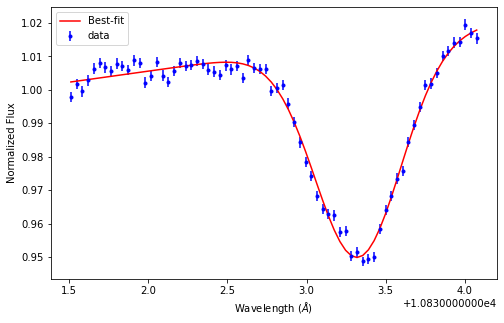

[-6.56996420e-02 -7.93995180e+01  1.08333271e+04  2.88385345e-01
  7.42295262e-03  1.66053072e-02]


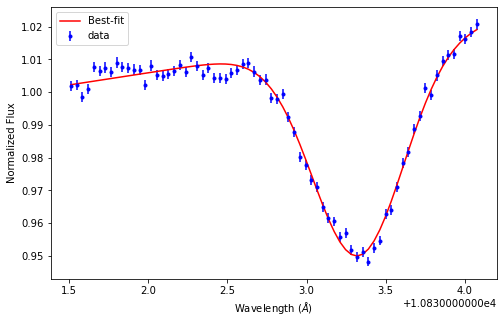

[-6.55365123e-02 -6.68082853e+01  1.08333256e+04  2.73573115e-01
  6.26048264e-03  1.81995970e-02]


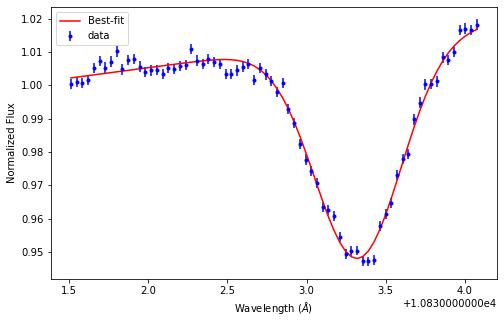

In [123]:
reload(AF)
lower_lim = 10831.5
upper_lim = 10834.1
guess_params = [-0.06, -100, 10833.3, 0.1, 0.008]
bounds_param = ((-np.inf, -np.inf, 10833.2, -np.inf, -np.inf),(0, np.inf, 10833.4, np.inf, np.inf)) 

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):

    theta_HA, err_theta_HA = AF.fit_spctr_line(AF.gaussian_L, AF.eval_gaussian_L, lower_lim, upper_lim, guess_params, 
                                               bounds_param, total_lamda_HA, total_norm_spctr_HA, total_norm_err_HA, 'r')

    theta_HE, err_theta_HE = AF.fit_spctr_line(AF.gaussian_L, AF.eval_gaussian_L, lower_lim, upper_lim, guess_params, 
                                               bounds_param, total_lamda_HE, total_norm_spctr_HE, total_norm_err_HE, 'k')
#If there is one mode of observation
else:
    theta, err_theta = AF.fit_spctr_line(AF.gaussian_L, AF.eval_gaussian_L, lower_lim, upper_lim, guess_params, 
                                               bounds_param, total_lamda, total_norm_spctr, total_norm_err, 'r')

    

## Plotting the positions, depths and widths of the fitted Gaussian lines

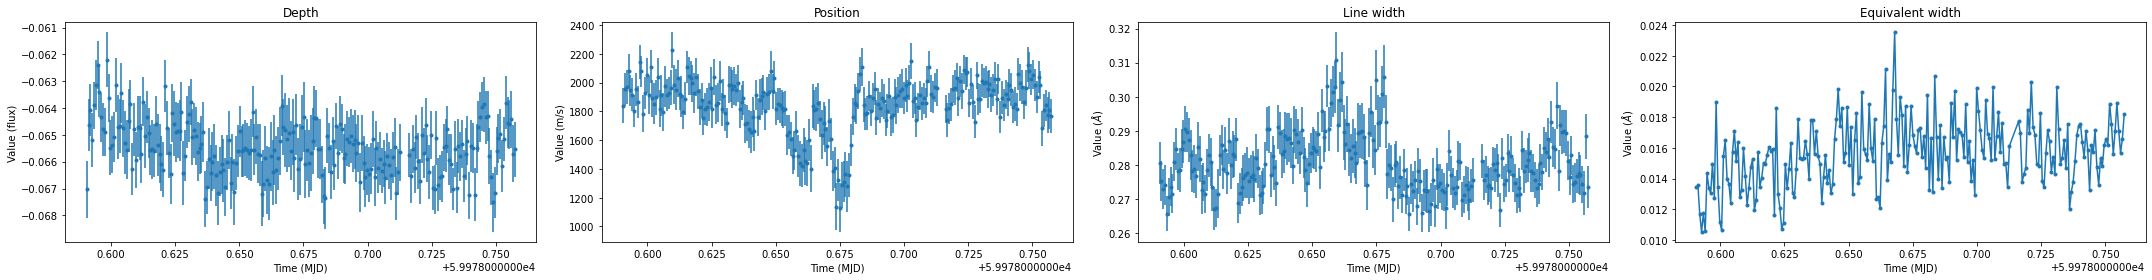

In [124]:
#Distinguish two cases depending on the number of modes of observation.
#If there are two modes of observation.
save = True

ref_He = AF.air2vac((10830.33977+10830.25010)/2) #From NIST database

if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):

    fig, (ax1, ax2, ax3, ax4) = plt.subplots (1, 4, figsize=[30, 4])

    ax1.errorbar(date_HA, theta_HA[:, 0], yerr=err_theta_HA[:, 0], fmt='.')
    ax2.errorbar(date_HA, (theta_HA[:, 2]-ref_He)*3e8/ref_He, yerr=err_theta_HA[:, 2]*3e8/ref_He, fmt='.')
    ax3.errorbar(date_HA, theta_HA[:, 3], yerr=err_theta_HA[:, 3], fmt='.')
    ax4.plot(date_HA, theta_HA[:, -1], '.', linestyle='-')
    ax1.set_xlabel('Time (MJD)')
    ax2.set_xlabel('Time (MJD)')
    ax3.set_xlabel('Time (MJD)')
    ax4.set_xlabel('Time (MJD)')
    ax1.set_ylabel('Value (Flux)')
    ax2.set_ylabel('Value (m/s)')
    ax3.set_ylabel('Value ($\AA$)')
    ax4.set_ylabel('Value ($\AA$)')
    ax1.set_title('Depth for HA')
    ax2.set_title('Position for HA')
    ax3.set_title('Line width for HA')
    ax4.set_title('Equivalent width for HA')

    fig.tight_layout()
    if save:
        plt.savefig('Plot_Results/He_Gaussian_Fit_HA.pdf')
    plt.show()

    fig, (ax4, ax5, ax6, ax7) = plt.subplots (1, 4, figsize=[30, 4])

    ax4.errorbar(date_HE, theta_HE[:, 0], yerr=err_theta_HE[:, 0], fmt='.')
    ax5.errorbar(date_HE, (theta_HE[:, 2]-ref_He)*3e8/ref_He, yerr=err_theta_HE[:, 2]*3e8/ref_He, fmt='.')
    ax6.errorbar(date_HE, theta_HE[:, 3], yerr=err_theta_HE[:, 3], fmt='.')
    ax7.plot(date_HE, theta_HE[:, -1],  '.', linestyle='-')
    ax4.set_xlabel('Time (MJD)')
    ax5.set_xlabel('Time (MJD)')
    ax6.set_xlabel('Time (MJD)')
    ax7.set_xlabel('Time (MJD)')
    ax4.set_ylabel('Value (Flux)')
    ax5.set_ylabel('Value (m/s)')
    ax6.set_ylabel('Value ($\AA$)')
    ax7.set_ylabel('Value ($\AA$)')
    ax4.set_title('Depth for HE')
    ax5.set_title('Position for HE')
    ax6.set_title('Line width for HE')
    ax7.set_title('Equivalent width for HE')

    fig.tight_layout()
    if save:
        plt.savefig('Plot_Results/He_Gaussian_Fit_HE.pdf')
    plt.show()
    
#If there one mode of observation.   
else:
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots (1, 4, figsize=[30, 4])

    ax1.errorbar(date, theta[:, 0], yerr=err_theta[:, 0], fmt='.')
    ax2.errorbar(date, (theta[:, 2]-ref_He)*3e8/ref_He, yerr=err_theta[:, 2]*3e8/ref_He, fmt='.')
    ax3.errorbar(date, theta[:, 3], yerr=err_theta[:, 3], fmt='.')
    ax4.plot(date, theta[:, -1], '.', linestyle='-')
    ax1.set_xlabel('Time (MJD)')
    ax2.set_xlabel('Time (MJD)')
    ax3.set_xlabel('Time (MJD)')
    ax4.set_xlabel('Time (MJD)')
    ax1.set_ylabel('Value (flux)')
    ax2.set_ylabel('Value (m/s)')
    ax3.set_ylabel('Value ($\AA$)')
    ax4.set_ylabel('Value ($\AA$)')
    ax1.set_title('Depth')
    ax2.set_title('Position')
    ax3.set_title('Line width')
    ax4.set_title('Equivalent width')

    fig.tight_layout()
    if save:
        plt.savefig('Plot_Results/He_Gaussian_Fit.pdf')
    plt.show()

## Periodogram for the position, depth and widths of the He line

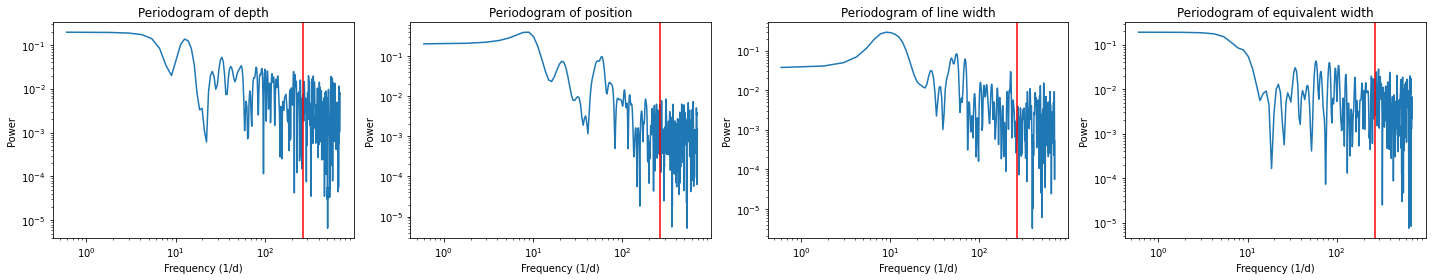

In [127]:
save = True
oscillation_freq = 24*60/5.4 #in 1/days!!

#Distinguish two cases depending on the number of modes of observation.
#If there are two modes of observation.
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):

    fig, (ax1, ax2, ax3, ax4) = plt.subplots (1, 4, figsize=[20, 4])

    LS_depth_HA = LombScargle(date_HA, theta_HA[:, 0]).autopower(nyquist_factor=1)
    LS_position_HA = LombScargle(date_HA, theta_HA[:, 2]).autopower(nyquist_factor=1)
    LS_width_HA = LombScargle(date_HA, theta_HA[:, 3]).autopower(nyquist_factor=1)
    LS_ew_HA = LombScargle(date_HA, theta_HA[:, -1]).autopower(nyquist_factor=1)

    ax1.loglog(LS_depth_HA[0], LS_depth_HA[1])
    ax2.loglog(LS_position_HA[0], LS_position_HA[1])
    ax3.loglog(LS_width_HA[0], LS_width_HA[1])
    ax4.loglog(LS_ew_HA[0], LS_ew_HA[1])
    ax1.set_xlabel('Frequency (1/d)')
    ax2.set_xlabel('Frequency (1/d)')
    ax3.set_xlabel('Frequency (1/d)')
    ax4.set_xlabel('Frequency (1/d)')
    ax1.set_ylabel('Power')
    ax2.set_ylabel('Power')
    ax3.set_ylabel('Power')
    ax4.set_ylabel('Power')
    ax1.set_title('Periodogram of depth for HA')
    ax2.set_title('Periodogram of position for HA')
    ax3.set_title('Periodogram of line width for HA')
    ax4.set_title('Periodogram of equivalenth width for HA')
    ax1.axvline(oscillation_freq, color='r')
    ax2.axvline(oscillation_freq, color='r')
    ax3.axvline(oscillation_freq, color='r')
    ax4.axvline(oscillation_freq, color='r')
    fig.tight_layout()
    if save:
        plt.savefig('Plot_Results/Periodogram_He_fit_HA.pdf')
    plt.show()

    fig, (ax4, ax5, ax6, ax7) = plt.subplots (1, 4, figsize=[20, 4])

    LS_depth_HE = LombScargle(date_HE, theta_HE[:, 0]).autopower(nyquist_factor=1)
    LS_position_HE = LombScargle(date_HE, theta_HE[:, 2]).autopower(nyquist_factor=1)
    LS_width_HE = LombScargle(date_HE, theta_HE[:, 3]).autopower(nyquist_factor=1)
    LS_ew_HE = LombScargle(date_HE, theta_HE[:, -1]).autopower(nyquist_factor=1)

    ax4.loglog(LS_depth_HE[0], LS_depth_HE[1])
    ax5.loglog(LS_position_HE[0], LS_position_HE[1])
    ax6.loglog(LS_width_HE[0], LS_width_HE[1])
    ax7.loglog(LS_ew_HE[0], LS_ew_HE[1])
    ax4.set_xlabel('Frequency (1/d)')
    ax5.set_xlabel('Frequency (1/d)')
    ax6.set_xlabel('Frequency (1/d)')
    ax7.set_xlabel('Frequency (1/d)')
    ax4.set_ylabel('Power')
    ax5.set_ylabel('Power')
    ax6.set_ylabel('Power')
    ax7.set_ylabel('Power')
    ax4.set_title('Periodogram of depth for HE')
    ax5.set_title('Periodogram of position for HE')
    ax6.set_title('Periodogram of line width for HE')
    ax7.set_title('Periodogram of equivalenth width for HE')
    ax4.axvline(oscillation_freq, color='r')
    ax5.axvline(oscillation_freq, color='r')
    ax6.axvline(oscillation_freq, color='r')
    ax7.axvline(oscillation_freq, color='r')
    fig.tight_layout()
    if save:
        plt.savefig('Plot_Results/Periodogram_He_fit_HE.pdf')
    plt.show()
    
#If there is one mode of observation.    
else:
    fig, (ax1, ax2, ax3, ax4) = plt.subplots (1, 4, figsize=[20, 4])

    LS_depth = LombScargle(date, theta[:, 0]).autopower(nyquist_factor=1)
    LS_position = LombScargle(date, theta[:, 2]).autopower(nyquist_factor=1)
    LS_width = LombScargle(date, theta[:, 3]).autopower(nyquist_factor=1)
    LS_ew = LombScargle(date, theta[:, -1]).autopower(nyquist_factor=1)

    ax1.loglog(LS_depth[0], LS_depth[1])
    ax2.loglog(LS_position[0], LS_position[1])
    ax3.loglog(LS_width[0], LS_width[1])
    ax4.loglog(LS_ew[0], LS_ew[1])
    ax1.set_xlabel('Frequency (1/d)')
    ax2.set_xlabel('Frequency (1/d)')
    ax3.set_xlabel('Frequency (1/d)')
    ax4.set_xlabel('Frequency (1/d)')
    ax1.set_ylabel('Power')
    ax2.set_ylabel('Power')
    ax3.set_ylabel('Power')
    ax4.set_ylabel('Power')
    ax1.set_title('Periodogram of depth')
    ax2.set_title('Periodogram of position')
    ax3.set_title('Periodogram of line width')
    ax4.set_title('Periodogram of equivalent width')
    ax1.axvline(oscillation_freq, color='r')
    ax2.axvline(oscillation_freq, color='r')
    ax3.axvline(oscillation_freq, color='r')
    ax4.axvline(oscillation_freq, color='r')
    fig.tight_layout()
    if save:
        plt.savefig('Plot_Results/Periodogram_He_fit.pdf')
    plt.show()
 

## Plotting the timeseries and periodogram of the Radial Velocity

In [ ]:
reload(AF)
save = True
#Distinguish two cases depending on the number of modes of observation.
#If there are two modes of observation.
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    AF.plot_TS_Periodo(date_HA, total_RV_HA, total_RV_err_HA, 'Radial Velocity (km/s)', 'RV', '(HA)', save)
    
    AF.plot_TS_Periodo(date_HE, total_RV_HE, total_RV_err_HE, 'Radial Velocity (km/s)', 'RV', '(HE)', save)
#If there is one mode of observation.
else:
    AF.plot_TS_Periodo(date, total_RV, total_RV_err, 'Radial Velocity (km/s)', 'RV', '', save)

## Plotting the timeseries and periodogram of the FWHM

In [ ]:
reload(AF)
save=True
#Distinguish two cases depending on the number of modes of observation.
#If there are two modes of observation.
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    AF.plot_TS_Periodo(date_HA, total_FWHM_HA, total_FWHM_err_HA,'FWHM (km/s)', 'FWHM', '(HA)', save)
    
    AF.plot_TS_Periodo(date_HE, total_FWHM_HE, total_FWHM_err_HE,'FWHM (km/s)', 'FWHM', '(HE)', save)
#If there is one mode of observation.
else:
    AF.plot_TS_Periodo(date, total_FWHM, total_FWHM_err, 'FWHM (km/s)', 'FWHM', '', save)

## Plotting the timeseries and periodogram of the Bisector Span

In [ ]:
reload(AF)
save=True
#Distinguish two cases depending on the number of modes of observation.
#If there are two modes of observation.
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    AF.plot_TS_Periodo(date_HA, total_BIS_SPAN_HA, total_BIS_SPAN_err_HA, 'Bisector Span (km/s)', 'Bisector Span', '(HA)', save)
    
    AF.plot_TS_Periodo(date_HE, total_BIS_SPAN_HE, total_BIS_SPAN_err_HE, 'Bisector Span (km/s)', 'Bisector Span', '(HE)', save)
#If there is one mode of observation.
else:
    AF.plot_TS_Periodo(date, total_BIS_SPAN, total_BIS_SPAN_err, 'Bisector Span (km/s)', 'Bisector Span', '', save)

## Plotting the timeseries and periodogram of H2O IWV

In [ ]:
reload(AF)
save = True
#Distinguish two cases depending on the number of modes of observation.
#If there are two modes of observation.
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    AF.plot_TS_Periodo(date_HA, total_H2O_HA, total_H2O_err_HA, 'H2O IWV', 'H2O', '(HA)', save)
    
    AF.plot_TS_Periodo(date_HE, total_H2O_HE, total_H2O_err_HE, 'H2O IWV', 'H2O', '(HE)', save)
#If there is one mode of observation.
else:
    AF.plot_TS_Periodo(date, total_H2O, total_H2O_err, 'H2O IWV', 'H2O', '', save)

## Plotting the timeseries and periodogram of O2 IWV

In [ ]:
reload(AF)
save = True
#Distinguish two cases depending on the number of modes of observation.
#If there are two modes of observation.
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    AF.plot_TS_Periodo(date_HA, total_O2_HA, total_O2_err_HA, 'O2 IWV', 'O2', '(HA)', save, fit=True, order=4)
    
    AF.plot_TS_Periodo(date_HE, total_O2_HE, total_O2_err_HE, 'O2 IWV', 'O2', '(HE)', save, fit=True, order=4)
#If there is one mode of observation.
else:
    AF.plot_TS_Periodo(date, total_O2, total_O2_err, 'O2 IWV', 'O2', '', save, fit=True, order=4)

## Plotting the timeseries and periodogram of CO2 IWV

In [ ]:
reload(AF)
save = True
#Distinguish two cases depending on the number of modes of observation.
#If there are two modes of observation.
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    AF.plot_TS_Periodo(date_HA, total_CO2_HA, total_CO2_err_HA, 'CO2 IWV', 'CO2', '(HA)', save, fit=True, order=4)
    
    AF.plot_TS_Periodo(date_HE, total_CO2_HE, total_CO2_err_HE, 'CO2 IWV', 'CO2', '(HE)', save, fit=True, order=4)
#If there is one mode of observation.
else:
    AF.plot_TS_Periodo(date, total_CO2, total_CO2_err, 'CO2 IWV', 'CO2', '', save, fit=True, order=4)

## Fitting a Voigt profile to the Si line

In [ ]:
reload(AF)

lower_l = 10828
upper_l = 10832
guess_para = [0.3, 0.6, 10830, 0.1, 0.2]
bound = ((-np.inf, -np.inf, -np.inf, -np.inf, -np.inf), (np.inf, np.inf, np.inf, np.inf, np.inf))

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):

    theta_Si_HA, err_theta_Si_HA = AF.fit_spctr_line(AF.Voigt, AF.eval_Voigt, lower_l, upper_l, guess_para, bound, 
                  total_lamda_HA, total_norm_spctr_HA, total_norm_err_HA, 'r')
    
    theta_Si_HE, err_theta_Si_HE = AF.fit_spctr_line(AF.Voigt, AF.eval_Voigt, lower_l, upper_l, guess_para, bound, 
                  total_lamda_HE, total_norm_spctr_HE, total_norm_err_HE, 'k')

#If there is one mode of observation
else:
    
    theta_Si, err_theta_Si = AF.fit_spctr_line(AF.Voigt, AF.eval_Voigt, lower_l, upper_l, guess_para, bound, 
                  total_lamda, total_norm_spctr, total_norm_err, 'r')

## Plotting the positions, depths and widths of the fitted Gaussian lines for Si

In [ ]:
reload(AF)
save = True
#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):

    fig, (ax1, ax2, ax3, ax4) = plt.subplots (1, 4, figsize=[30, 4])

    ref_Si = AF.air2vac(10827.091)

    ax1.errorbar(date_HA, theta_Si_HA[:, 1], yerr=err_theta_Si_HA[:, 1], fmt='.')
    ax2.errorbar(date_HA, (theta_Si_HA[:, 2]-ref_Si)*3e8/ref_Si, yerr=err_theta_Si_HA[:, 2]*3e8/ref_Si, fmt='.')
    ax3.errorbar(date_HA, theta_Si_HA[:, 3], yerr=err_theta_Si_HA[:, 3], fmt='.')
    ax4.plot(date_HA, theta_Si_HA[:, -1], '.', linestyle='-')
    ax1.set_xlabel('Seconds (MJD)')
    ax2.set_xlabel('Seconds (MJD)')
    ax3.set_xlabel('Seconds (MJD)')
    ax4.set_xlabel('Seconds (MJD)')
    ax1.set_ylabel('Value (Flux)')
    ax2.set_ylabel('Value (m/s)')
    ax3.set_ylabel('Value ($\AA$)')
    ax4.set_ylabel('Value ($\AA$)')
    ax1.set_title('Depth for HA')
    ax2.set_title('Position for HA')
    ax3.set_title('Line width for HA')
    ax4.set_title('Equivalent width for HA')

    fig.tight_layout()
    if save:
        plt.savefig('Plot_Results/Si_Voigt_Fit_HA.pdf')
    plt.show()

    fig, (ax4, ax5, ax6, ax7) = plt.subplots (1, 4, figsize=[30, 4])

    ax4.errorbar(date_HE, theta_Si_HE[:, 1], yerr=err_theta_Si_HE[:, 1], fmt='.')
    ax5.errorbar(date_HE, (theta_Si_HE[:, 2]-ref_Si)*3e8/ref_Si, yerr=err_theta_Si_HE[:, 2]*3e8/ref_Si, fmt='.')
    ax6.errorbar(date_HE, theta_Si_HE[:, 3], yerr=err_theta_Si_HE[:, 3], fmt='.')
    ax7.plot(date_HE, theta_Si_HE[:, -1], '.', linestyle='-')
    ax4.set_xlabel('Seconds (MJD)')
    ax5.set_xlabel('Seconds (MJD)')
    ax6.set_xlabel('Seconds (MJD)')
    ax7.set_xlabel('Seconds (MJD)')
    ax4.set_ylabel('Value (Flux)')
    ax5.set_ylabel('Value (m/s)')
    ax6.set_ylabel('Value ($\AA$)')
    ax7.set_ylabel('Value ($\AA$)')
    ax4.set_title('Depth for HE')
    ax5.set_title('Position for HE')
    ax6.set_title('Line width for HE')
    ax7.set_title('Equivalent width for HE')

    fig.tight_layout()
    if save:
        plt.savefig('Plot_Results/Si_Voigt_Fit_HE.pdf')
    plt.show()
    
#If there is one mode of observation
else:
    fig, (ax1, ax2, ax3, ax4) = plt.subplots (1, 4, figsize=[30, 4])

    ref_Si = AF.air2vac(10827.091)

    ax1.errorbar(date, theta_Si[:, 1], yerr=err_theta_Si[:, 1], fmt='.')
    ax2.errorbar(date, (theta_Si[:, 2]-ref_Si)*3e8/ref_Si, yerr=err_theta_Si[:, 2]*3e8/ref_Si, fmt='.')
    ax3.errorbar(date, theta_Si[:, 3], yerr=err_theta_Si[:, 3], fmt='.')
    ax4.plot(date, theta_Si[:, -1], '.', linestyle='-')
    ax1.set_xlabel('Seconds (MJD)')
    ax2.set_xlabel('Seconds (MJD)')
    ax3.set_xlabel('Seconds (MJD)')
    ax4.set_xlabel('Seconds (MJD)')
    ax1.set_ylabel('Value (Flux)')
    ax2.set_ylabel('Value (m/s)')
    ax3.set_ylabel('Value ($\AA$)')
    ax4.set_ylabel('Value ($\AA$)')
    ax1.set_title('Depth')
    ax2.set_title('Position')
    ax3.set_title('Line width')
    ax4.set_title('Equivalent width')

    fig.tight_layout()
    if save:
        plt.savefig('Plot_Results/Si_Voigt_Fit.pdf')
    plt.show()


## Periodogram for the position, depth and width of the Si line

In [ ]:
reload(AF)
save = True
#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):

    fig, (ax1, ax2, ax3, ax4) = plt.subplots (1, 4, figsize=[15, 4])

    LS_depth_Si_HA = LombScargle(date_HA, theta_Si_HA[:, 1]).autopower(nyquist_factor=1)
    LS_position_Si_HA = LombScargle(date_HA, theta_Si_HA[:, 2]).autopower(nyquist_factor=1)
    LS_width_Si_HA = LombScargle(date_HA, theta_Si_HA[:, 3]).autopower(nyquist_factor=1)
    LS_ew_Si_HA = LombScargle(date_HA, theta_Si_HA[:, -1]).autopower(nyquist_factor=1)

    ax1.loglog(LS_depth_Si_HA[0], LS_depth_Si_HA[1])
    ax2.loglog(LS_position_Si_HA[0], LS_position_Si_HA[1])
    ax3.loglog(LS_width_Si_HA[0], LS_width_Si_HA[1])
    ax4.loglog(LS_ew_Si_HA[0], LS_ew_Si_HA[1])
    ax1.set_xlabel('Frequency (1/d)')
    ax2.set_xlabel('Frequency (1/d)')
    ax3.set_xlabel('Frequency (1/d)')
    ax4.set_xlabel('Frequency (1/d)')
    ax1.set_ylabel('Power')
    ax2.set_ylabel('Power')
    ax3.set_ylabel('Power')
    ax4.set_ylabel('Power')
    ax1.set_title('Periodogram of depth for HA')
    ax2.set_title('Periodogram of position for HA')
    ax3.set_title('Periodogram of line width for HA')
    ax4.set_title('Periodogram of equivalent width for HA')
    ax1.axvline(oscillation_freq, color='r')
    ax2.axvline(oscillation_freq, color='r')
    ax3.axvline(oscillation_freq, color='r')
    ax4.axvline(oscillation_freq, color='r')
    fig.tight_layout()
    if save:
        plt.savefig('Plot_Results/Periodogram_Si_Fit_HA.pdf')
    plt.show()

    fig, (ax4, ax5, ax6, ax7) = plt.subplots (1, 4, figsize=[15, 4])

    LS_depth_Si_HE = LombScargle(date_HE, theta_Si_HE[:, 1]).autopower(nyquist_factor=1)
    LS_position_Si_HE = LombScargle(date_HE, theta_Si_HE[:, 2]).autopower(nyquist_factor=1)
    LS_width_Si_HE = LombScargle(date_HE, theta_Si_HE[:, 3]).autopower(nyquist_factor=1)
    LS_ew_Si_HE = LombScargle(date_HE, theta_Si_HE[:, -1]).autopower(nyquist_factor=1)

    ax4.loglog(LS_depth_Si_HE[0], LS_depth_Si_HE[1])
    ax5.loglog(LS_position_Si_HE[0], LS_position_Si_HE[1])
    ax6.loglog(LS_width_Si_HE[0], LS_width_Si_HE[1])
    ax7.loglog(LS_ew_Si_HE[0], LS_ew_Si_HE[1])
    ax4.set_xlabel('Frequency (1/d)')
    ax5.set_xlabel('Frequency (1/d)')
    ax6.set_xlabel('Frequency (1/d)')
    ax7.set_xlabel('Frequency (1/d)')
    ax4.set_ylabel('Power')
    ax5.set_ylabel('Power')
    ax6.set_ylabel('Power')
    ax7.set_ylabel('Power')
    ax4.set_title('Periodogram of depth for HE')
    ax5.set_title('Periodogram of position for HE')
    ax6.set_title('Periodogram of line width for HE')
    ax7.set_title('Periodogram of equivalent width for HE')
    ax4.axvline(oscillation_freq, color='r')
    ax5.axvline(oscillation_freq, color='r')
    ax6.axvline(oscillation_freq, color='r')
    ax7.axvline(oscillation_freq, color='r')
    fig.tight_layout()
    if save:
        plt.savefig('Plot_Results/Periodogram_Si_Fit_HE.pdf')
    plt.show()
    
#If there is one mode of observation
else:
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots (1, 4, figsize=[15, 4])

    LS_depth_Si = LombScargle(date, theta_Si[:, 1]).autopower(nyquist_factor=1)
    LS_position_Si = LombScargle(date, theta_Si[:, 2]).autopower(nyquist_factor=1)
    LS_width_Si = LombScargle(date, theta_Si[:, 3]).autopower(nyquist_factor=1)
    LS_ew_Si = LombScargle(date, theta_Si[:, -1]).autopower(nyquist_factor=1)

    ax1.loglog(LS_depth_Si[0], LS_depth_Si[1])
    ax2.loglog(LS_position_Si[0], LS_position_Si[1])
    ax3.loglog(LS_width_Si[0], LS_width_Si[1])
    ax4.loglog(LS_ew_Si[0], LS_ew_Si[1])
    ax1.set_xlabel('Frequency (1/d)')
    ax2.set_xlabel('Frequency (1/d)')
    ax3.set_xlabel('Frequency (1/d)')
    ax4.set_xlabel('Frequency (1/d)')
    ax1.set_ylabel('Power')
    ax2.set_ylabel('Power')
    ax3.set_ylabel('Power')
    ax4.set_ylabel('Power')
    ax1.set_title('Periodogram of depth')
    ax2.set_title('Periodogram of position')
    ax3.set_title('Periodogram of line width')
    ax4.set_title('Periodogram of equivalent width')
    ax1.axvline(oscillation_freq, color='r')
    ax2.axvline(oscillation_freq, color='r')
    ax3.axvline(oscillation_freq, color='r')
    ax4.axvline(oscillation_freq, color='r')
    fig.tight_layout()
    if save:
        plt.savefig('Plot_Results/Periodogram_Si_Fit.pdf')
    plt.show()


## Checking the impact of tellurics

In [ ]:
if new:
    telluric_dir_name = 'Telluric-data'

tot_telluric = np.zeros((len(os.listdir(dir_name)), 4084))

if not new:
    tot_norm_spctr_NC = np.zeros((len(os.listdir(dir_name)), 4084))
    tot_norm_err_NC = np.zeros((len(os.listdir(dir_name)), 4084))

In [ ]:
reload(AF) 

order_ES = 14

#Defining the Sun's BB for later.
Sun_BB = models.BlackBody(temperature = 5778*u.K)
    
for i in range(len(os.listdir(dir_name))):
    if not new:
        file = pf.open(dir_name+'/'+sorted(os.listdir(dir_name))[i])
        file_spctr = file[1].data[order_ES]
        file_err = file[2].data[order_ES]
        file_telluric = file[11].data[order_ES]
        file_DLL = file[6].data[order_ES]
        #Distinguish two cases depending on the number of modes of observation
        #If there are two modes of observation
        if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):

            #Performing Blaze correction
            for j in range(len(os.listdir(blaze_dir))):
                file_blaze = pf.open(blaze_dir+'/'+os.listdir(blaze_dir)[j])
                if file_blaze[0].header['HIERARCH ESO INS MODE'][1] == 'A':
                    blaze_HA = file_blaze
                else:
                    blaze_HE = file_blaze

            #Getting the Blaze spectra for each mode of observation.
            blaze_HA_spctr = blaze_HA[1].data[order_ES]
            blaze_HE_spctr = blaze_HE[1].data[order_ES]

            if file[0].header['HIERARCH ESO INS MODE'] == 'HA':
                A = file_spctr/blaze_HA_spctr
                A_err = file_err/blaze_HA_spctr
            else: 
                A = file_spctr/blaze_HE_spctr
                A_err = file_err/blaze_HE_spctr

            #Removing the trend of the spectrum's continuum using DLL and the Sun's Black Body spectrum.
            B = A/file_DLL
            B_err = A_err/file_DLL

            C = B / Sun_BB(tot_lamda[i]*u.AA).value
            C_err = B_err / Sun_BB(tot_lamda[i]*u.AA).value

            #Making the normalized spectra and error bars.
            tot_norm_spctr_NC[i] = C/np.average(C, weights = 1/C_err**2)
            tot_norm_err_NC[i] = C_err/np.average(C, weights = 1/C_err**2)

        #If there is one mode of observation
        else:
            #Performing the Blaze correction.
            file_blaze = pf.open(blaze_dir+'/'+os.listdir(blaze_dir)[0])

            blaze_spctr = file_blaze[1].data[order_ES]

            A = file_spctr / blaze_spctr
            A_err = file_err / blaze_spctr

            #Removing the trend of the spectrum's continuum using DLL and the Sun's Black Body spectrum.
            B = A/file_DLL
            B_err = A_err/file_DLL

            C = B / Sun_BB(tot_lamda[i]*u.AA).value
            C_err = B_err / Sun_BB(tot_lamda[i]*u.AA).value

            #Making the normalized spectra and error bars.
            tot_norm_spctr_NC[i] = C/np.average(C, weights = 1/C_err**2)
            tot_norm_err_NC[i] = C_err/np.average(C, weights = 1/C_err**2)
    else:
        file = pf.open(telluric_dir_name+'/'+sorted(os.listdir(telluric_dir_name))[i])
        file_telluric = file[6].data[order_ES]

    #Getting the telluric spectra
    tot_telluric[i] = file_telluric


In [ ]:
reload(AF)

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    if not new:
        total_norm_spctr_NC_HA, total_norm_spctr_NC_HE = AF.segment_and_reduce(mode, tot_SNR, tot_norm_spctr_NC, tot_RV, tot_AIRM, sig)

        total_norm_err_NC_HA, total_norm_err_NC_HE = AF.segment_and_reduce(mode, tot_SNR, tot_norm_err_NC, tot_RV, tot_AIRM, sig)

    total_telluric_HA, total_telluric_HE = AF.segment_and_reduce(mode, tot_SNR, tot_telluric, tot_RV, tot_AIRM, sig)

#If there is one mode of observation
else:
    if not new:
        total_norm_spctr_NC = AF.segment_and_reduce(mode, tot_SNR, tot_norm_spctr_NC, tot_RV, tot_AIRM, sig)

        total_norm_err_NC = AF.segment_and_reduce(mode, tot_SNR, tot_norm_err_NC, tot_RV, tot_AIRM, sig)

    total_telluric = AF.segment_and_reduce(mode, tot_SNR, tot_telluric, tot_RV, tot_AIRM, sig)


## PLotting the telluric spectra and the diff between the TC and not TC spectra

In [ ]:
reload(AF)
save = True
#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    
    if not new:
        fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=[14, 10], sharey=True)
        for i in range(len(tota_lamda_HA)):
            if i==0:
                ax1.errorbar(total_lamda_HA[i], total_norm_spctr_HA[i], yerr=total_norm_err_HA[i], label='TC')
                ax1.errorbar(total_lamda_HA[i], total_norm_spctr_NC_HA[i], yerr=total_norm_err_NC_HA[i], label='No TC')
            else:
                ax1.errorbar(total_lamda_HA[i], total_norm_spctr_HA[i], yerr=total_norm_err_HA[i])
                ax1.errorbar(total_lamda_HA[i], total_norm_spctr_NC_HA[i], yerr=total_norm_err_NC_HA[i])
        ax1.set_xlabel('Wavelength ($\AA$)')
        ax1.set_ylabel('Normalized Flux')
        ax1.set_title('Spectrum with and without TC for HA')
        ax1.legend()
        
        for i in range(len(total_lamda_HE)):
            ax2.errorbar(total_lamda_HE[i], total_norm_spctr_HE[i], yerr=total_norm_err_HE[i])
            ax2.errorbar(total_lamda_HE[i], total_norm_spctr_NC_HE[i], yerr=total_norm_err_NC_HE[i])
        ax2.set_xlabel('Wavelength ($\AA$)')
        ax2.set_ylabel('Normalized Flux')
        ax2.set_title('Spectrum with and without TC for HE')
        ax2.legend()


    else:
        fig, ((ax3, ax4), (ax5, ax6)) = plt.subplots(2, 2, figsize=[14, 10], sharey=True)
    for i in range(len(total_lamda_HA)):
        if i==0:
            ax3.plot(total_lamda_HA[i], total_telluric_HA[i], 'r', label='Telluric')
            ax3.errorbar(total_lamda_HA[i], total_norm_spctr_HA[i], yerr=total_norm_err_HA[i], label='Obs.')
        else:
            ax3.plot(total_lamda_HA[i], total_telluric_HA[i], 'r')
            ax3.errorbar(total_lamda_HA[i], total_norm_spctr_HA[i], yerr=total_norm_err_HA[i])

    ax3.set_xlabel('Wavelength ($\AA$)')
    ax3.set_ylabel('Normalized Flux')
    ax3.set_title('Telluric spectrum for HA')
    ax3.set_xlim([10820, 10840])
    ax3.axvline(10833.2, color='g')
    ax3.axvline(10833.3, color='g')
    ax3.axvline(10832.1, color='g', label='He triplet')
    ax3.legend()

    for i in range(len(total_lamda_HA)):
        if not new:
            diff_HA = total_norm_spctr_NC_HA[i] - total_norm_spctr_HA[i]
            ax5.errorbar(total_lamda_HA[i], diff_HA+1, yerr = np.sqrt(total_norm_err_NC_HA[i]**2 + total_norm_err_HA[i]**2), label='Difference')
            ax5.legend()
        ax5.plot(total_lamda_HA[i], total_telluric_HA[i], 'r')
        ax5.errorbar(total_lamda_HA[i], total_norm_spctr_HA[i], yerr=total_norm_err_HA[i])
    ax5.set_xlabel('Wavelength ($\AA$)')
    ax5.set_ylabel('Normalized Flux')
    ax5.set_title('Telluric spectrum')
    ax5.set_xlim([10831, 10838])
    ax5.set_ylim(0.95, 1.05)
    ax5.axvline(10833.2, color='g')
    ax5.axvline(10833.3, color='g')
    ax5.axvline(10832.1, color='g')

    for i in range(len(total_lamda_HE)):
        ax4.plot(total_lamda_HE[i], total_telluric_HE[i], 'r')
        ax4.errorbar(total_lamda_HE[i], total_norm_spctr_HE[i], yerr=total_norm_err_HE[i])
    ax4.set_xlabel('Wavelength ($\AA$)')
    ax4.set_ylabel('Normalized Flux')
    ax4.set_title('Telluric spectrum for HE')
    ax4.set_xlim([10820, 10840])
    ax4.axvline(10833.2, color='g')
    ax4.axvline(10833.3, color='g')
    ax4.axvline(10832.1, color='g')
    
    for i in range(len(total_lamda_HE)):
        if not new:
            diff_HE = total_norm_spctr_NC_HE[i] - total_norm_spctr_HE[i]
            ax6.errorbar(total_lamda_HE[i], diff_HE+1, yerr = np.sqrt(total_norm_err_NC_HE[i]**2 + total_norm_err_HE[i]**2))
        ax6.plot(total_lamda_HE[i], total_telluric_HE[i], 'r')
        ax6.errorbar(total_lamda_HE[i], total_norm_spctr_HE[i], yerr=total_norm_err_HE[i])
    ax6.set_xlabel('Wavelength ($\AA$)')
    ax6.set_ylabel('Normalized Flux')
    ax6.set_title('Telluric spectrum')
    ax6.set_xlim([10831, 10838])
    ax6.set_ylim(0.95, 1.05)
    ax6.axvline(10833.2, color='g')
    ax6.axvline(10833.3, color='g')
    ax6.axvline(10832.1, color='g')

    fig.tight_layout()
    if save:
        plt.savefig('Plot_Results/Telluric_Spectrum.pdf')
    plt.show()

#If there is one mode of observation
else:
    if not new:
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=[10, 10])
        for i in range(len(total_lamda)):
            if i==0:
                ax1.errorbar(total_lamda[i], total_norm_spctr[i], yerr=total_norm_err[i], label='TC')
                ax1.errorbar(total_lamda[i], total_norm_spctr_NC[i], yerr=total_norm_err_NC[i], label='No TC')
            else:
                ax1.errorbar(total_lamda[i], total_norm_spctr[i], yerr=total_norm_err[i])
                ax1.errorbar(total_lamda[i], total_norm_spctr_NC[i], yerr=total_norm_err_NC[i])
        ax1.set_xlabel('Wavelength ($\AA$)')
        ax1.set_ylabel('Normalized Flux')
        ax1.set_title('Spectrum with and without TC')
        ax1.axvline(10833.2, color='g', label='He triplet')
        ax1.axvline(10833.3, color='g')
        ax1.axvline(10832.1, color='g')
        ax1.legend()

    else:
        fig, (ax2, ax3) = plt.subplots(2, 1, figsize=[10, 10])
    for i in range(len(total_lamda)):
        if i==0:
            ax2.plot(total_lamda[i], total_telluric[i], 'r', label='Telluric')
            ax2.errorbar(total_lamda[i], total_norm_spctr[i], yerr=total_norm_err[i], label='Obs.')
        else:
            ax2.plot(total_lamda[i], total_telluric[i], 'r')
            ax2.errorbar(total_lamda[i], total_norm_spctr[i], yerr=total_norm_err[i])
            
    ax2.set_xlabel('Wavelength ($\AA$)')
    ax2.set_ylabel('Normalized Flux')
    ax2.set_title('Telluric spectrum')
    ax2.legend()
    ax2.set_xlim([10820, 10840])
    ax2.axvline(10833.2, color='g')
    ax2.axvline(10833.3, color='g')
    ax2.axvline(10832.1, color='g')
    
    for i in range(len(total_lamda)):
        if not new:
            diff = total_norm_spctr_NC[i] - total_norm_spctr[i]
            if i==0:
                ax3.errorbar(total_lamda[i], diff+1, yerr = np.sqrt(total_norm_err_NC[i]**2 + total_norm_err[i]**2), label='Difference')
            else:
                ax3.errorbar(total_lamda[i], diff+1, yerr = np.sqrt(total_norm_err_NC[i]**2 + total_norm_err[i]**2))
        ax3.plot(total_lamda[i], total_telluric[i], 'r')
        ax3.errorbar(total_lamda[i], total_norm_spctr[i], yerr=total_norm_err[i])
            
    ax3.set_xlabel('Wavelength ($\AA$)')
    ax3.set_ylabel('Normalized Flux')
    ax3.set_title('Telluric spectrum')
    ax3.set_xlim([10831, 10838])
    ax3.set_ylim(0.95, 1.05)
    ax3.axvline(10833.2, color='g')
    ax3.axvline(10833.3, color='g')
    ax3.axvline(10832.1, color='g')
    if not new:
        ax3.legend()
    fig.tight_layout()
    if save:
        plt.savefig('Plot_Results/Telluric_Spectrum.pdf')
    plt.show()


## Fitting the line in the telluric spectra around the He triplet

In [ ]:
reload(AF)

lower_lim_T = 10832.5
upper_lim_T = 10834.1

guess_params_T = [-0.04, 0.05, 10833.3, 0.1, 0.01]
bounds_param_T = ((-np.inf, -np.inf, 10832.9, 0.01, -np.inf), (0, np.inf, 10833.5, np.inf, np.inf)) 

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):

    if not new:
        tot_diff_HA = total_norm_spctr_NC_HA - total_norm_spctr_HA
        tot_diff_err_HA = np.sqrt(total_norm_err_NC_HA**2 + total_norm_err_HA**2)

        tot_diff_HE = total_norm_spctr_NC_HE - total_norm_spctr_HE
        tot_diff_err_HE = np.sqrt(total_norm_err_NC_HE**2 + total_norm_err_HE**2)

        theta_T_HA, err_theta_T_HA = AF.fit_spctr_line(AF.gaussian_L, AF.eval_gaussian_L, lower_lim_T, upper_lim_T, guess_params_T, 
                                                   bounds_param_T, total_lamda_HA, tot_diff_HA, tot_diff_err_HA, 'r')

        theta_T_HE, err_theta_T_HE = AF.fit_spctr_line(AF.gaussian_L, AF.eval_gaussian_L, lower_lim_T, upper_lim_T, guess_params_T, 
                                                   bounds_param_T, total_lamda_HE, tot_diff_HE, tot_diff_err_HE, 'k')
    else:
        
        theta_T_HA, err_theta_T_HA = AF.fit_spctr_line(AF.gaussian_L, AF.eval_gaussian_L, lower_lim_T, upper_lim_T, guess_params_T, 
                                                   bounds_param_T, total_lamda_HA, total_telluric_HA, [], 'r')

        theta_T_HE, err_theta_T_HE = AF.fit_spctr_line(AF.gaussian_L, AF.eval_gaussian_L, lower_lim_T, upper_lim_T, guess_params_T, 
                                                   bounds_param_T, total_lamda_HE, total_telluric_HE, [], 'k')

#If there is one mode of observation
else:
    if not new:
        tot_diff = total_norm_spctr_NC - total_norm_spctr
        tot_diff_err = np.sqrt(total_norm_err_NC**2 + total_norm_err**2)

        theta_T, err_theta_T = AF.fit_spctr_line(AF.gaussian_L, AF.eval_gaussian_L, lower_lim_T, upper_lim_T, guess_params_T, 
                                                   bounds_param_T, total_lamda, tot_diff, tot_diff_err, 'r')
    else:
        
        theta_T, err_theta_T = AF.fit_spctr_line(AF.gaussian_L, AF.eval_gaussian_L, lower_lim_T, upper_lim_T, guess_params_T, 
                                                   bounds_param_T, total_lamda, total_telluric, [], 'r')      


## Plotting the time series of the position, width and depth of this line

In [ ]:
reload(AF)
save = True
#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):

    fig, (ax1, ax2, ax3, ax4) = plt.subplots (1, 4, figsize=[20, 4])

    ax1.errorbar(date_HA, theta_T_HA[:, 0], yerr=err_theta_T_HA[:, 0], fmt='.')
    ax2.errorbar(date_HA, (theta_T_HA[:, 2]-ref_He)*3e8/ref_He, yerr=err_theta_T_HA[:, 2]*3e8/ref_He, fmt='.')
    ax3.errorbar(date_HA, theta_T_HA[:, 3], yerr=err_theta_T_HA[:, 3], fmt='.')
    ax4.plot(date_HA, theta_T_HA[:, -1], '.', linestyle='-')
    
    ax1.set_xlabel('Seconds (MJD)')
    ax2.set_xlabel('Seconds (MJD)')
    ax3.set_xlabel('Seconds (MJD)')
    ax4.set_xlabel('Seconds (MJD)')
    ax1.set_ylabel('Value (Flux)')
    ax2.set_ylabel('Value (m/s)')
    ax3.set_ylabel('Value ($\AA$)')
    ax4.set_ylabel('Value ($\AA$)')
    ax1.set_title('Depth for HA')
    ax2.set_title('Position for HA')
    ax3.set_title('Line width for HA')
    ax4.set_title('Equivalent width for HA')
    fig.tight_layout()
    if save:
        plt.savefig('Plot_Results/Telluric_He_Gaussian_Fit_HA.pdf')
    plt.show()

    fig, (ax4, ax5, ax6, ax7) = plt.subplots (1, 4, figsize=[20, 4])

    ax4.errorbar(date_HE, theta_T_HE[:, 0], yerr=err_theta_T_HE[:, 0], fmt='.')
    ax5.errorbar(date_HE, (theta_T_HE[:, 2]-ref_He)*3e8/ref_He, yerr=err_theta_T_HE[:, 2]*3e8/ref_He, fmt='.')
    ax6.errorbar(date_HE, theta_T_HE[:, 3], yerr=err_theta_T_HE[:, 3], fmt='.')
    ax7.plot(date_HE, theta_T_HE[:, -1], '.', linestyle='-')
    
    ax4.set_xlabel('Seconds (MJD)')
    ax5.set_xlabel('Seconds (MJD)')
    ax6.set_xlabel('Seconds (MJD)')
    ax7.set_xlabel('Seconds (MJD)')
    ax4.set_ylabel('Value (Flux)')
    ax5.set_ylabel('Value (m/s)')
    ax6.set_ylabel('Value ($\AA$)')
    ax7.set_ylabel('Value ($\AA$)')
    ax4.set_title('Depth for HE')
    ax5.set_title('Position for HE')
    ax6.set_title('Line width for HE')
    ax7.set_title('Equivalent width for HE')
    fig.tight_layout()
    if save:
        plt.savefig('Plot_Results/Telluric_He_Gaussian_Fit_HE.pdf')
    plt.show()

#If there is one mode of observation
else:
    fig, (ax1, ax2, ax3, ax4) = plt.subplots (1, 4, figsize=[20, 4])

    ax1.errorbar(date, theta_T[:, 0]/total_AIRM, yerr=err_theta_T[:, 0], fmt='.')
    ax2.errorbar(date, (theta_T[:, 2]-ref_He)*3e8/ref_He, yerr=err_theta_T[:, 2]*3e8/ref_He, fmt='.')
    ax3.errorbar(date, theta_T[:, 3], yerr=err_theta_T[:, 3], fmt='.')
    ax4.plot(date, theta_T[:, -1], '.', linestyle='-')
    
    ax1.set_xlabel('Seconds (MJD)')
    ax2.set_xlabel('Seconds (MJD)')
    ax3.set_xlabel('Seconds (MJD)')
    ax4.set_xlabel('Seconds (MJD)')
    ax1.set_ylabel('Value (Flux)')
    ax2.set_ylabel('Value (m/s)')
    ax3.set_ylabel('Value ($\AA$)')
    ax4.set_ylabel('Value ($\AA$)')
    ax1.set_title('Depth')
    ax2.set_title('Position')
    ax3.set_title('Line width')
    ax4.set_title('Equivalent width')
    fig.tight_layout()
    if save:
        plt.savefig('Plot_Results/Telluric_He_Gaussian_Fit.pdf')
    plt.show()


## Plotting the time series of the air mass and fitting a poynomial

In [ ]:
reload(AF)
save = True
#Distinguish two cases depending on the number of modes of observation.
#If there are two modes of observation.
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    AF.plot_TS_Periodo(date_HA, total_AIRM_HA, [], 'Air Mass', 'Air Mass', '(HA)', save, fit=True, order=4)
    
    AF.plot_TS_Periodo(date_HE, total_AIRM_HE, [], 'Air Mass', 'Air Mass', '(HE)', save, fit=True, order=4)
#If there is one mode of observation.
else:
    AF.plot_TS_Periodo(date, total_AIRM, [], 'Air Mass', 'Air Mass', '', save, fit=True, order=4)

## Detrending the air mass from the CO2 IWV

In [ ]:
reload(AF)
save = True
#Distinguish two cases depending on the number of modes of observation.
#If there are two modes of observation.
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    AF.plot_TS_Periodo(date_HA, total_CO2_HA/total_AIRM_HA, total_CO2_err_HA/total_AIRM_HA, 'CO2 IWV', 'Detrended CO2', '(HA)', save)
    
    AF.plot_TS_Periodo(date_HE, total_CO2_HE/total_AIRM_HE, total_CO2_err_HE/total_AIRM_HE, 'Air Mass', 'Detrended CO2', '(HE)', save)
#If there is one mode of observation.
else:
    AF.plot_TS_Periodo(date, total_CO2/total_AIRM, total_CO2_err/total_AIRM, 'CO2 IWV', 'Detrended CO2', '', save)
    

## Detrending the air mass from the H2O IWV

In [ ]:
reload(AF)
save = True
#Distinguish two cases depending on the number of modes of observation.
#If there are two modes of observation.
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    AF.plot_TS_Periodo(date_HA, total_H2O_HA/total_AIRM_HA, total_H2O_err_HA/total_AIRM_HA, 'H2O IWV', 'Detrended H2O', '(HA)', save)
    
    AF.plot_TS_Periodo(date_HE, total_H2O_HE/total_AIRM_HE, total_H2O_err_HE/total_AIRM_HE, 'Air Mass', 'Detrended H2O', '(HE)', save)
#If there is one mode of observation.
else:
    AF.plot_TS_Periodo(date, total_H2O/total_AIRM, total_H2O_err/total_AIRM, 'H2O IWV', 'Detrended H2O', '', save)

## Plotting the correlation between H2O IWV and the position, depth and width of the He triplet (not the one fit from the telluric spectra but the one fit from the spectra where TC was applied)

In [ ]:
#### FIX THIS PART BECAUSE THE NP.ARGSORT IS USELESS

#Distinguish two cases depending on the number of modes of observation.
#If there are two modes of observation.
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):

    depth_A = np.abs(theta_HA[:,0])[np.argsort(date_HA)]
    pos_A = theta_HA[:,2][np.argsort(date_HA)]
    width_A = theta_HA[:,3][np.argsort(date_HA)]

    H2O_IWVA = total_H2O_HA/total_AIRM_HA
    H2O_IWVA_err = total_H2O_err_HA/total_AIRM_HA
    H2O_IWVA = H2O_IWVA[np.argsort(date_HA)]
    H2O_IWVA_err = H2O_IWVA_err[np.argsort(date_HA)]    

    depth_E = np.abs(theta_HE[:,0])[np.argsort(date_HE)]
    pos_E = theta_HE[:,2][np.argsort(date_HE)]
    width_E = theta_HE[:,3][np.argsort(date_HE)]

    H2O_IWVE = total_H2O_HE/total_AIRM_HE
    H2O_IWVE_err = total_H2O_err_HE/total_AIRM_HE
    H2O_IWVE = H2O_IWVE[np.argsort(date_HE)]
    H2O_IWVE_err = H2O_IWVE_err[np.argsort(date_HE)]    

#If there is one mode of observation.
else:
    depth = np.abs(theta[:,0])[np.argsort(date)]
    pos = theta[:,2][np.argsort(date)]
    width = theta[:,3][np.argsort(date)]

    H2O_IWV = total_H2O/total_AIRM
    H2O_IWV_err = total_H2O_err/total_AIRM
    H2O_IWV = H2O_IWV[np.argsort(date)]
    H2O_IWV_err = H2O_IWV_err[np.argsort(date)]


In [ ]:
reload(AF)
save = True
#Distinguish two cases depending on the number of modes of observation.
#If there are two modes of observation.
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):

    fig, (ax1, ax2, ax3) = plt.subplots (1, 3, figsize=[20, 4])

    x_H2OA = np.linspace(min(H2O_IWVA), max(H2O_IWVA), 1000)

    m_depthA = np.poly1d(np.polyfit(H2O_IWVA, depth_A, 1, w = 1/err_theta_HA[:,0][np.argsort(date_HA)]**2))
    m_posA = np.poly1d(np.polyfit(H2O_IWVA, (pos_A-ref_He)*3e8/ref_He, 1, w = 1/(err_theta_HA[:,2][np.argsort(date_HA)]*3e8/ref_He)**2))
    m_widthA = np.poly1d(np.polyfit(H2O_IWVA, width_A, 1, w = 1/err_theta_HA[:,3][np.argsort(date_HA)]**2))

    ax1.errorbar(H2O_IWVA, depth_A, yerr = err_theta_HA[:,0][np.argsort(date_HA)], xerr = H2O_IWVA_err, fmt='.')
    ax1.plot(x_H2OA, m_depthA(x_H2OA))
    ax2.errorbar(H2O_IWVA, (pos_A-ref_He)*3e8/ref_He, yerr = err_theta_HA[:,2][np.argsort(date_HA)]*3e8/ref_He, xerr = H2O_IWVA_err, fmt='.')
    ax2.plot(x_H2OA, m_posA(x_H2OA))
    ax3.errorbar(H2O_IWVA, width_A, yerr = err_theta_HA[:,3][np.argsort(date_HA)], xerr = H2O_IWVA_err, fmt='.')
    ax3.plot(x_H2OA, m_widthA(x_H2OA))
    ax1.set_xlabel('H2O IWV')
    ax2.set_xlabel('H2O IWV')
    ax3.set_xlabel('H2O IWV')
    ax1.set_ylabel('Value (Flux)')
    ax2.set_ylabel('Value (m/s)')
    ax3.set_ylabel('Value ($\AA$)')
    ax1.set_title('Depth - H2O correlation (HA)')
    ax2.set_title('Position - H2O correlation (HA)')
    ax3.set_title('Line width - H2O correlation (HA)')
    
    fig.tight_layout()
    if save:
        plt.savefig('Plot_Results/Correlation_HA.pdf')
    plt.show()

    print('Depth polynomial:',m_depthA,'\n','Position polynomial:',m_posA,'\n','Width polynomial:',m_widthA)
    print('Depth correlation:', np.corrcoef(H2O_IWVA, depth_A)[0][1])
    print('Position correlation:', np.corrcoef(H2O_IWVA, (pos_A-ref_He)*3e8/ref_He)[0][1])
    print('Width correlation', np.corrcoef(H2O_IWVA, width_A)[0][1])

    
    fig, (ax4, ax5, ax6) = plt.subplots (1, 3, figsize=[20, 4])

    x_H2OE = np.linspace(min(H2O_IWVE), max(H2O_IWVE), 1000)

    m_depthE = np.poly1d(np.polyfit(H2O_IWVE, depth_E, 1, w = 1/err_theta_HE[:,0][np.argsort(date_HE)]**2))
    m_posE = np.poly1d(np.polyfit(H2O_IWVE, (pos_E-ref_He)*3e8/ref_He, 1, w = 1/(err_theta_HE[:,2][np.argsort(date_HE)]*3e8/ref_He)**2))
    m_widthE = np.poly1d(np.polyfit(H2O_IWVE, width_E, 1, w = 1/err_theta_HE[:,3][np.argsort(date_HE)]**2))

    ax4.errorbar(H2O_IWVE, depth_E, yerr=err_theta_HE[:, 0][np.argsort(date_HE)], xerr = H2O_IWVE_err, fmt='.')
    ax4.plot(x_H2OE, m_depthE(x_H2OE))
    ax5.errorbar(H2O_IWVE, (pos_E-ref_He)*3e8/ref_He, yerr=err_theta_HE[:, 2][np.argsort(date_HE)]*3e8/ref_He, xerr = H2O_IWVE_err, fmt='.')
    ax5.plot(x_H2OE, m_posE(x_H2OE))
    ax6.errorbar(H2O_IWVE, width_E, yerr=err_theta_HE[:, 3][np.argsort(date_HE)], xerr = H2O_IWVE_err, fmt='.')
    ax6.plot(x_H2OE, m_widthE(x_H2OE))
    ax4.set_xlabel('H2O IWV')
    ax5.set_xlabel('H2O IWV')
    ax6.set_xlabel('H2O IWV')
    ax4.set_ylabel('Value (Flux)')
    ax5.set_ylabel('Value (m/s)')
    ax6.set_ylabel('Value ($\AA$)')
    ax4.set_title('Depth - H2O correlation (HE)')
    ax5.set_title('Position - H2O correlation (HE)')
    ax6.set_title('Line width - H2O correlation (HE)')

    fig.tight_layout()
    if save:
        plt.savefig('Plot_Results/Correlation_HE.pdf')
    plt.show()

    print('Depth polynomial:',m_depthE,'\n','Position polynomial:',m_posE,'\n','Width polynomial:',m_widthE)
    print('Depth correlation:', np.corrcoef(H2O_IWVE, depth_E)[0][1])
    print('Position correlation:', np.corrcoef(H2O_IWVE, (pos_E-ref_He)*3e8/ref_He)[0][1])
    print('Width correlation', np.corrcoef(H2O_IWVE, width_E)[0][1])

#If there is one mode of observation
else:

    fig, (ax1, ax2, ax3) = plt.subplots (1, 3, figsize=[20, 4])

    x_H2O = np.linspace(min(H2O_IWV), max(H2O_IWV), 1000)

    m_depth = np.poly1d(np.polyfit(H2O_IWV, depth, 1, w = 1/err_theta[:,0][np.argsort(date)]**2))
    m_pos = np.poly1d(np.polyfit(H2O_IWV, (pos-ref_He)*3e8/ref_He, 1, w = 1/(err_theta[:,2][np.argsort(date)]*3e8/ref_He)**2))
    m_width = np.poly1d(np.polyfit(H2O_IWV, width, 1, w = 1/err_theta[:,3][np.argsort(date)]**2))

    ax1.errorbar(H2O_IWV, depth, yerr = err_theta[:,0][np.argsort(date)], xerr = H2O_IWV_err, fmt='.')
    ax1.plot(x_H2O, m_depth(x_H2O))
    ax2.errorbar(H2O_IWV, (pos-ref_He)*3e8/ref_He, yerr = err_theta[:,2][np.argsort(date)]*3e8/ref_He, xerr = H2O_IWV_err, fmt='.')
    ax2.plot(x_H2O, m_pos(x_H2O))
    ax3.errorbar(H2O_IWV, width, yerr = err_theta[:,3][np.argsort(date)], xerr = H2O_IWV_err, fmt='.')
    ax3.plot(x_H2O, m_width(x_H2O))
    ax1.set_xlabel('H2O IWV')
    ax2.set_xlabel('H2O IWV')
    ax3.set_xlabel('H2O IWV')
    ax1.set_ylabel('Value (Flux)')
    ax2.set_ylabel('Value (m/s)')
    ax3.set_ylabel('Value ($\AA$)')
    ax1.set_title('Depth - H2O correlation')
    ax2.set_title('Position - H2O correlation')
    ax3.set_title('Line width - H2O correlation')
    
    fig.tight_layout()
    if save:
        plt.savefig('Plot_Results/Correlation.pdf')
    plt.show()
   
    print('Depth polynomial:',m_depth,'\n','Position polynomial:',m_pos,'\n','Width polynomial:',m_width)
    print('Position correlation:', np.corrcoef(H2O_IWV, (pos-ref_He)*3e8/ref_He)[0][1])
    print('Depth correlation:', np.corrcoef(H2O_IWV, depth)[0][1])
    print('Width correlation', np.corrcoef(H2O_IWV, width)[0][1])
    


## Plotting the correlation between telluric line near He triplet and He triplet

In [ ]:
reload(AF)
#Distinguish two cases depending on the number of modes of observation.
#If there are two modes of observation.
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    
    AF.Correlation_Plot([], theta_T_HE[:, 0], theta_HE[:, 0], err_theta_T_HE[:, 0], err_theta_HE[:, 0], 'Telluric line depth', 'He line depth', 'HE Depth', day)
    AF.Correlation_Plot([], theta_T_HA[:, 0], theta_HA[:, 0], err_theta_T_HA[:, 0], err_theta_HA[:, 0], 'Telluric line depth', 'He line depth', 'HA Depth', day)

    AF.Correlation_Plot([], theta_T_HE[:, 2], theta_HE[:, 2], err_theta_T_HE[:, 2], err_theta_HE[:, 2], 'Telluric line position', 'He line position', 'HE Position', day)
    AF.Correlation_Plot([], theta_T_HA[:, 2], theta_HA[:, 2], err_theta_T_HA[:, 2], err_theta_HA[:, 2], 'Telluric line position', 'He line position', 'HA Position', day)

    AF.Correlation_Plot([], theta_T_HE[:, 3], theta_HE[:, 3], err_theta_T_HE[:, 3], err_theta_HE[:, 3], 'Telluric line width', 'He line width', 'HE Width', day)
    AF.Correlation_Plot([], theta_T_HA[:, 3], theta_HA[:, 3], err_theta_T_HA[:, 3], err_theta_HA[:, 3], 'Telluric line width', 'He line width', 'HA Width', day)

    AF.Correlation_Plot([], theta_T_HE[:, -1], theta_HE[:, -1], [], [], 'Telluric eq. width', 'He eq. width', 'HE eq. width', day)
    AF.Correlation_Plot([], theta_T_HA[:, -1], theta_HA[:, -1], [], [], 'Telluric eq. width', 'He eq. width', 'HA eq. width', day)

else:
    AF.Correlation_Plot([], theta_T[:, 0], theta[:, 0], err_theta_T[:, 0], err_theta[:, 0], 'Telluric line depth', 'He line depth', 'Depth', day)

    AF.Correlation_Plot([], theta_T[:, 2], theta[:, 2], err_theta_T[:, 2], err_theta[:, 2], 'Telluric line position', 'He line position', 'Position', day)

    AF.Correlation_Plot([], theta_T[:, 3], theta[:, 3], err_theta_T[:, 3], err_theta[:, 3], 'Telluric line width', 'He line width', 'Width', day)

    AF.Correlation_Plot([], theta_T[:, -1], theta[:, -1], [], [], 'Telluric eq. width', 'He eq. width', 'eq. width', day)


## Correlation between supposedly stable Si line and telluric line

In [ ]:
[], #Distinguish two cases depending on the number of modes of observation.
#If there are two modes of observation.
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    AF.Correlation_Plot([], theta_T_HE[:, 0], theta_Si_HE[:, 0], err_theta_T_HE[:, 0], err_theta_Si_HE[:, 0], 'Telluric line depth', 'Si line depth', 'HE Depth', day)
    AF.Correlation_Plot([], theta_T_HA[:, 0], theta_Si_HA[:, 0], err_theta_T_HA[:, 0], err_theta_Si_HA[:, 0], 'Telluric line depth', 'Si line depth', 'HA Depth', day)

    AF.Correlation_Plot([], theta_T_HE[:, 2], theta_Si_HE[:, 2], err_theta_T_HE[:, 2], err_theta_Si_HE[:, 2], 'Telluric line position', 'Si line position', 'HE Position', day)
    AF.Correlation_Plot([], theta_T_HA[:, 2], theta_Si_HA[:, 2], err_theta_T_HA[:, 2], err_theta_Si_HA[:, 2], 'Telluric line position', 'Si line position', 'HA Position', day)

    AF.Correlation_Plot([], theta_T_HE[:, 3], theta_Si_HE[:, 3], err_theta_T_HE[:, 3], err_theta_Si_HE[:, 3], 'Telluric line width', 'Si line width', 'HE Width', day)
    AF.Correlation_Plot([], theta_T_HA[:, 3], theta_Si_HA[:, 3], err_theta_T_HA[:, 3], err_theta_Si_HA[:, 3], 'Telluric line width', 'Si line width', 'HA Width', day)

    AF.Correlation_Plot([], theta_T_HE[:, -1], theta_Si_HE[:, -1], [], [], 'Telluric eq. width', 'Si eq. width', 'HE eq. width', day)
    AF.Correlation_Plot([], theta_T_HA[:, -1], theta_Si_HA[:, -1], [], [], 'Telluric eq. width', 'Si eq. width', 'HA eq. width', day)

else:
    AF.Correlation_Plot([], theta_T[:, 0], theta_Si[:, 0], err_theta_T[:, 0], err_theta_Si[:, 0], 'Telluric line depth', 'Si line depth', 'Depth', day)

    AF.Correlation_Plot([], theta_T[:, 2], theta_Si[:, 2], err_theta_T[:, 2], err_theta_Si[:, 2], 'Telluric line position', 'Si line position', 'Position', day)

    AF.Correlation_Plot([], theta_T[:, 3], theta_Si[:, 3], err_theta_T[:, 3], err_theta_Si[:, 3], 'Telluric line width', 'Si line width', 'Width', day)
    
    AF.Correlation_Plot([], theta_T[:, -1], theta_Si[:, -1], [], [], 'Telluric eq. width', 'Si eq. width', 'eq. width', day)


## Correlation between He triplet line and systematics

In [ ]:
#Distinguish two cases depending on the number of modes of observation.
#If there are two modes of observation.
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    AF.Correlation_Plot([], theta_HE[:, 0], systematics_HE, err_theta_HE[:, 0], [], 'He line depth', 'Systematics', 'HE Depth', day)
    AF.Correlation_Plot([], theta_HA[:, 0], systematics_HA, err_theta_HA[:, 0], [], 'He line depth', 'Systematics', 'HA Depth', day)

    AF.Correlation_Plot([], theta_HE[:, 2], systematics_HE, err_theta_HE[:, 2], [], 'He line position', 'Systematics', 'HE Position', day)
    AF.Correlation_Plot([], theta_HA[:, 2], systematics_HA, err_theta_HA[:, 2], [], 'He line position', 'Systematics', 'HA Position', day)

    AF.Correlation_Plot([], theta_HE[:, 3], systematics_HE, err_theta_HE[:, 3], [], 'He line width', 'Systematics', 'HE Width', day)
    AF.Correlation_Plot([], theta_HA[:, 3], systematics_HA, err_theta_HA[:, 3], [], 'He line width', 'Systematics', 'HA Width', day)

    AF.Correlation_Plot([], theta_HE[:, -1], systematics_HE, [], [], 'He eq. width', 'Systematics', 'HE eq. width', day)
    AF.Correlation_Plot([], theta_HA[:, -1], systematics_HA, [], [], 'He eq. width', 'Systematics', 'HA eq. width', day)

else:
    AF.Correlation_Plot([], theta[:, 0], systematics, err_theta[:, 0], [], 'He line depth', 'Systematics', 'Depth', day)

    AF.Correlation_Plot([], theta[:, 2], systematics, err_theta[:, 2], [], 'He line position', 'Systematics', 'Position', day)
    
    AF.Correlation_Plot([], theta[:, 3], systematics, err_theta[:, 3], [], 'He line width', 'Systematics', 'Width', day)
    
    AF.Correlation_Plot([], theta[:, -1], systematics, [], [], 'He eq. width', 'Systematics', 'eq. width', day)


## Correlation between supposedly stable Si line and Helium triplet line

In [ ]:
#Distinguish two cases depending on the number of modes of observation.
#If there are two modes of observation.
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    AF.Correlation_Plot([], theta_HE[:, 0], theta_Si_HE[:, 0], err_theta_HE[:, 0], err_theta_Si_HE[:, 0], 'He line depth', 'Si line depth', 'HE Depth', day)
    AF.Correlation_Plot([], theta_HA[:, 0], theta_Si_HA[:, 0], err_theta_HA[:, 0], err_theta_Si_HA[:, 0], 'He line depth', 'Si line depth', 'HA Depth', day)

    AF.Correlation_Plot([], theta_HE[:, 2], theta_Si_HE[:, 2], err_theta_HE[:, 2], err_theta_Si_HE[:, 2], 'He line position', 'Si line position', 'HE Position', day)
    AF.Correlation_Plot([], theta_HA[:, 2], theta_Si_HA[:, 2], err_theta_HA[:, 2], err_theta_Si_HA[:, 2], 'He line position', 'Si line position', 'HA Position', day)

    AF.Correlation_Plot([], theta_HE[:, 3], theta_Si_HE[:, 3], err_theta_HE[:, 3], err_theta_Si_HE[:, 3], 'He line width', 'Si line width', 'HE Width', day)
    AF.Correlation_Plot([], theta_HA[:, 3], theta_Si_HA[:, 3], err_theta_HA[:, 3], err_theta_Si_HA[:, 3], 'He line width', 'Si line width', 'HA Width', day)

    AF.Correlation_Plot([], theta_HE[:, -1], theta_Si_HE[:, -1], [], [], 'He eq. width', 'Si eq. width', 'HE eq. width', day)
    AF.Correlation_Plot([], theta_HA[:, -1], theta_Si_HA[:, -1], [], [], 'He eq. width', 'Si eq. width', 'HA eq. width', day)

else:
    AF.Correlation_Plot([], theta[:, 0], theta_Si[:, 0], err_theta[:, 0], err_theta_Si[:, 0], 'He line depth', 'Si line depth', 'Depth', day)

    AF.Correlation_Plot([], theta[:, 2], theta_Si[:, 2], err_theta[:, 2], err_theta_Si[:, 2], 'He line position', 'Si line position', 'Position', day)

    AF.Correlation_Plot([], theta[:, 3], theta_Si[:, 3], err_theta[:, 3], err_theta_Si[:, 3], 'He line width', 'Si line width', 'Width', day)
    
    AF.Correlation_Plot([], theta[:, -1], theta_Si[:, -1], [], [], 'He eq. width', 'Si eq. width', 'eq. width', day)


## Random analyses of bad data

In [ ]:
'''reload(AF)

low = 10767
up = 10770
cap = 5
cap2 = 2

new_RV = tot_RV[tot_AIRM<cap2]
new_FWHM = tot_FWHM[tot_AIRM<cap2]
new_BIS_SPAN = tot_BIS_SPAN[tot_AIRM<cap2]
new_CONTRAST = tot_CONTRAST[tot_AIRM<cap2]
new_mode = tot_mode[tot_AIRM<cap2]

new_RV_err = tot_RV_err[tot_AIRM<cap2]
new_FWHM_err = tot_FWHM_err[tot_AIRM<cap2]
new_BIS_SPAN_err = tot_BIS_SPAN_err[tot_AIRM<cap2]
new_CONTRAST_err = tot_CONTRAST_err[tot_AIRM<cap2]


new_SNR = AF.SNR_calculator(low, up, tot_lamda[tot_AIRM<cap2], tot_spctr[tot_AIRM<cap2], tot_err[tot_AIRM<cap2])

#Correlation between SNR and RV
AF.Correlation_Plot(new_mode[new_SNR>cap], new_SNR[new_SNR>cap], new_RV[new_SNR>cap], [], new_RV_err[new_SNR>cap], 'SNR', 'RV (km/s)', 'SNR-RV', day)

#Correlation between SNR and FWHM
AF.Correlation_Plot(new_mode[new_SNR>cap], new_SNR[new_SNR>cap], new_FWHM[new_SNR>cap], [], new_FWHM_err[new_SNR>cap], 'SNR', 'FWHM (km/s)', 'SNR-FWHM', day)

#Correlation between SNR and BIS SPAN
AF.Correlation_Plot(new_mode[new_SNR>cap], new_SNR[new_SNR>cap], new_BIS_SPAN[new_SNR>cap], [], new_BIS_SPAN_err[new_SNR>cap], 'SNR', 'Bisector Span (km/s)', 'SNR-Bisector Span', day)

#Correlation between SNR and CONTRAST
AF.Correlation_Plot(new_mode[new_SNR>cap], new_SNR[new_SNR>cap], new_CONTRAST[new_SNR>cap], [], new_CONTRAST_err[new_SNR>cap], 'SNR', 'Contrast (%)', 'SNR-Contrast', day)

'''